In [1]:
suppressMessages(library(limma))
suppressMessages(library(jsonlite))
suppressMessages(library(progress))
suppressMessages(library(gplots))
suppressMessages(library(dplyr))
suppressMessages(library(metafor))
suppressMessages(library(ggplot2))
suppressMessages(library(org.Mm.eg.db))
suppressMessages(library(annotate))
suppressMessages(library(mygene))
suppressMessages(require("biomaRt"))
#suppressMessages(library(gCMAP))
#suppressMessages(library('qusage'))
#suppressMessages(library(TMixClust))


### FUNCTIONS
source("./post_functions/FUN.Run_functional_GSEA.R")
source("./utils/gather.R")
source("./utils/mouse2human.R")
source("./utils/varplot.R")
source("./utils/get_slopes.R")
source("./plot_functions/corplot.R")
source("./plot_functions/FUN.Visualize_GSEA_heatmap.R")

#OPTIONS
options(warn=-1) #no warnings -1; yes warnings 0

### AGING GENES
age_df <- read.csv('subdata/gene_atlas_aging.csv')
#age <- df[, c('symbol', 'ncbiId', 'ensembl', 'expressionChange', 'methylationCorrelation')]
#expressionChange:: 0 — нет данных; 1 — снижается; 2 — повышается; 3 — неоднозначно
age_gset <- as.character(age_df[, "Gene_ID"])

### AGING SIGNATURES
age <- readRDS("signatures/Signatures_aging_interventions.rds")
names(age)

[1] "Interventions:Median_lifespan" "Interventions:Max_lifespan"   
 [3] "Interventions:CR"              "Interventions:GH_deficiency"  
 [5] "Interventions:Rapamycin"       "Interventions:Common_liver"   
 [7] "Aging:Brain"                   "Aging:Muscle"                 
 [9] "Aging:Liver"                   "Aging:All"                    
[11] "Aging:Human"                   "Aging:Rat"                    
[13] "Aging:Mouse"

# Load data

In [12]:
# Give the input file name to the function.
ultradf <- fromJSON("./data/ultradf_v4.json")

#parsing
for (i in names(ultradf)) {
    df <- read.csv(text=ultradf[[i]]$data, row.names=2)[, -1]
    pheno <- read.csv(text=ultradf[[i]]$pheno)
    stopifnot(nrow(pheno)==ncol(df))
    ultradf[[i]]$data <- df
    ultradf[[i]]$pheno <- pheno
}

In [7]:
ultrahuman <- fromJSON("./data/ultradf_human.json")

#parsing
for (i in names(ultrahuman)) {
    df <- read.csv(text=ultrahuman[[i]]$data, row.names=2)[, -1]
    pheno <- read.csv(text=ultrahuman[[i]]$pheno)
    stopifnot(nrow(pheno)==ncol(df))
    ultrahuman[[i]]$data <- df
    ultrahuman[[i]]$pheno <- pheno
}

In [4]:
gid <- list()
for (i in names(ultrahuman)){
    gid[[i]] <- rownames(ultrahuman[[i]]$data)
}

human_ids <- Reduce(intersect, gid)
length(human_ids)

[1] 15244

In [5]:
one2one <- mouse2human(human_ids)

In [6]:
write.csv(one2one, 'utils/human2mouse_entrez.csv')

In [7]:
one2one <- read.csv('utils/human2mouse_entrez.csv')
#convert human to mouse in all human datasets
for (i in 1:length(ultrahuman)){
    tmp <- ultrahuman[[i]]$data[as.character(one2one$human),]
    rownames(tmp) <- as.character(one2one$mouse)
    ultrahuman[[i]]$data <- tmp
}

In [3]:
ultradf <- ultrahuman

In [8]:
#merge mouse and human
ultradf <- c(ultradf, ultrahuman)

# Test datasets with Controls

In [14]:
#Returns result of treat_vs_control model as dataframe of statistics
treat_vs_control <- function(database, treat, control, prohibited=c(), 
                            return_df=FALSE,
                            coefs=c("Day", "Treatment", 'Day.Treatment')){
    #treatment
    list1 <-database[[treat]]
    idx1 <- which(names(list1$data) %in% setdiff(names(list1$data), prohibited))
    df1 <- list1$data[idx1]
    time1 <- list1$time[idx1]
    treat1 <- rep(1, length(time1))

    #control
    list2 <-database[[control]]
    idx2 <- which(names(list2$data) %in% setdiff(names(list2$data), prohibited))
    df2 <- list2$data[idx2]
    time2 <- list2$time[idx2]
    treat2 <- rep(0, length(time2))

    #merge treat and control
    df <- cbind(df1, df2)
    time <- c(time1, time2)
    treat <- c(treat1, treat2)

    #create design matrix
    design <- data.frame(row.names=colnames(df))
    design['Intercept'] <- rep(1, length(colnames(df)))
    design['Day'] <- time 
    design['Treatment'] <- treat
    design['Day.Treatment'] <- treat * time

    #analyze
    fit <- lmFit(df, design=design)
    fit <- eBayes(fit)
    bysort <- if(length(coefs)==1) "t" else "F"
    result <- topTable(fit, adjust.method="BH", sort.by=bysort, coef=coefs, n=Inf, confint=T)
    
    if (return_df==TRUE){
        return(list("df"=df, "res"=result, "time"=time, "treat"=treat))
    }else{
        return(result)
    }
    
}

#Do treat_vs_control procedure over all datasets belonging one GSE (paper)
treat_vs_control_multiple <- function(database, list_of_treat, control, FDR_thr=0.01, prohibited=c()){
    passed_genes_list <- c()
    for (key in list_of_treat){
        result <- treat_vs_control(database, key, control, prohibited)
        #union of genes passed F-test
        passed <- rownames(result[result$adj.P.Val < FDR_thr,])
        passed_genes_list <- union(passed_genes_list, passed)
    }
    return(passed_genes_list)
}

get_full_statistics <- function(treat_name, control_name, prohibited=c("GSM943794", "GSM943795")){
    fs <- data.frame(row.names=rownames(ultradf[[treat_name]]$data)) #fs = full statistics
    coefs <- c("Intercept", "Day", "Treatment", "Day.Treatment")
    for (coef in coefs){
        L <- treat_vs_control(ultradf, 
                                treat=treat_name,
                                control=control_name, 
                                prohibited=prohibited, 
                                return_df=TRUE,
                                coefs=c(coef))
        #tmp <- L$res['logFC']
        L$res[coef] <- L$res['logFC']
        L$res[paste(coef, ".FDR", sep='')] <- L$res['adj.P.Val']
        fs <- transform(merge(fs, L$res[c(coef, paste(coef, ".FDR", sep=''))], by=0, sort=F,), 
                                    row.names=Row.names, Row.names=NULL)
    }
    return(fs)
}

get_clusters <- function(fs, fdr_thr=0.05, verbose=T){
    #create clusters
    #first we create a table
    # z=zero, g=growth, f=fail, u=up, d=down
    lt <- data.frame(row.names=rownames(fs)) #lt = logic table
    lt['zg'] <- (fs[["Day.FDR"]] >= fdr_thr) & (fs[["Day.Treatment.FDR"]] < fdr_thr) & (fs[["Day.Treatment"]] > 0)
    lt['zf'] <- (fs[["Day.FDR"]] >= fdr_thr) & (fs[["Day.Treatment.FDR"]] < fdr_thr) & (fs[["Day.Treatment"]] < 0)
    lt['zu'] <- (fs[["Day.FDR"]] >= fdr_thr) & (fs[["Treatment.FDR"]] < fdr_thr) & (fs[["Treatment"]] > 0) & 
                (fs[["Day.Treatment.FDR"]] >= fdr_thr)
    lt['zd'] <- (fs[["Day.FDR"]] >= fdr_thr) & (fs[["Treatment.FDR"]] < fdr_thr) & (fs[["Treatment"]] < 0) & 
                (fs[["Day.Treatment.FDR"]] >= fdr_thr)
    lt['gu'] <- (fs[["Day.FDR"]] < fdr_thr) & (fs[["Day"]] > 0) & (fs[["Treatment.FDR"]] < fdr_thr) & 
                (fs[["Treatment"]] > 0) & (fs[["Day.Treatment.FDR"]] >= fdr_thr)
    lt['gd'] <- (fs[["Day.FDR"]] < fdr_thr) & (fs[["Day"]] > 0) & (fs[["Treatment.FDR"]] < fdr_thr) & 
                (fs[["Treatment"]] < 0) & (fs[["Day.Treatment.FDR"]] >= fdr_thr)
    lt['fu'] <- (fs[["Day.FDR"]] < fdr_thr) & (fs[["Day"]] < 0) & (fs[["Treatment.FDR"]] < fdr_thr) & 
                (fs[["Treatment"]] > 0) & (fs[["Day.Treatment.FDR"]] >= fdr_thr)
    lt['fd'] <- (fs[["Day.FDR"]] < fdr_thr) & (fs[["Day"]] < 0) & (fs[["Treatment.FDR"]] < fdr_thr) & 
                (fs[["Treatment"]] < 0) & (fs[["Day.Treatment.FDR"]] >= fdr_thr)
    lt['gf'] <- (fs[["Day.FDR"]] < fdr_thr) & (fs[["Day"]] > 0) & (fs[["Day.Treatment.FDR"]] < fdr_thr) &
                (fs[["Day.Treatment"]] < 0)
    lt['fg'] <- (fs[["Day.FDR"]] < fdr_thr) & (fs[["Day"]] < 0) & (fs[["Day.Treatment.FDR"]] < fdr_thr) &
                (fs[["Day.Treatment"]] > 0)
    #second we create a list of genes across clusters
    ll <- list() #ll = logic list
    total <- 0
    for (n in names(lt)){
        s <- sum(lt[[n]])
        total = total + s
        ll[[n]] <- rownames(lt[lt[[n]],])
        if (verbose==T){cat(n, s, '\n')}
    }
    if (verbose==T){
        cat("Total =", total, '\n')
        cat("Total unique =", length(Reduce(union, ll)))
    }
    return(list("lt"=lt, "ll"=ll))
}

cluster_combination <- function(c1, c2, func=union){
  res <- list()
  for (n in names(c1)){
    res[[n]] <- func(c1[[n]], c2[[n]])
  }
  return(res)
}

In [15]:
###F-statistics based intersection
passed1 <- treat_vs_control_multiple(
                            ultradf, 
                            list_of_treat=c('GSE38509$OSKM', 'GSE38509$OSK'), 
                            control='GSE38509$GFP', 
                            FDR_thr=0.01, 
                            prohibited=c("GSM943794", "GSM943795"))

passed2 <- treat_vs_control_multiple(
                            ultradf, 
                            list_of_treat=c('GSE103979$Oct4+SK', 'GSE103979$Oct6+SK', 'GSE103979$Oct4+defSox+K'), 
                            control='GSE103979$GFP', 
                            FDR_thr=0.01, 
                            prohibited=c())                           

treat_vs_control_intersection <- intersect(passed1, passed2)
cat(" Passed first", length(passed1), "\n",
    "Passed second", length(passed2), "\n",
    "Intersection", length(treat_vs_control_intersection))

 Passed first 9055 
 Passed second 6593 
 Intersection 4116

In [16]:
names(ultradf)

[1] "GSE67462$OSKM"             "GSE38509$OSKM"            
 [3] "GSE38509$OSK"              "GSE38509$GFP"             
 [5] "GSE116309$OKMS"            "GSE116309$OK+9MS"         
 [7] "GSE46321$C/EBPα+ OSKM"     "GSE46321$C/EBPα- OSKM"    
 [9] "GSE10871$OSKM"             "GSE21757$OKMS"            
[11] "GSE103979$Oct4+SK"         "GSE103979$Oct6+SK"        
[13] "GSE103979$Oct4+defSox+K"   "GSE103979$GFP"            
[15] "GSE114581$OSKM+dox_mef"    "GSE114581$OSKM-dox_mef"   
[17] "GSE127927$7F-Esrrb"        "GSE127927$7F-Glis1"       
[19] "GSE127927$7F-Jdp2"         "GSE127927$7F-Kdm2b"       
[21] "GSE127927$7F-Mkk6"         "GSE127927$7F-Nanog"       
[23] "GSE127927$7F-Sall4"        "GSE127927$7F"             
[25] "GSE127927$GFP"             "GSE102348$OSKM$Gatad2a-/-"
[27] "GSE102348$OSKM$Mbd3f/-"    "GSE102348$OSKM$WT-1"      
[29] "GSE102348$OSKM$WT-2"

In [17]:
###treat vs control advanced with gene clustering by type of expression changes
studies <- list()

treat_name <- 'GSE114581$OSKM+dox_mef'
control_name <- 'GSE114581$OSKM-dox_mef'
fs <- get_full_statistics(treat_name, control_name, prohibited=c())
clusters <- get_clusters(fs, 0.05, F)
studies[[treat_name]] <- clusters$ll

for (treat_name in c('GSE38509$OSKM', 'GSE38509$OSK')){
    control_name <- 'GSE38509$GFP'
    fs <- get_full_statistics(treat_name, control_name, prohibited=c("GSM943794", "GSM943795"))
    clusters <- get_clusters(fs, 0.05, F)
    studies[[treat_name]] <- clusters$ll
}

#bad RNA seq
for (treat_name in c('GSE103979$Oct4+SK', 'GSE103979$Oct6+SK', 'GSE103979$Oct4+defSox+K')){
    control_name <- 'GSE103979$GFP'
    fs <- get_full_statistics(treat_name, control_name, prohibited=c())
    clusters <- get_clusters(fs, 0.05, F)
    studies[[treat_name]] <- clusters$ll
}

for (treat_name in c('GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 'GSE127927$7F-Kdm2b', 
                     'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 'GSE127927$7F-Sall4', 'GSE127927$7F')){
    control_name <- 'GSE127927$GFP'
    fs <- get_full_statistics(treat_name, control_name, prohibited=c())
    clusters <- get_clusters(fs, 0.05, F)
    studies[[treat_name]] <- clusters$ll
}

In [18]:
GSE114581 <- studies[['GSE114581$OSKM+dox_mef']]
GSE38509 <- cluster_combination(studies[['GSE38509$OSKM']], studies[['GSE38509$OSK']], union)
GSE103979 <- Reduce(function(x, y) cluster_combination(x, y, union), 
    studies[c('GSE103979$Oct4+SK', 'GSE103979$Oct6+SK', 'GSE103979$Oct4+defSox+K')])
GSE127927 <- Reduce(function(x, y) cluster_combination(x, y, union), 
    studies[c('GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 'GSE127927$7F-Kdm2b', 
              'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 'GSE127927$7F-Sall4', 'GSE127927$7F')])

array_clusters <- Reduce(function(x, y) cluster_combination(x, y, intersect), 
    list(GSE114581=GSE114581, GSE38509=GSE38509, GSE127927=GSE127927))

#array_clusters <- cluster_combination(GSE114581, GSE38509, intersect)

lapply(array_clusters, length)

length(Reduce(union, array_clusters))

$zg
[1] 12

$zf
[1] 8

$zu
[1] 22

$zd
[1] 24

$gu
[1] 0

$gd
[1] 0

$fu
[1] 0

$fd
[1] 1

$gf
[1] 11

$fg
[1] 7

[1] 85

Finished


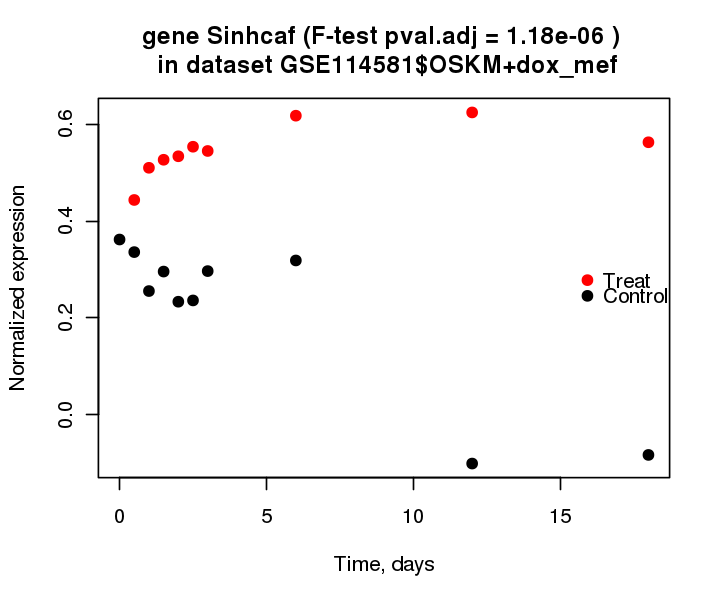

In [21]:
#Build expression of particular gene based on the treat_vs_control test
treat_name <- 'GSE114581$OSKM+dox_mef'
control_name <- 'GSE114581$OSKM-dox_mef'

L <- treat_vs_control(ultradf, 
                        treat=treat_name,
                        control=control_name, 
                        prohibited=c("GSM943794", "GSM943795"), 
                        return_df=TRUE,
                        coefs=c("Treatment", 'Day.Treatment'))
df <- L$df
time <- L$time
treat <- L$treat
stat <- L$res
gene_id <- "56306"

gene_sym <- as.data.frame(queryMany(c(gene_id), scopes="entrezgene", species="mouse"))$symbol

options(repr.plot.width=6, repr.plot.height=5)
plot(time, df[gene_id,], col=treat+1, pch=19, 
    main=paste("gene", gene_sym, "(F-test pval.adj =", format.pval(stat[gene_id,]$adj.P.Val, digits = 3), ")",
                "\n in dataset", treat_name),
    xlab="Time, days", ylab='Normalized expression')
legend("right", legend = c("Treat", "Control"), col = c(2, 1), pch=19, bty="n")

# Limma slopes

In [52]:
merged_clusters <- Reduce(union, array_clusters)

In [13]:
tmp_result <- get_slopes(ultradf, stoplist=c(), genelist=c())
datasets_list <- tmp_result[['datasets']]
slopes <- tmp_result[['slopes']]

GSE67462$OSKM Pheno: 16 Total: 20479 Passed: 5469 
GSE38509$OSKM Pheno: 18 Total: 20955 Passed: 5255 
GSE38509$OSK Pheno: 6 Total: 20955 Passed: 1050 
GSE38509$GFP Pheno: 11 Total: 20955 Passed: 5062 
GSE116309$OKMS Pheno: 4 Total: 20955 Passed: 0 
GSE116309$OK+9MS Pheno: 4 Total: 20955 Passed: 1253 
GSE46321$C/EBPα+ OSKM Pheno: 18 Total: 22036 Passed: 10185 
GSE46321$C/EBPα- OSKM Pheno: 18 Total: 22036 Passed: 1878 
GSE10871$OSKM Pheno: 8 Total: 20887 Passed: 64 
GSE21757$OKMS Pheno: 7 Total: 16480 Passed: 1815 
GSE103979$Oct4+SK Pheno: 10 Total: 12368 Passed: 5120 
GSE103979$Oct6+SK Pheno: 10 Total: 12368 Passed: 3182 
GSE103979$Oct4+defSox+K Pheno: 10 Total: 12368 Passed: 3681 
GSE103979$GFP Pheno: 10 Total: 12368 Passed: 3369 
GSE114581$OSKM+dox_mef Pheno: 9 Total: 13063 Passed: 3108 
GSE114581$OSKM-dox_mef Pheno: 10 Total: 13063 Passed: 3713 
GSE127927$7F-Esrrb Pheno: 5 Total: 12080 Passed: 541 
GSE127927$7F-Glis1 Pheno: 5 Total: 12080 Passed: 46 
GSE127927$7F-Jdp2 Pheno: 5 Total:

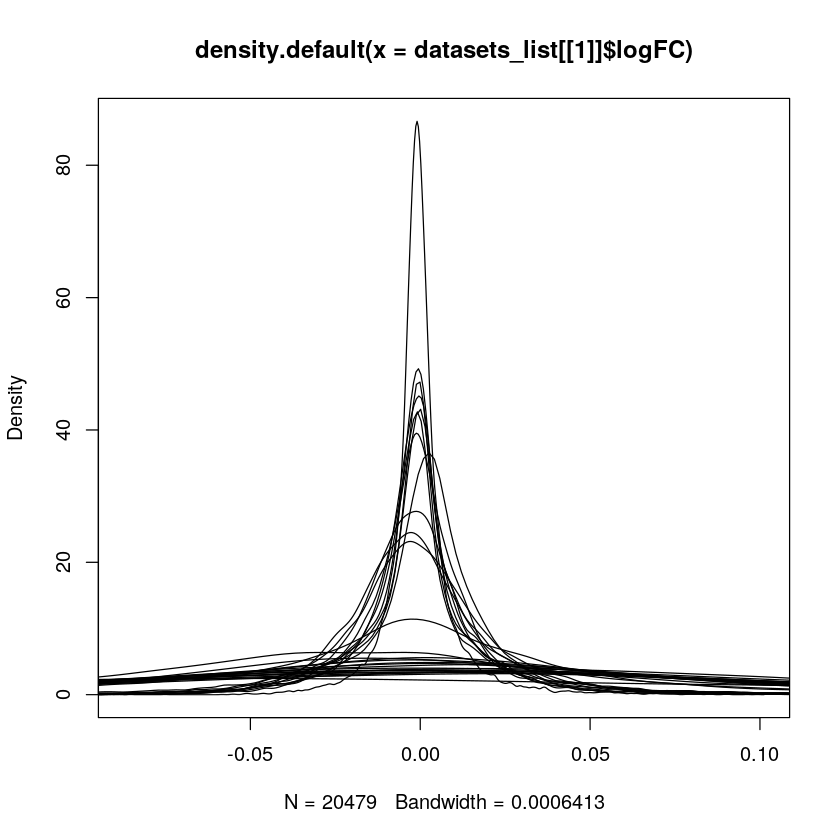

In [7]:
# plot(density(datasets_list[[1]]$logFC))
# for (i in 2:length(datasets_list)){
#     lines(density(datasets_list[[i]]$logFC))
# }

## Plots

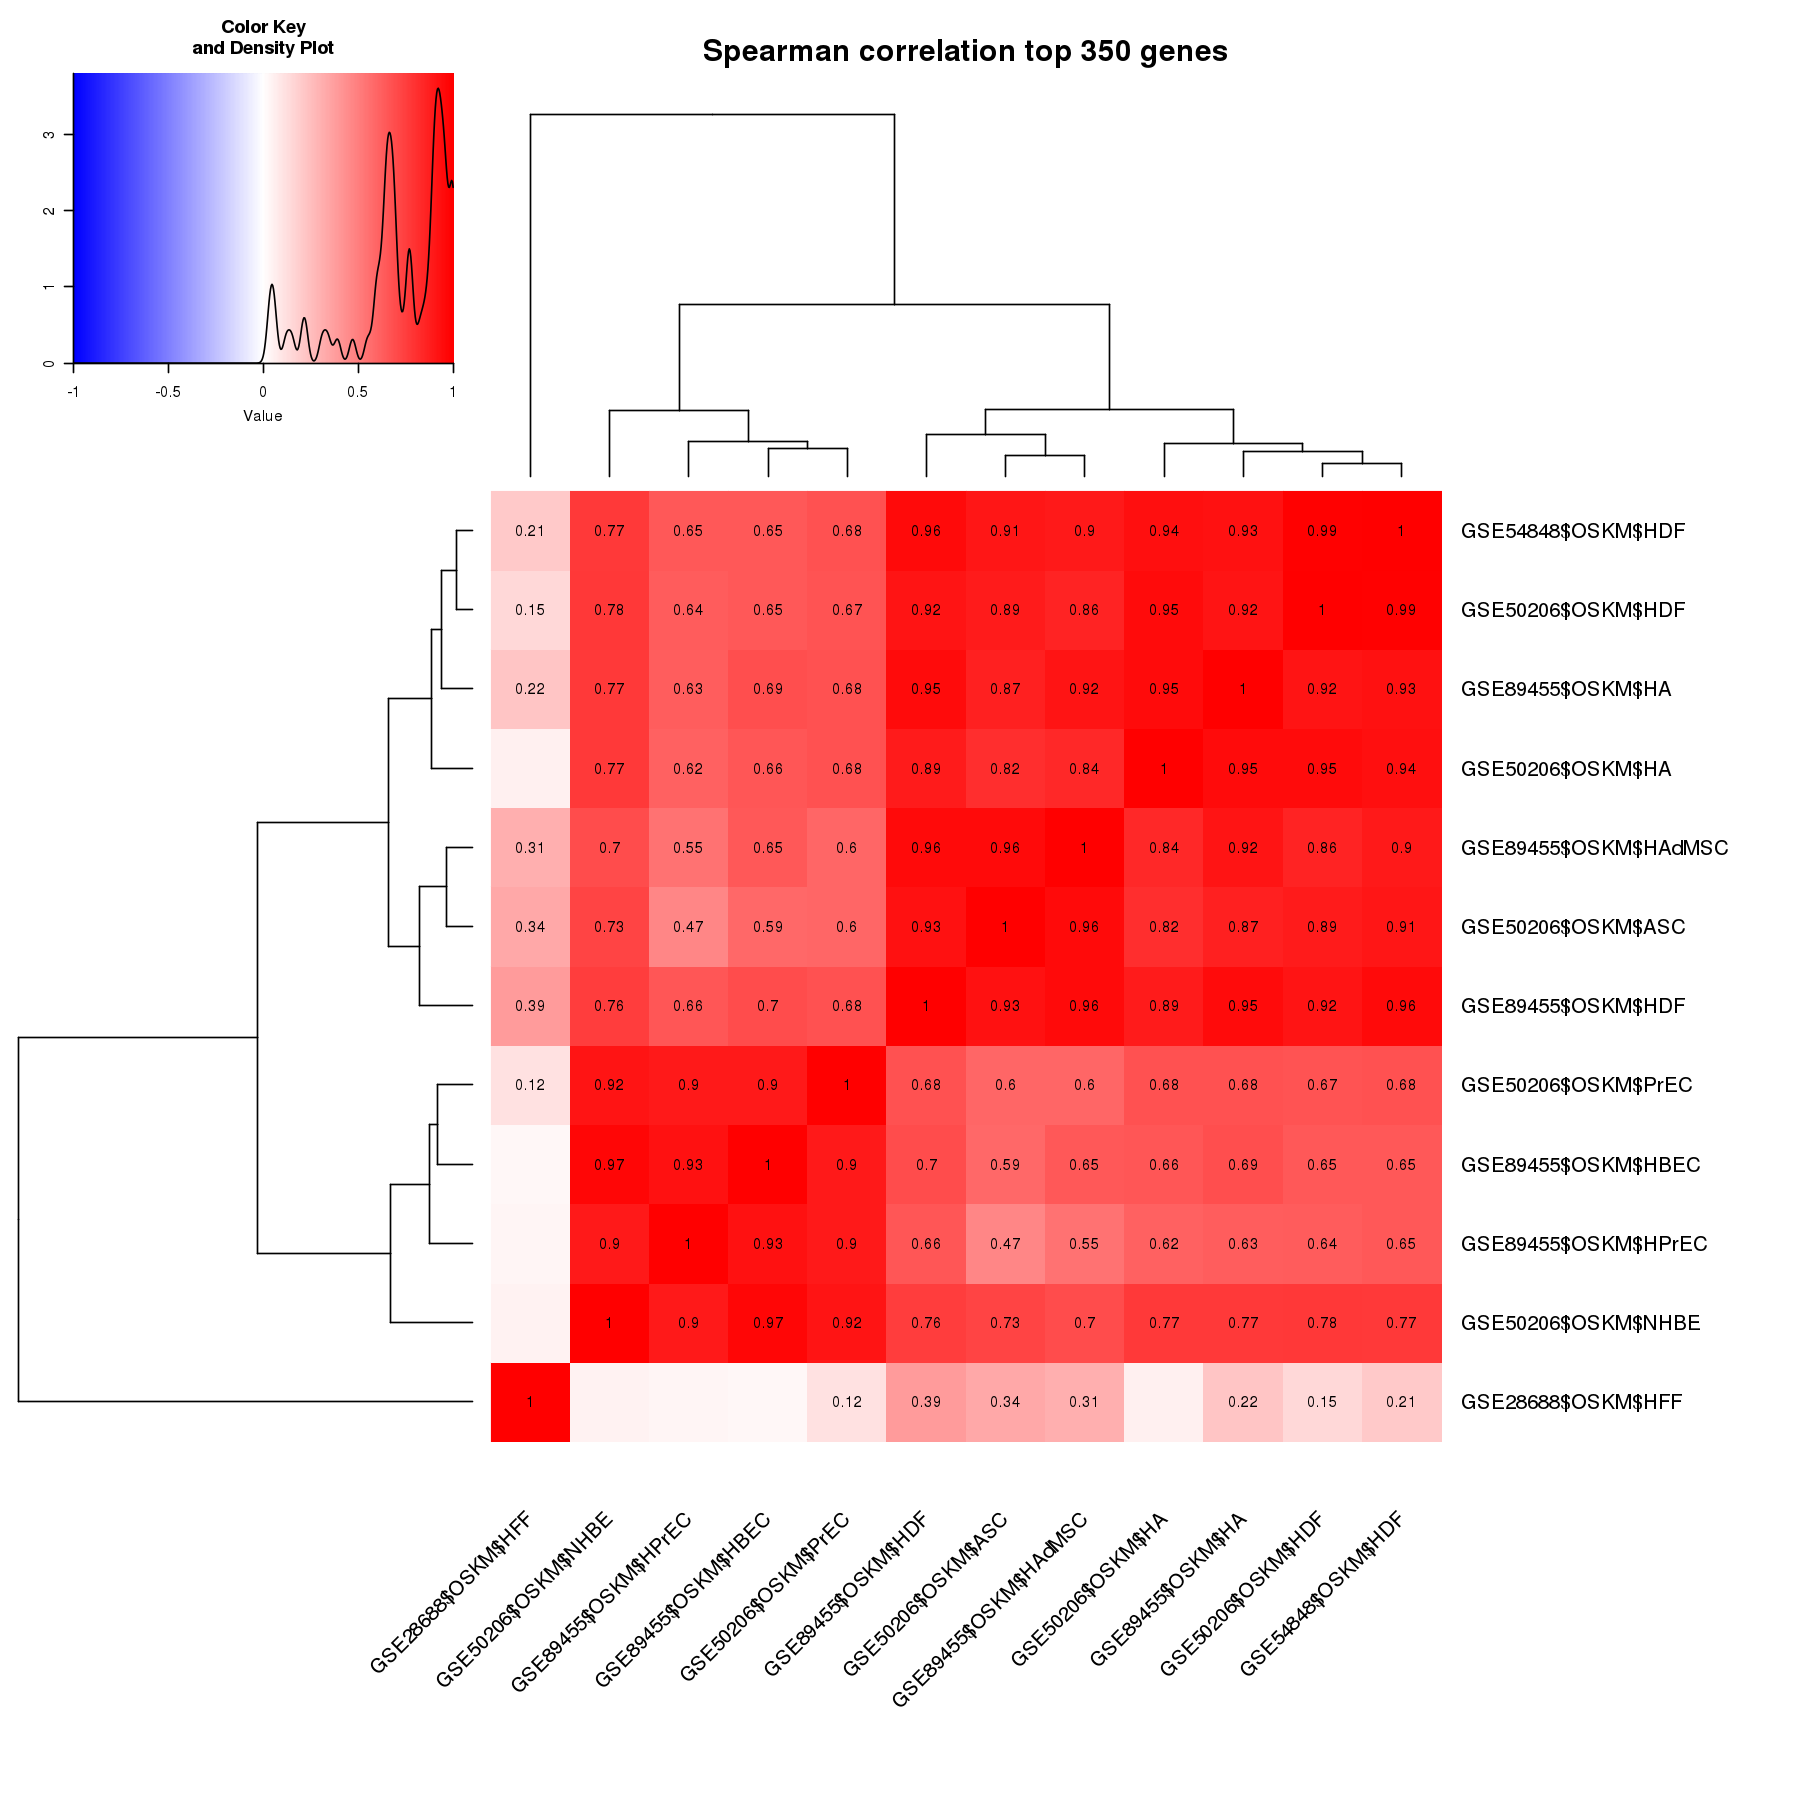

In [36]:
human_tmp <- datasets_list[names(ultrahuman)]
human_only <- corplot(human_tmp, type='pairwise_top', method='spearman', top=150,
                    title="Spearman correlation top 350 genes", plotw=15, ploth=15, value_size=0.9)

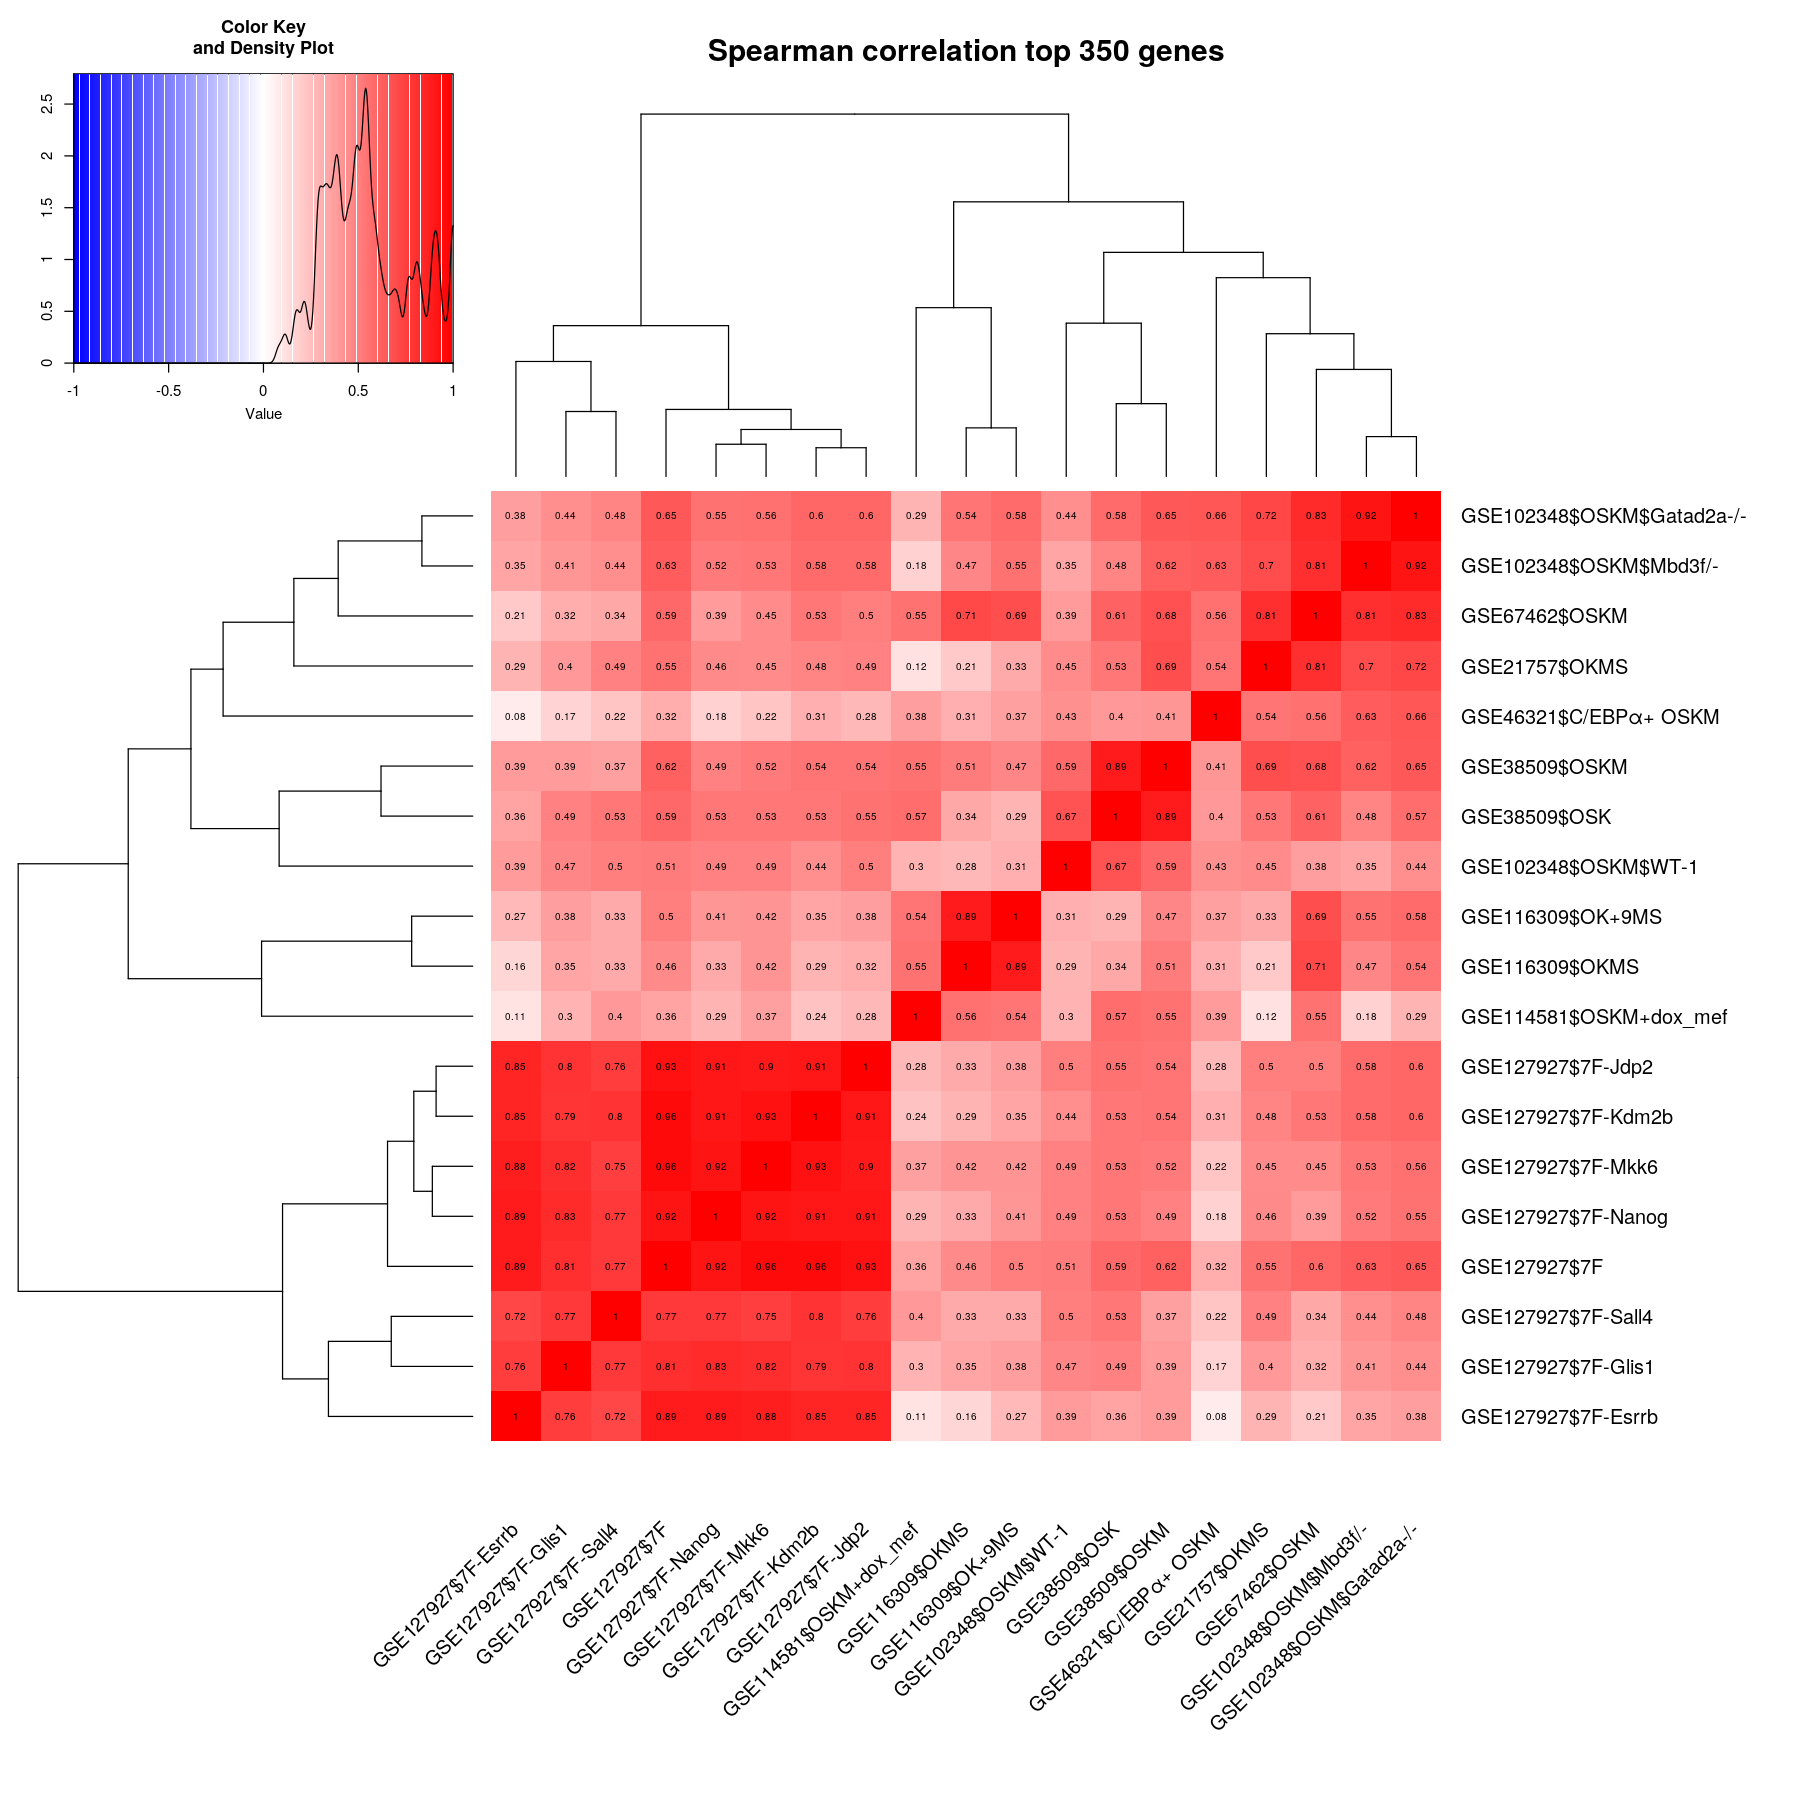

In [17]:
tmp <- datasets_list[c('GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
                                'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
                                'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
                                'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
                                'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
                                'GSE127927$7F-Sall4', 'GSE127927$7F', 
                                'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1')]

corres <- corplot(tmp, type='pairwise_top', method='spearman', top=350,
                    title="Spearman correlation top 350 genes", plotw=15, ploth=15, value_size=0.6)

In [24]:
mean(corres$cm)

[1] 0.5486427

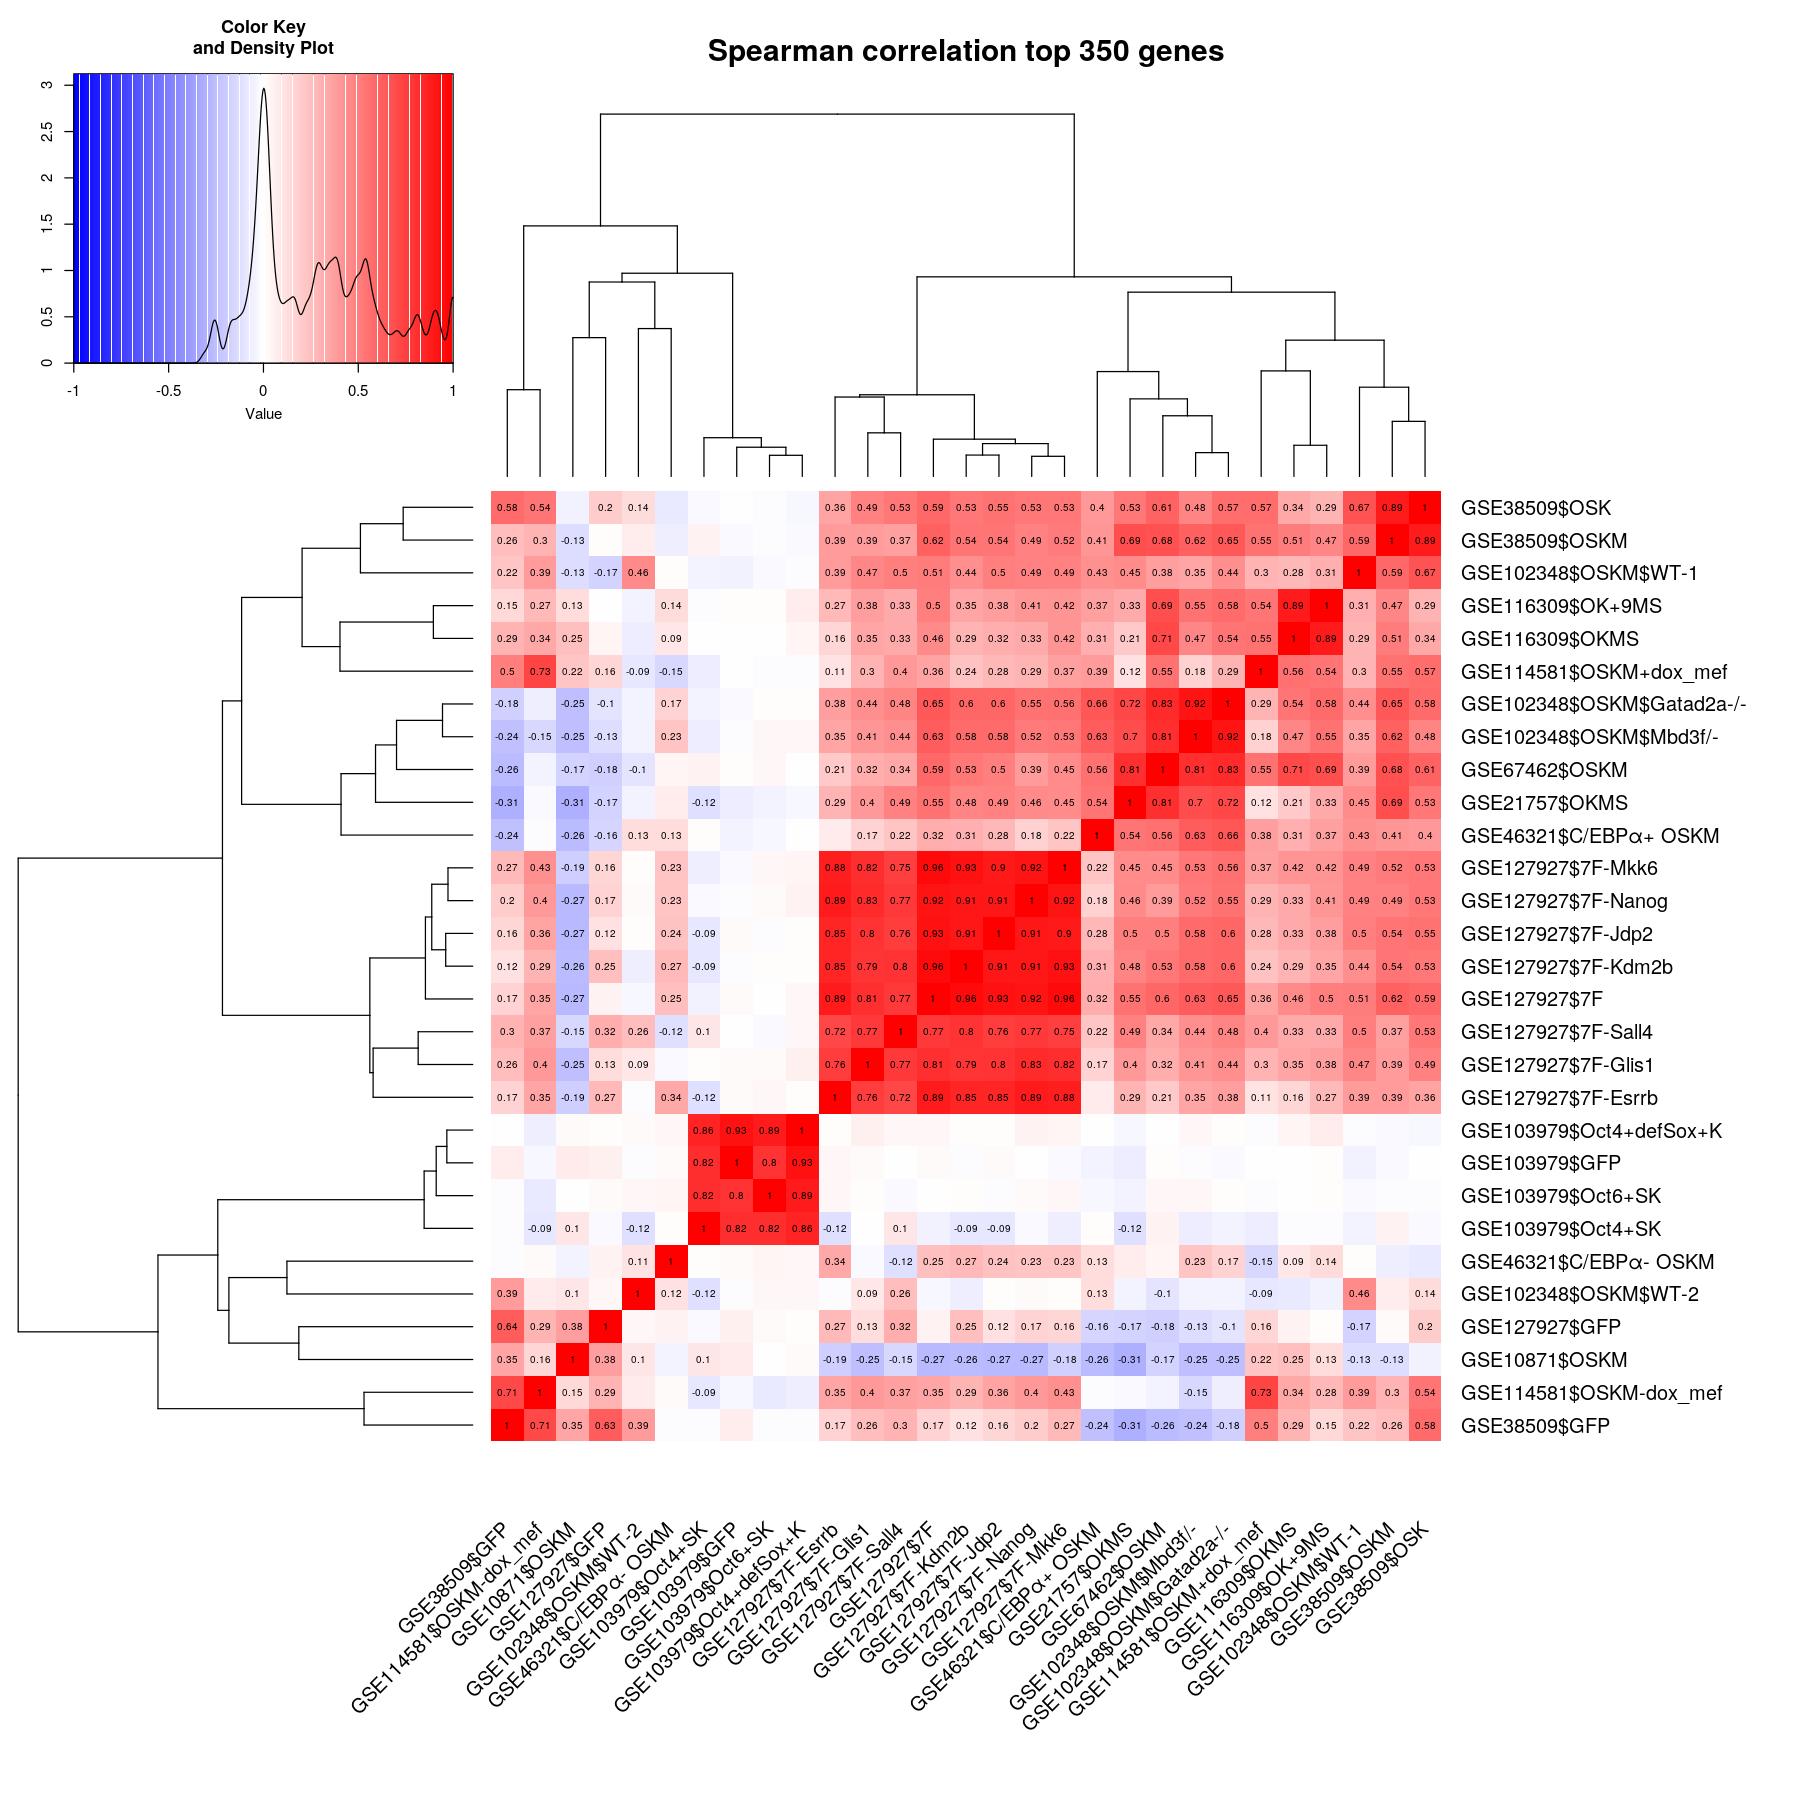

In [15]:
corres <- corplot(datasets_list, type='pairwise_top', method='spearman', top=350,
                    title="Spearman correlation top 350 genes", plotw=15, ploth=15, value_size=0.6)

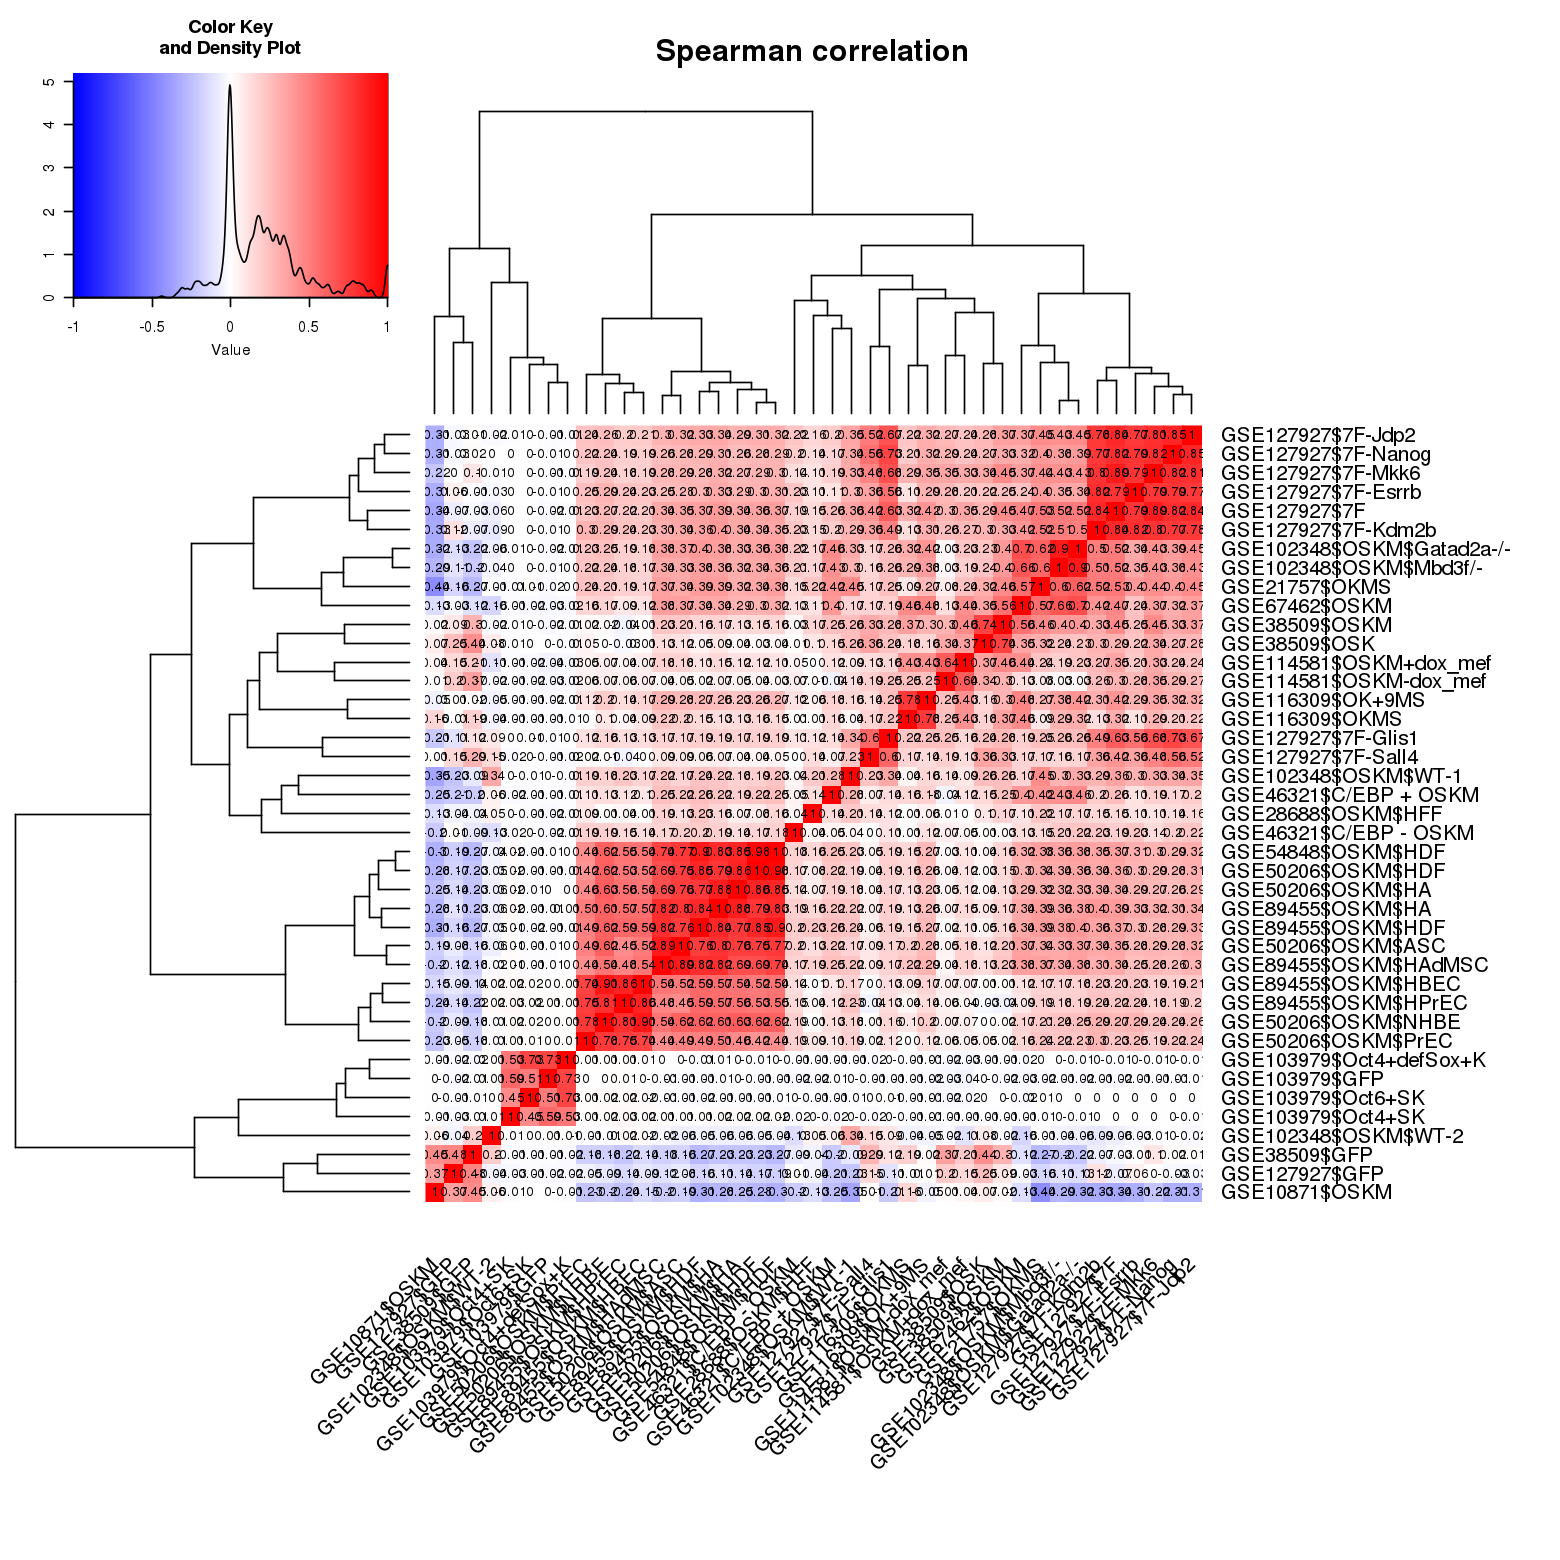

In [34]:
empty <- corplot(slopes, type='full_intersection', method='spearman')

# Correlation + Deming

## Search for number of top genes

In [39]:
#This script aggregates logFC from individual datasets into a single signature
#by using multiple Deming normalization and mixed-effect model
#####################################

#Summary of steps
#1. Idenitification of dataset pairs with significant correlations
#2. Normalization of datasets using Deming regression
#3. Aggregation of datasets into a single signature using mixed-effect model
#####################################
function_path <- "./Functions for signature aggregation/"

#1. Idenitification of dataset pairs with significant correlations
#To run Deming normalization, we need a subset of dataset pairs with significant correlations
#as well as the optimal number of genes, which should be used for normalization
source(paste(function_path, "FUN.Calculate_paired_correlation.R", sep=""))
source(paste(function_path, "FUN.Make_matrix_from_list.R",sep=""))
correlation_FDR_threshold <- 0.0001
correlation_coef_threshold <- 0.55

In [40]:
#a) Download list with the output for each dataset
#datasets_list <- dget("Signatures_together_mouse_NEW.R")
names(datasets_list)
#logFCs, SEs and P-values for each dataset should be specified 
#in columns "logFC", "SE" and "P.Value" respectively

[1] "GSE89455$OSKM$HDF"    "GSE89455$OSKM$HAdMSC" "GSE89455$OSKM$HA"    
 [4] "GSE89455$OSKM$HBEC"   "GSE89455$OSKM$HPrEC"  "GSE50206$OSKM$HDF"   
 [7] "GSE50206$OSKM$ASC"    "GSE50206$OSKM$HA"     "GSE50206$OSKM$NHBE"  
[10] "GSE50206$OSKM$PrEC"   "GSE54848$OSKM$HDF"

In [41]:
#####
#here we choose datasets

#mouse signature
# datasets_list <- datasets_list[c('GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
#                                 'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
#                                 'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
#                                 'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
#                                 'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
#                                 'GSE127927$7F-Sall4', 'GSE127927$7F', 
#                                 'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1')]
#human signature
datasets_list <- datasets_list[c('GSE89455$OSKM$HDF', 'GSE89455$OSKM$HAdMSC', 'GSE89455$OSKM$HA', 
                                'GSE89455$OSKM$HBEC','GSE89455$OSKM$HPrEC','GSE50206$OSKM$HDF',
                                'GSE50206$OSKM$ASC','GSE50206$OSKM$HA','GSE50206$OSKM$NHBE',
                                'GSE50206$OSKM$PrEC','GSE54848$OSKM$HDF')]

#merged signature:: 30 datasets
# datasets_list <- datasets_list[c(
#                               c('GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
#                                 'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
#                                 'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
#                                 'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
#                                 'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
#                                 'GSE127927$7F-Sall4', 'GSE127927$7F', 
#                                 'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1'),
#                               c('GSE89455$OSKM$HDF', 'GSE89455$OSKM$HAdMSC', 'GSE89455$OSKM$HA', 
#                                 'GSE89455$OSKM$HBEC','GSE89455$OSKM$HPrEC','GSE50206$OSKM$HDF',
#                                 'GSE50206$OSKM$ASC','GSE50206$OSKM$HA','GSE50206$OSKM$NHBE',
#                                 'GSE50206$OSKM$PrEC','GSE54848$OSKM$HDF'))]

#datasets_list <- datasets_list[c('GSE38509$GFP', 'GSE114581$OSKM-dox_mef', 'GSE127927$GFP')]
#####

In [42]:
#b) Run a cycle with different gene numbers to find the best threshold
#(which maximizes the number of significant correlations)
source(paste(function_path, "FUN.Calculate_paired_correlation_from_matrix.R", sep=""))
source(paste(function_path, "FUN.Correlation_loop_top_genes.R", sep=""))
runs <- seq(50, 2000, by=100)
#runs <- seq(5, 90, by=5)

[1] "Optimal number of top genes:"
[1] 1350


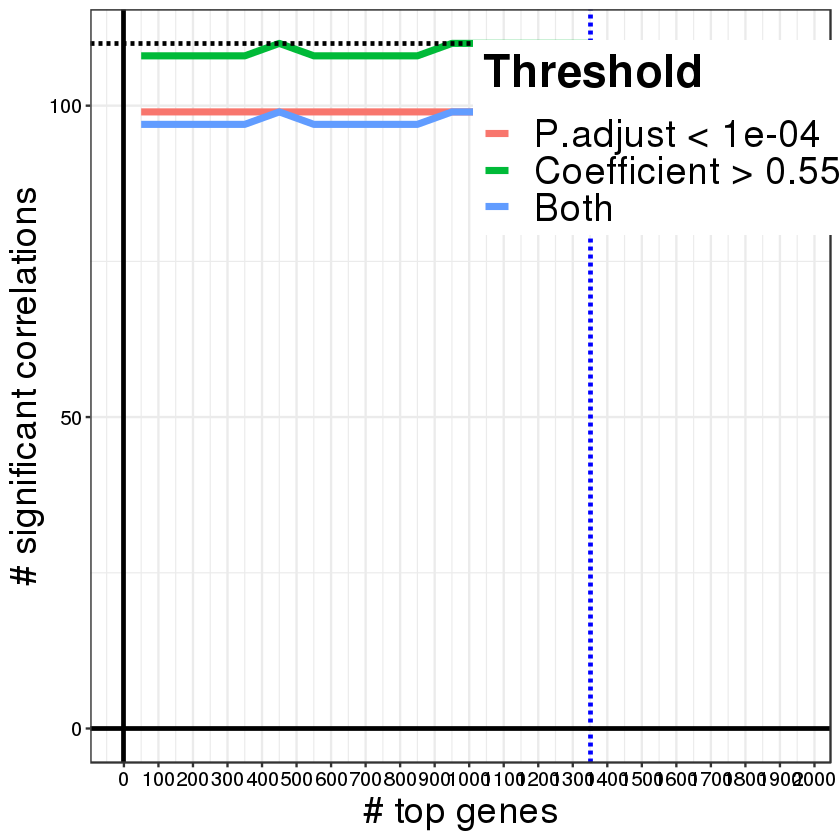

In [43]:
logFC_table <- make_matrix_from_list(datasets_list,"logFC") 
pvalue_table <- make_matrix_from_list(datasets_list,"P.Value")
correlation_output <- Correlation_loop_top_genes(logFC_table,
                                                 pvalue_table,
                                                 method = "spearman",
                                                 vector_number_genes = runs,
                                                 function_path = function_path,
                                                 FDR_thresh=correlation_FDR_threshold,
                                                 corr_thresh=correlation_coef_threshold,
                                                 samplenames=colnames(logFC_table))

#correlation_output$Number_top_genes 
#Optimal number of genes for correlation analysis

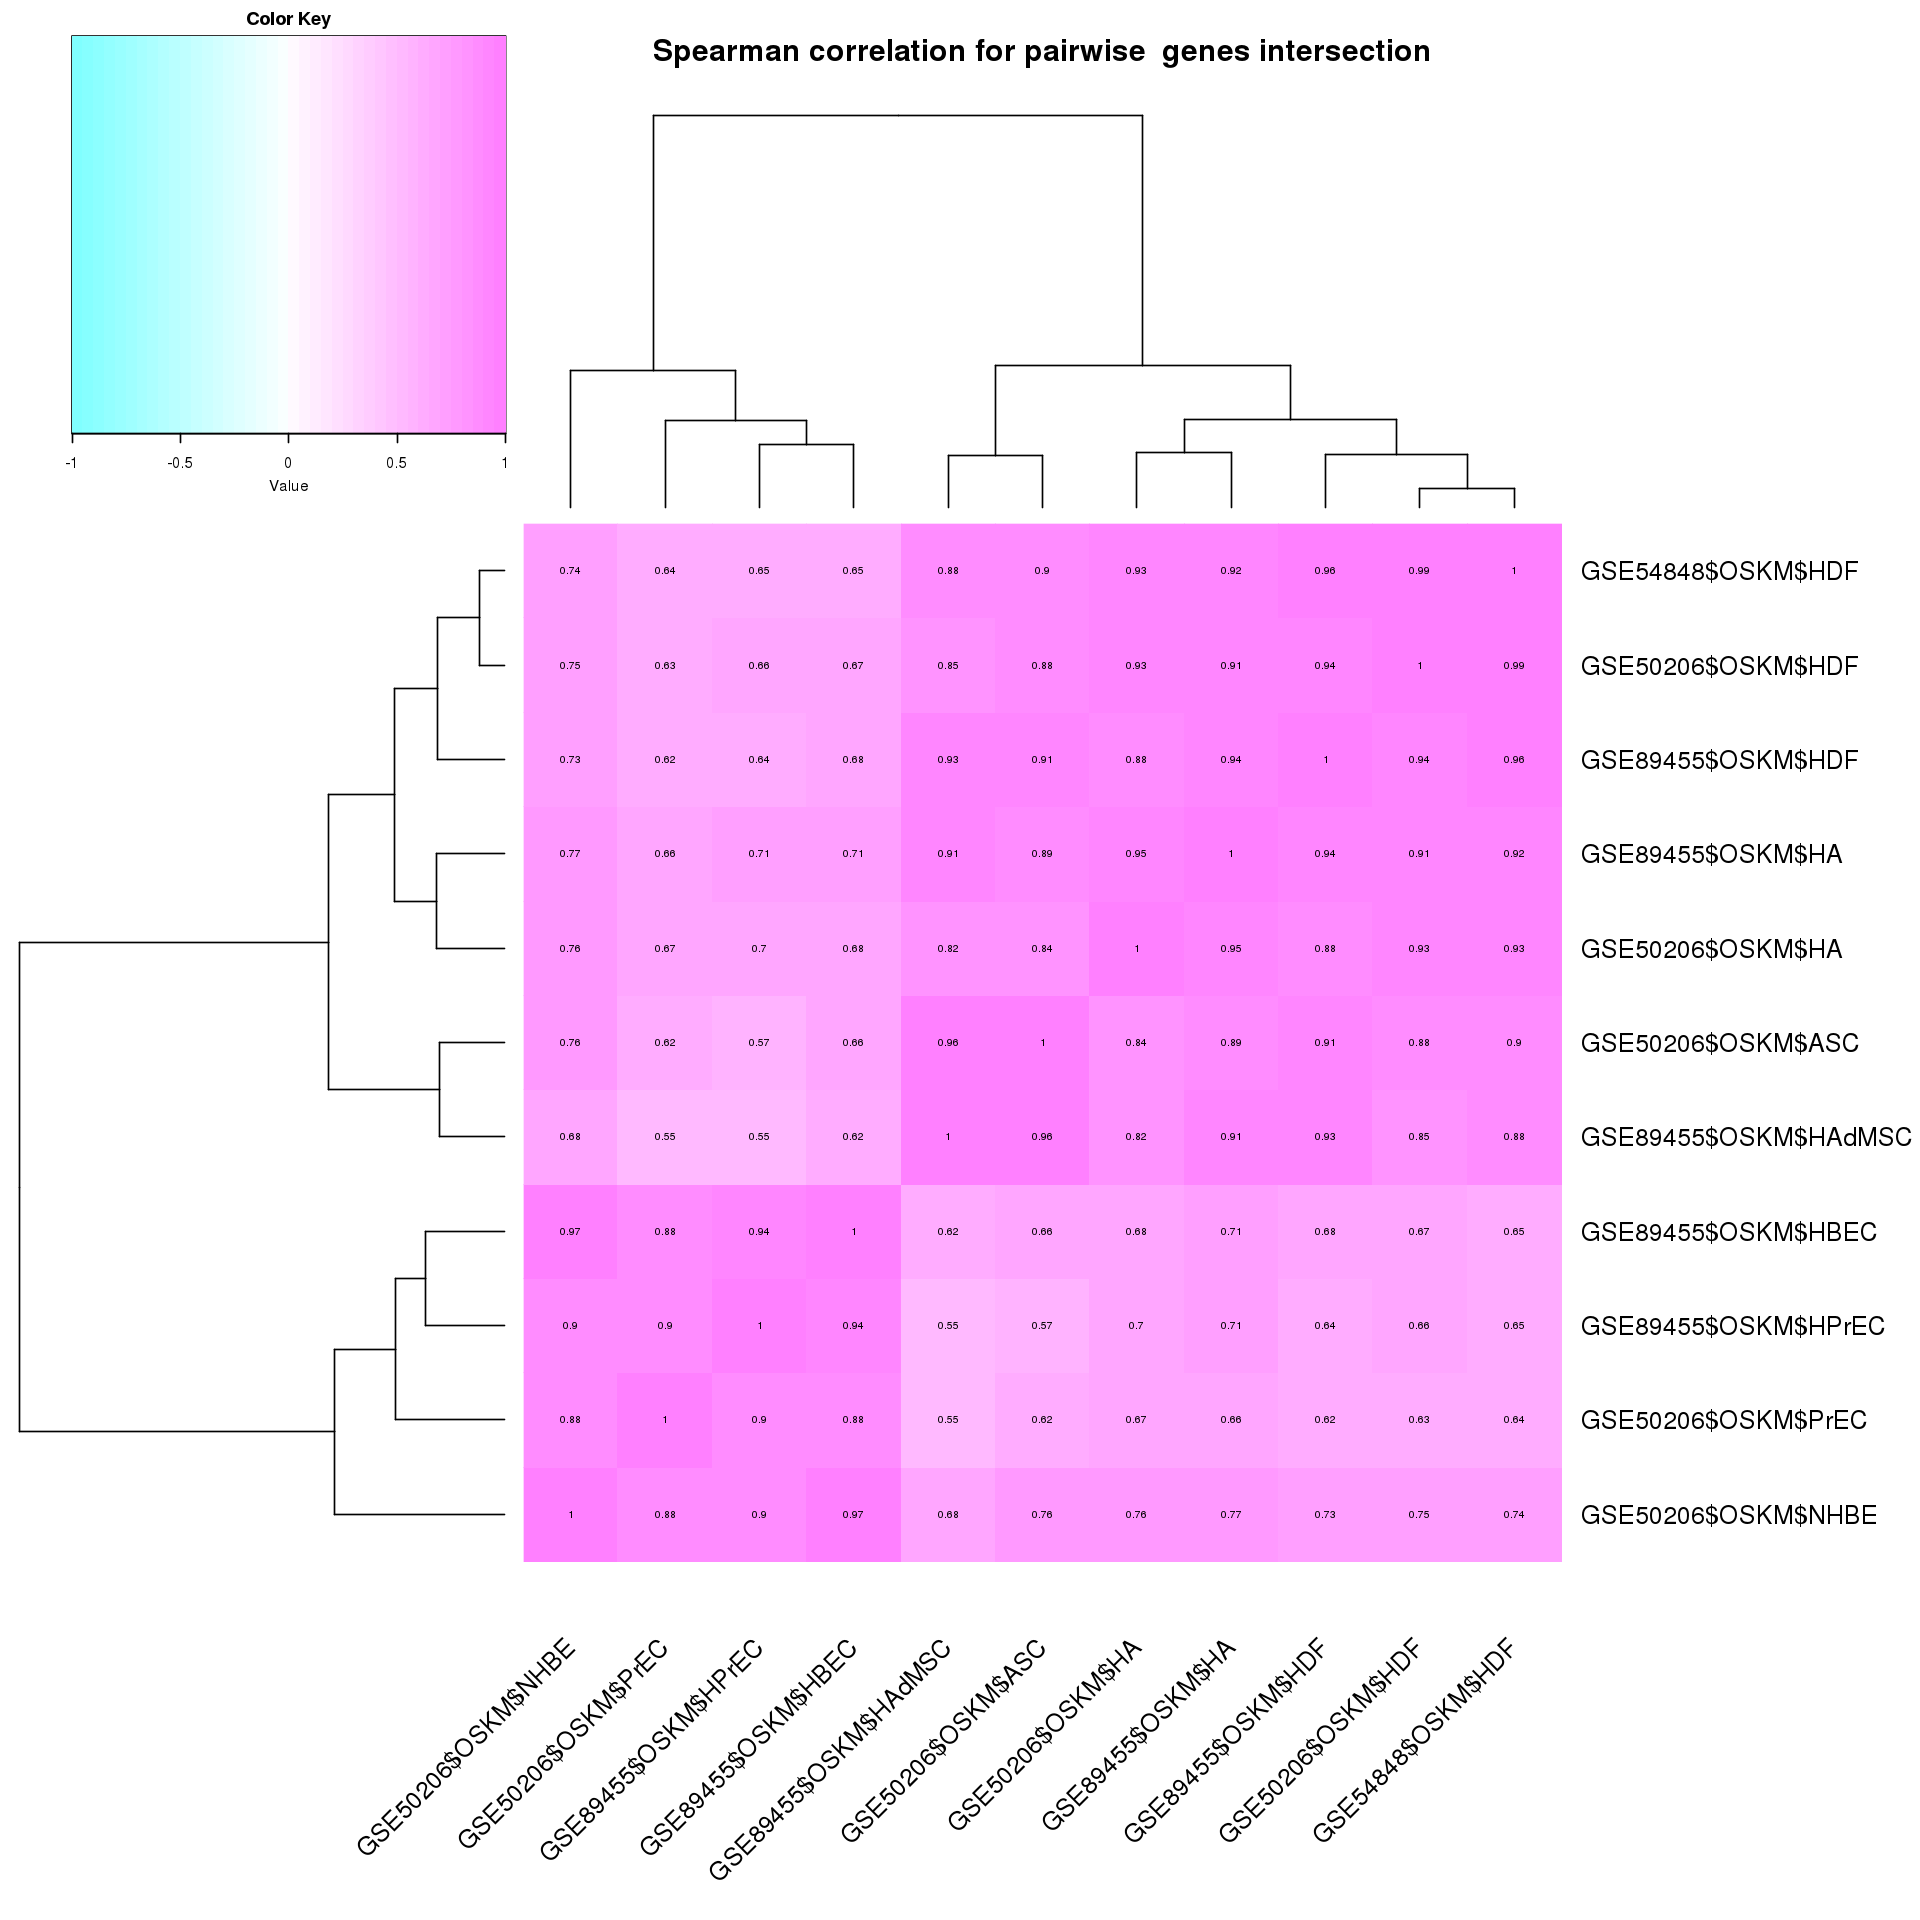

In [44]:
cm <- round(correlation_output$Optimal$corr, 2)
#plotting
options(repr.plot.width = 16, repr.plot.height = 16)
par(mar=c(7,4,4,2)+0.1)
heatmap.2(cm, cellnote=cm, notecex=0.6, main="Spearman correlation for pairwise  genes intersection",
          density.info="none", notecol="black", srtCol=45, trace="none", 
          cexRow=1.5, cexCol=1.5, margins=c(18,18), 
          col= cm.colors(length(seq(-1,1,0.05))-1), breaks=seq(-1,1,0.05))

## Deming Normalization

In [45]:
#2. Normalization of datasets using Deming regression
#Run Deming regression for pairs with significant correlations (optimization of coefficients)
source(paste(function_path,"FUN.Deming_minimizer.r",sep=""))
source(paste(function_path,"FUN.Multiple_Deming_normalization.R",sep=""))

In [46]:
names(datasets_list)

[1] "GSE89455$OSKM$HDF"    "GSE89455$OSKM$HAdMSC" "GSE89455$OSKM$HA"    
 [4] "GSE89455$OSKM$HBEC"   "GSE89455$OSKM$HPrEC"  "GSE50206$OSKM$HDF"   
 [7] "GSE50206$OSKM$ASC"    "GSE50206$OSKM$HA"     "GSE50206$OSKM$NHBE"  
[10] "GSE50206$OSKM$PrEC"   "GSE54848$OSKM$HDF"

In [18]:
# sublist <- datasets_list[c('GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
#                             'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
#                             'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
#                             'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 'GSE127927$7F-Kdm2b',
#                             'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 'GSE127927$7F-Sall4', 'GSE127927$7F')]

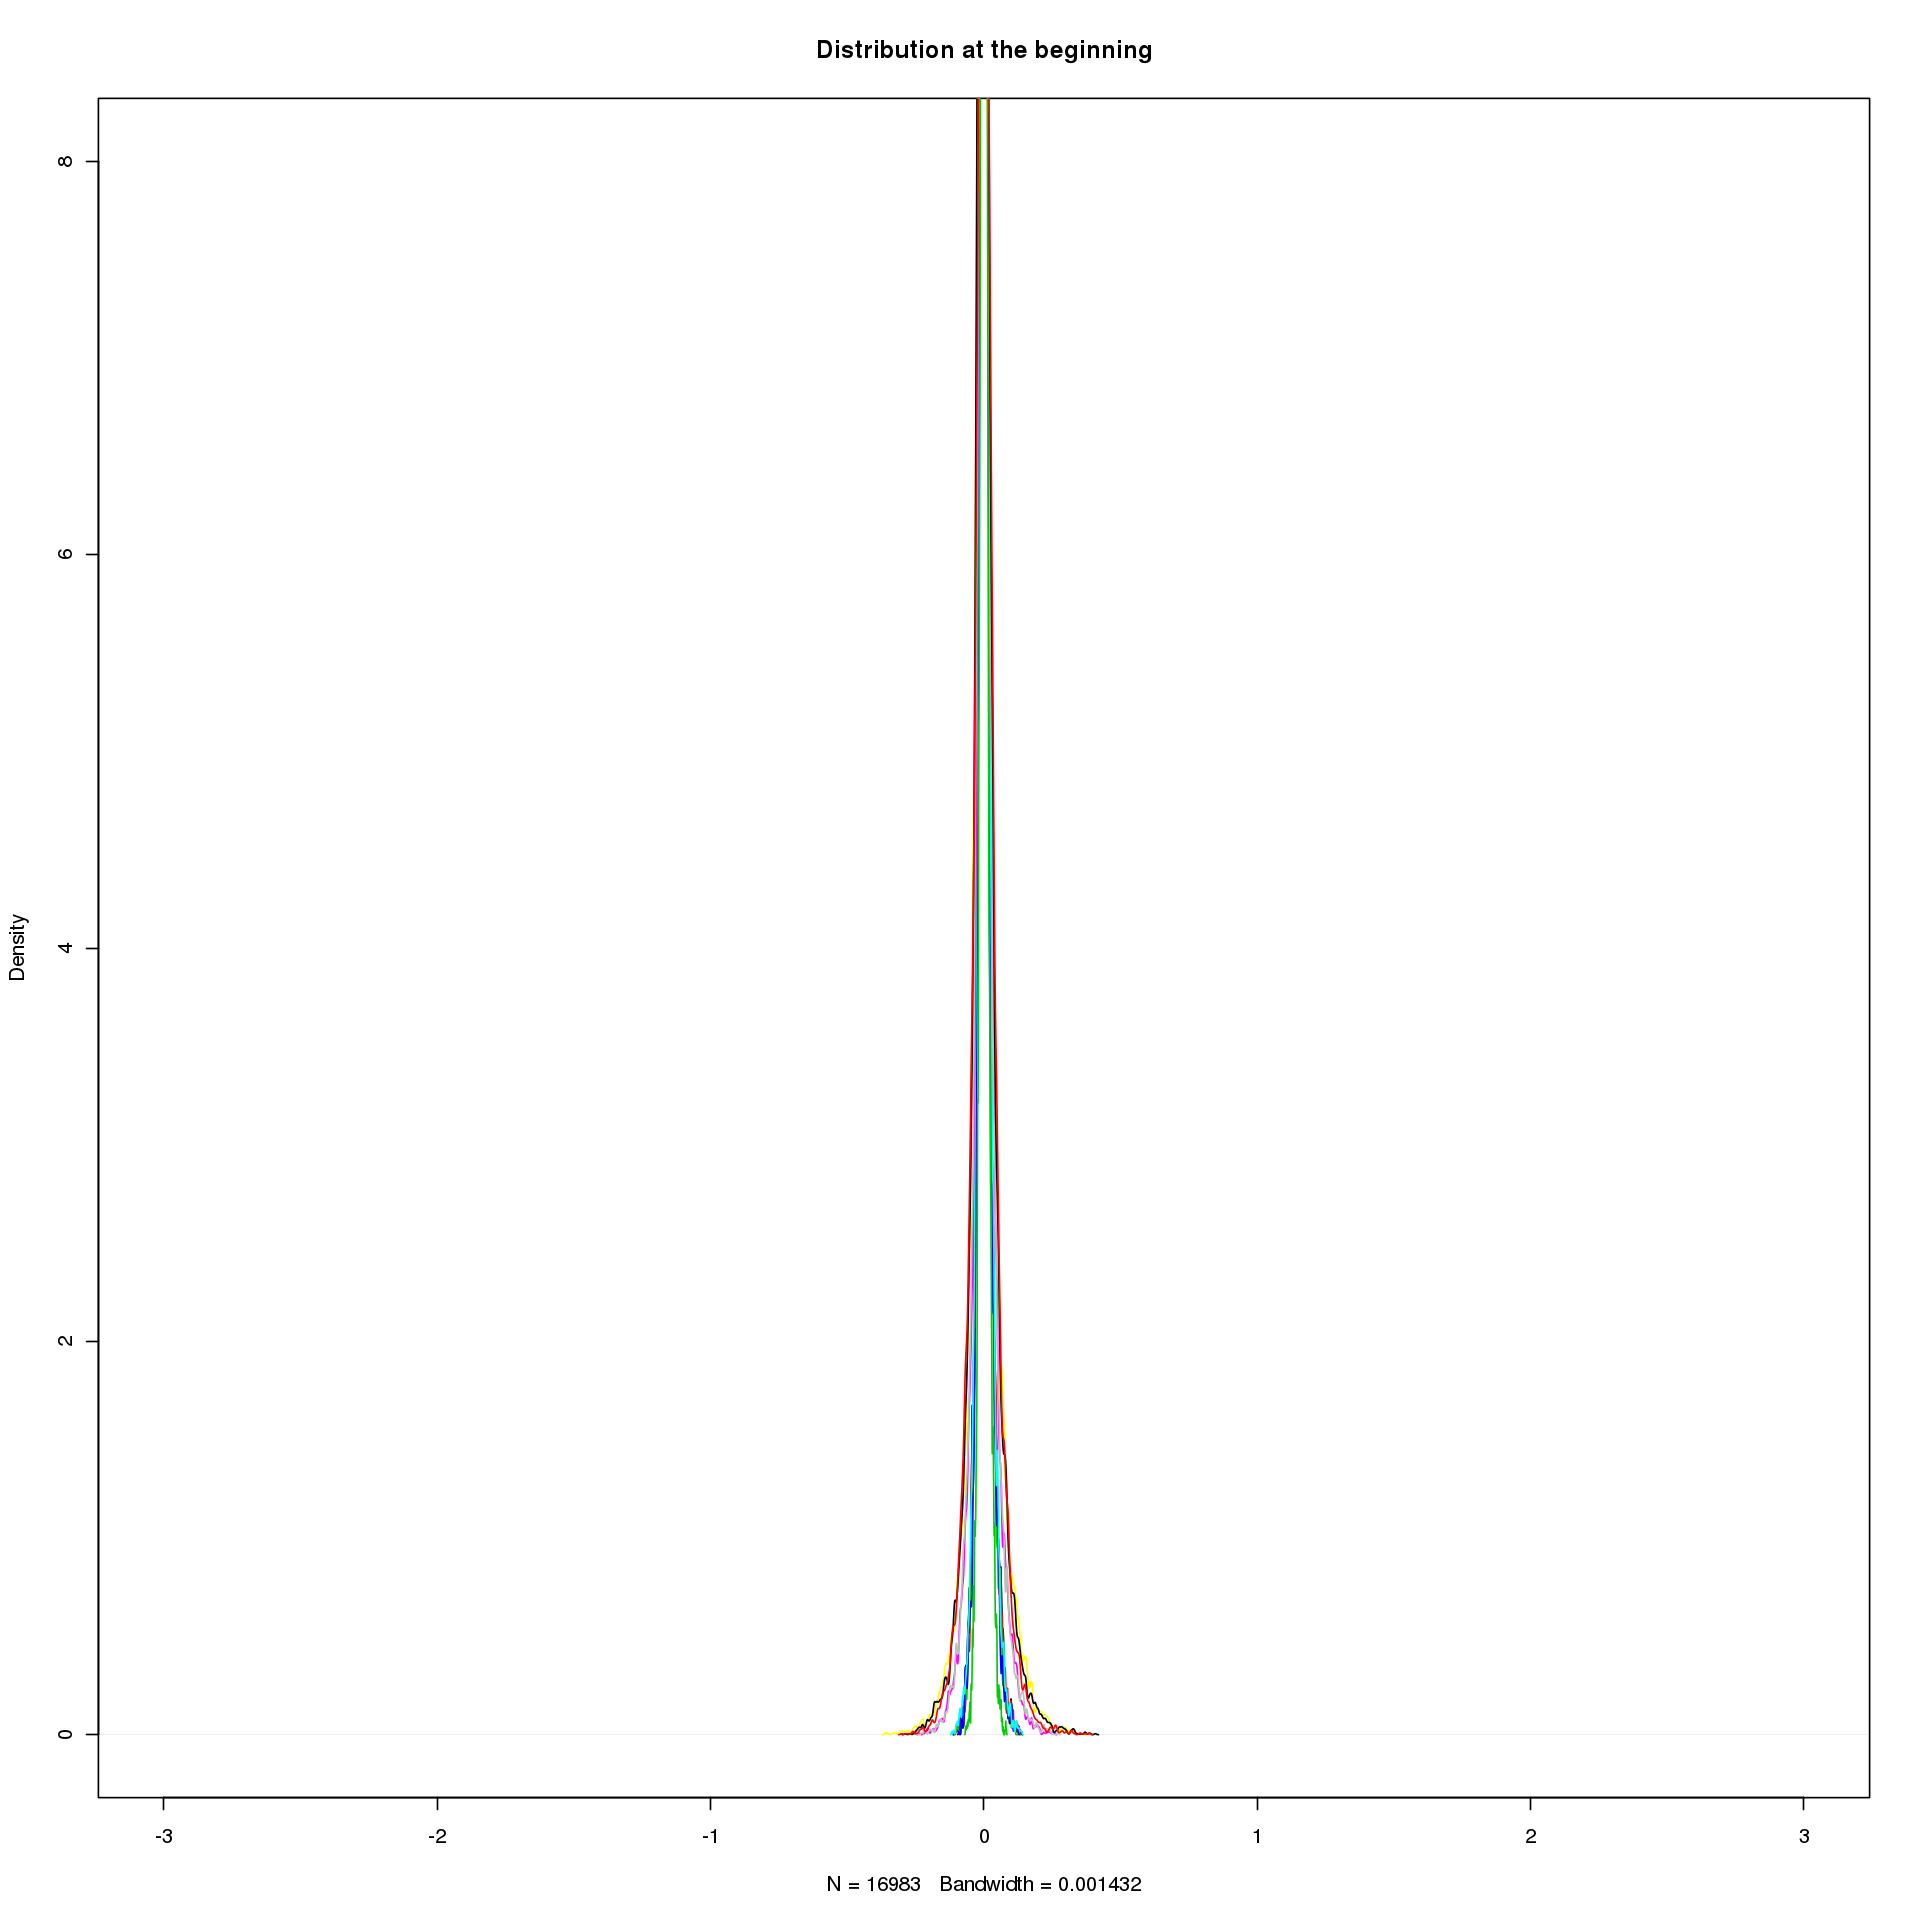

[1] "Starting with coefficient threshold:"
[1] 1
[1] "Iteration: 1"
Time difference of 41.24924 secs
[1] "Iteration: 2"
Time difference of 1.347326 mins
[1] "Starting with coefficient threshold:"
[1] 2
[1] "Iteration: 1"
Time difference of 1.09013 mins
[1] "Iteration: 2"
Time difference of 57.51087 secs


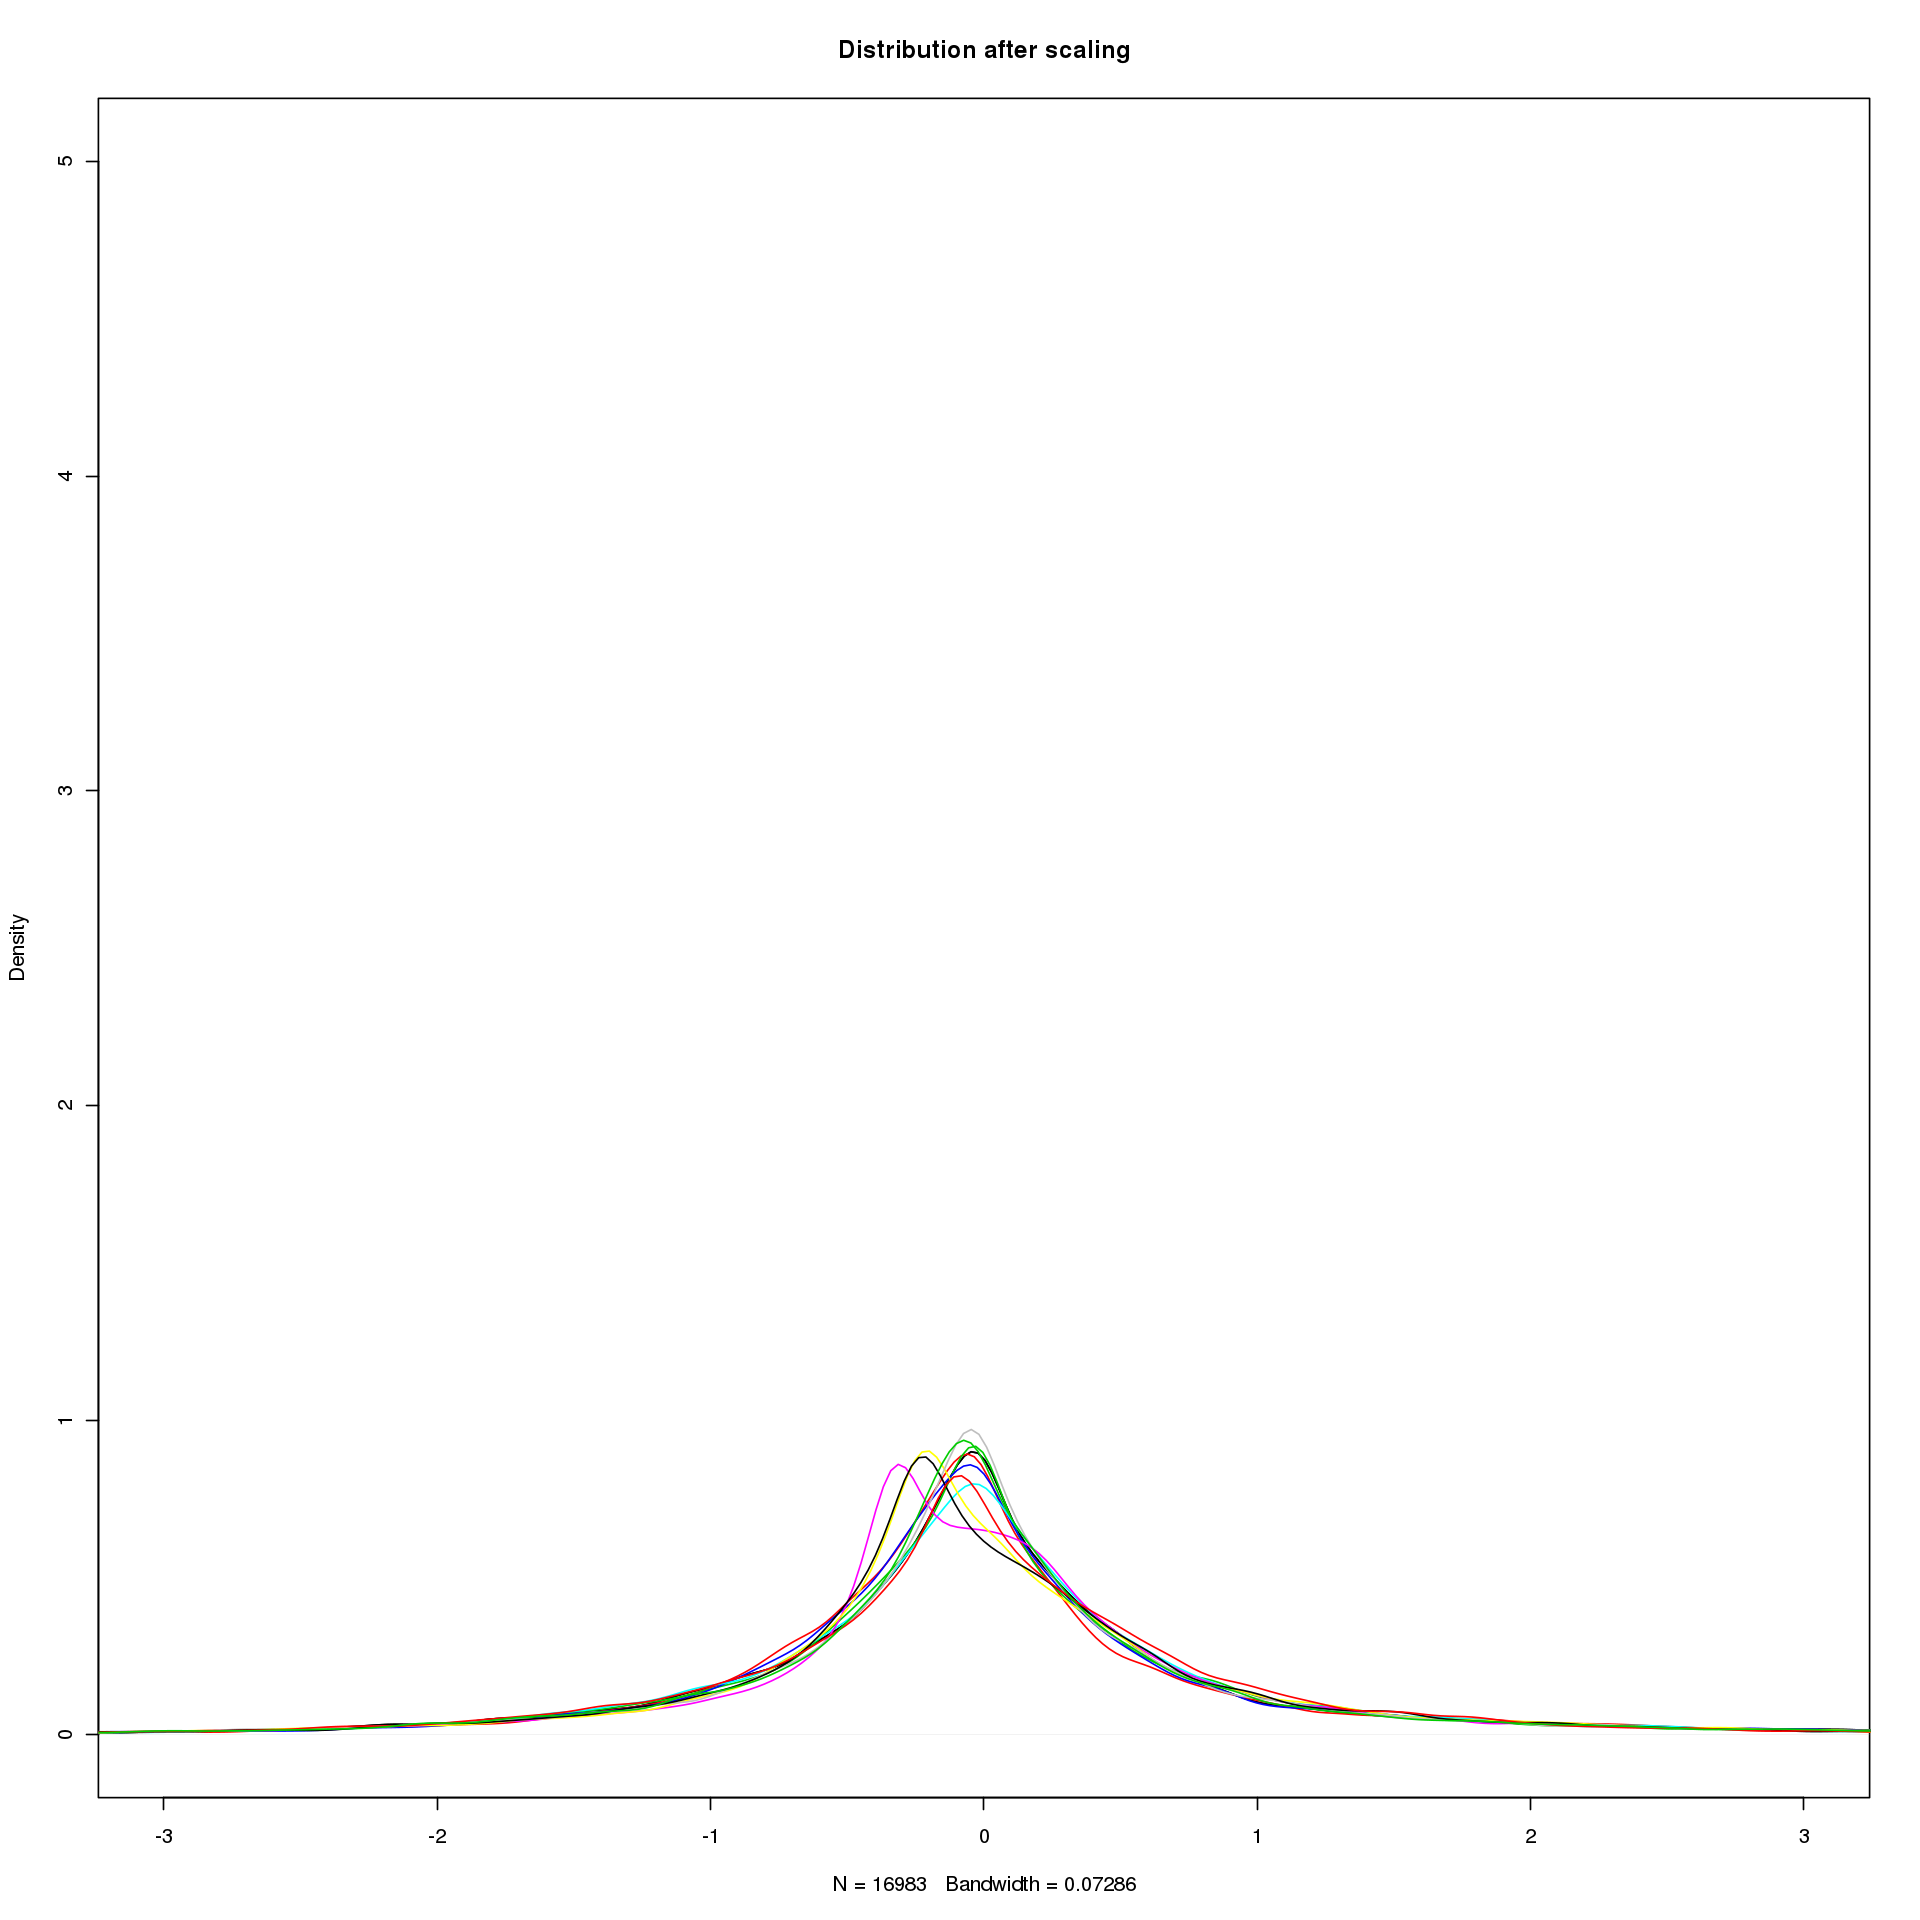

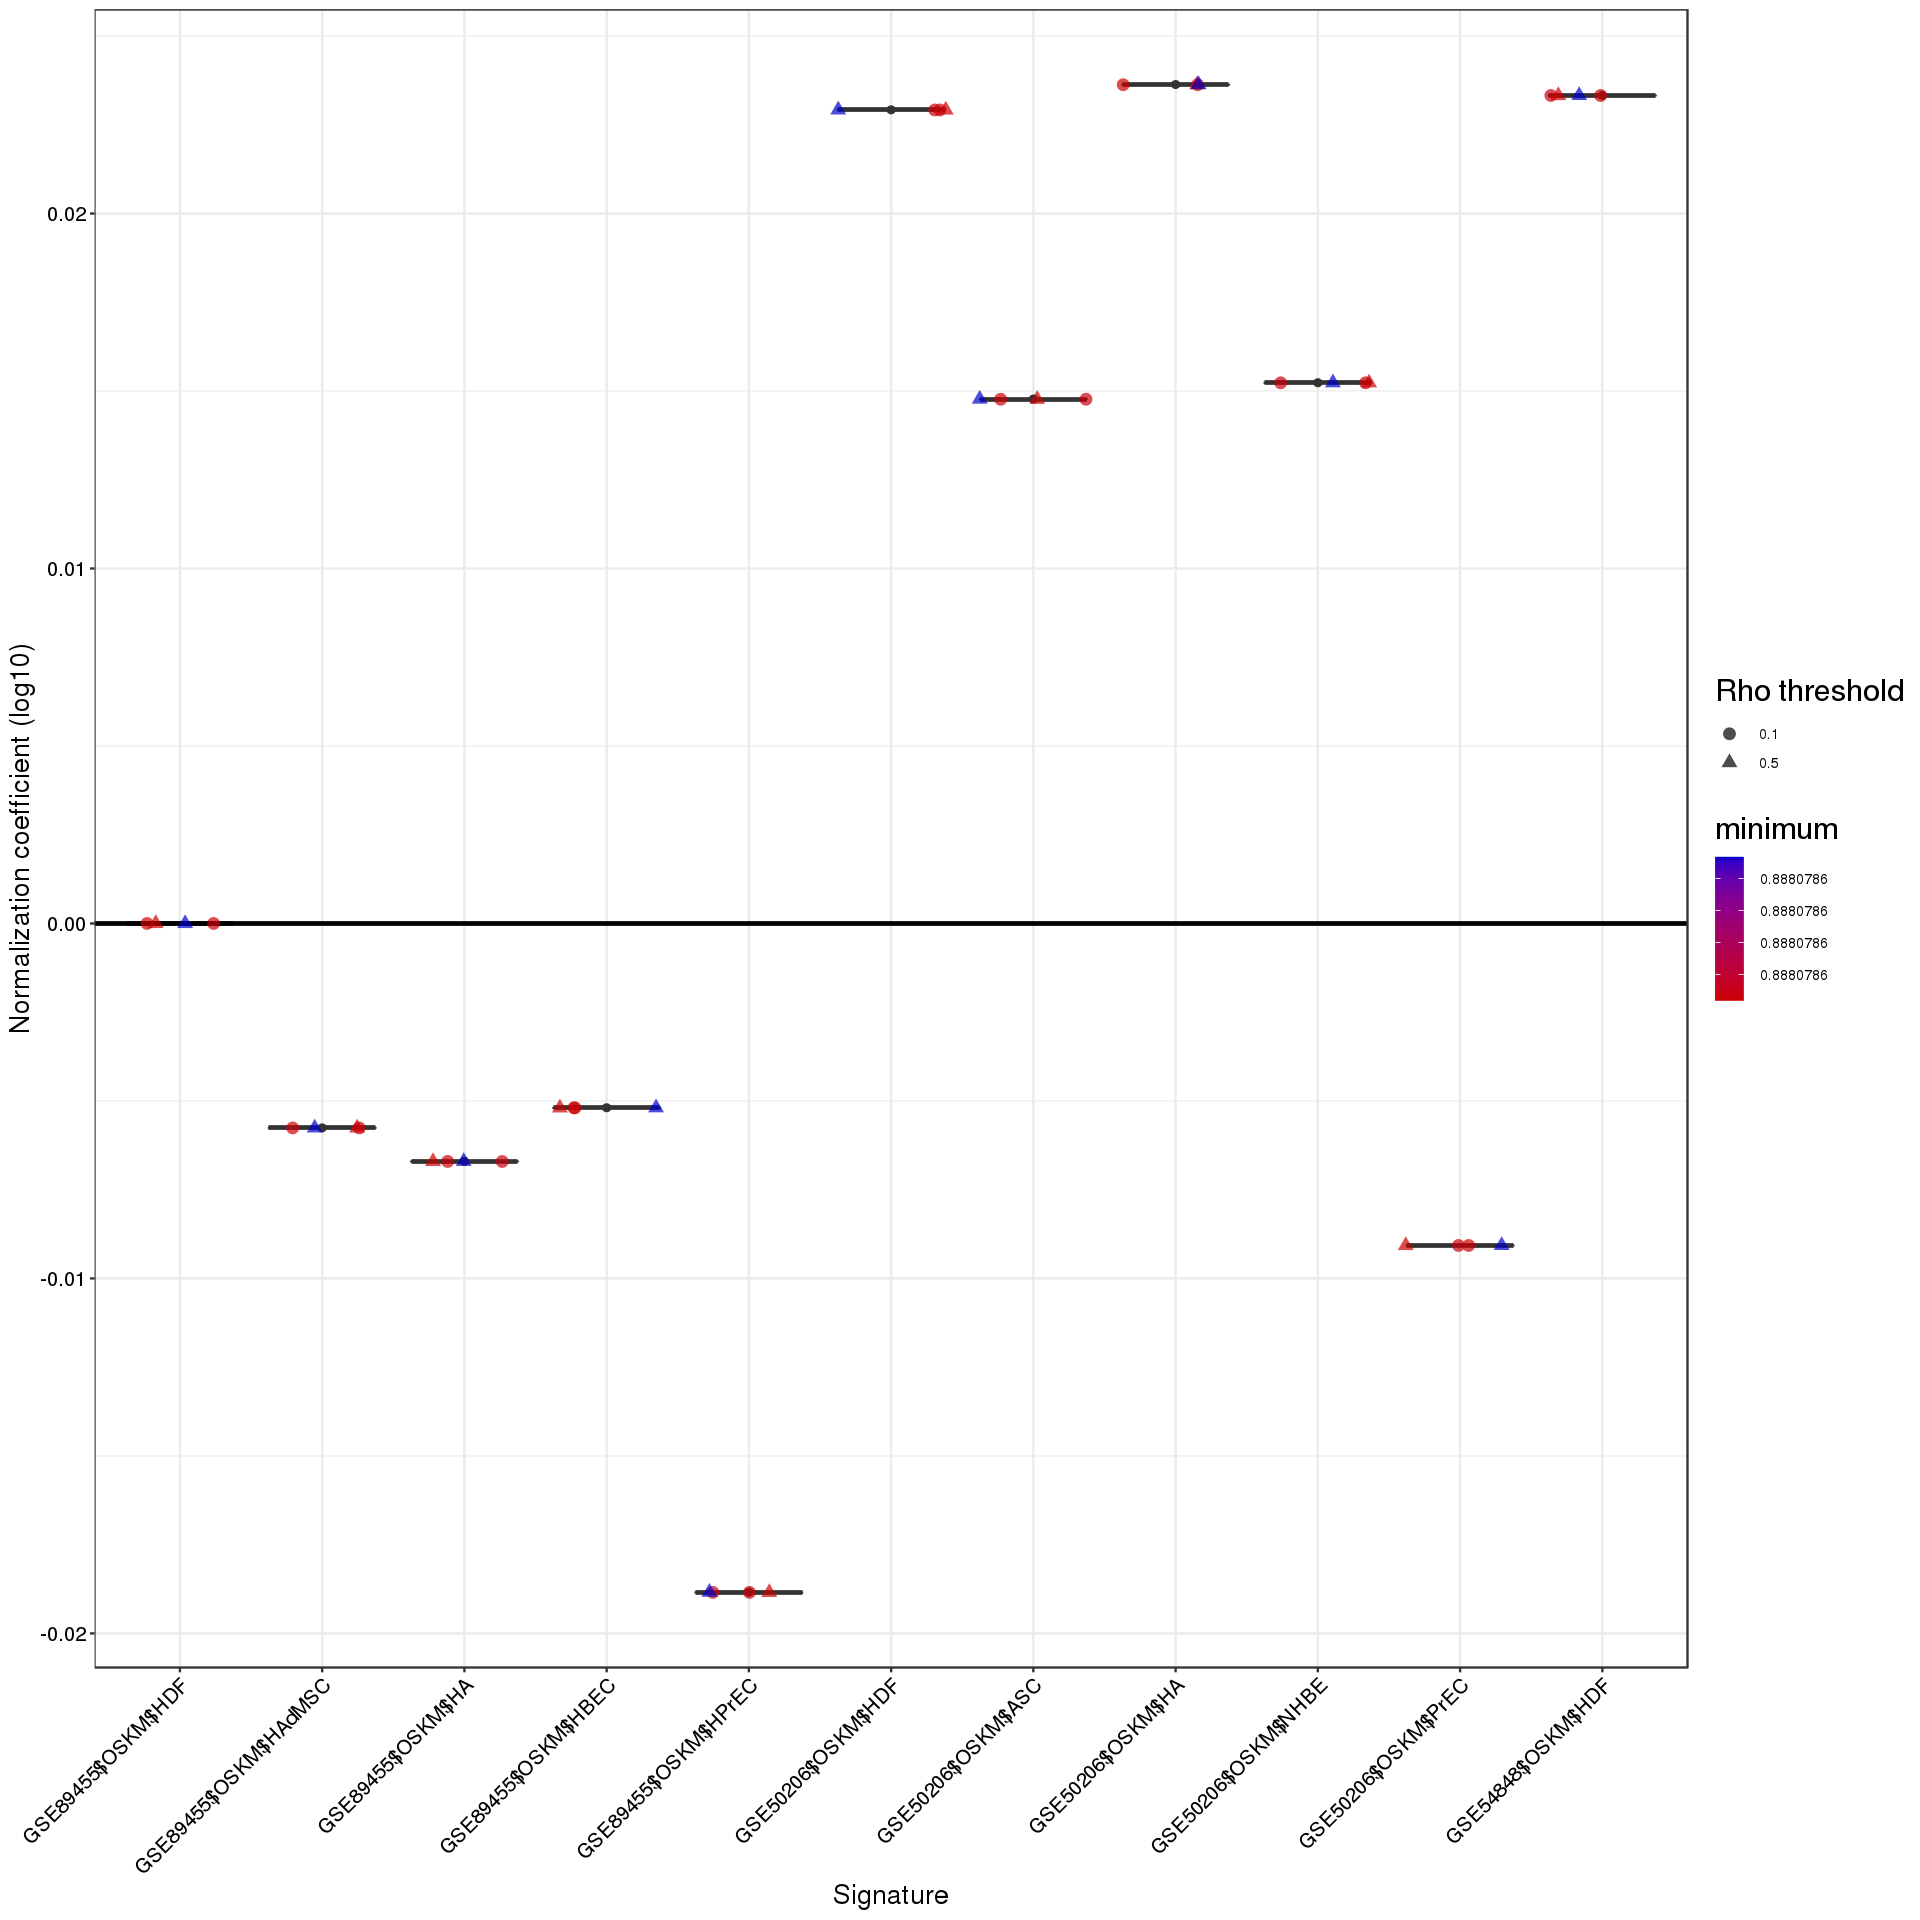

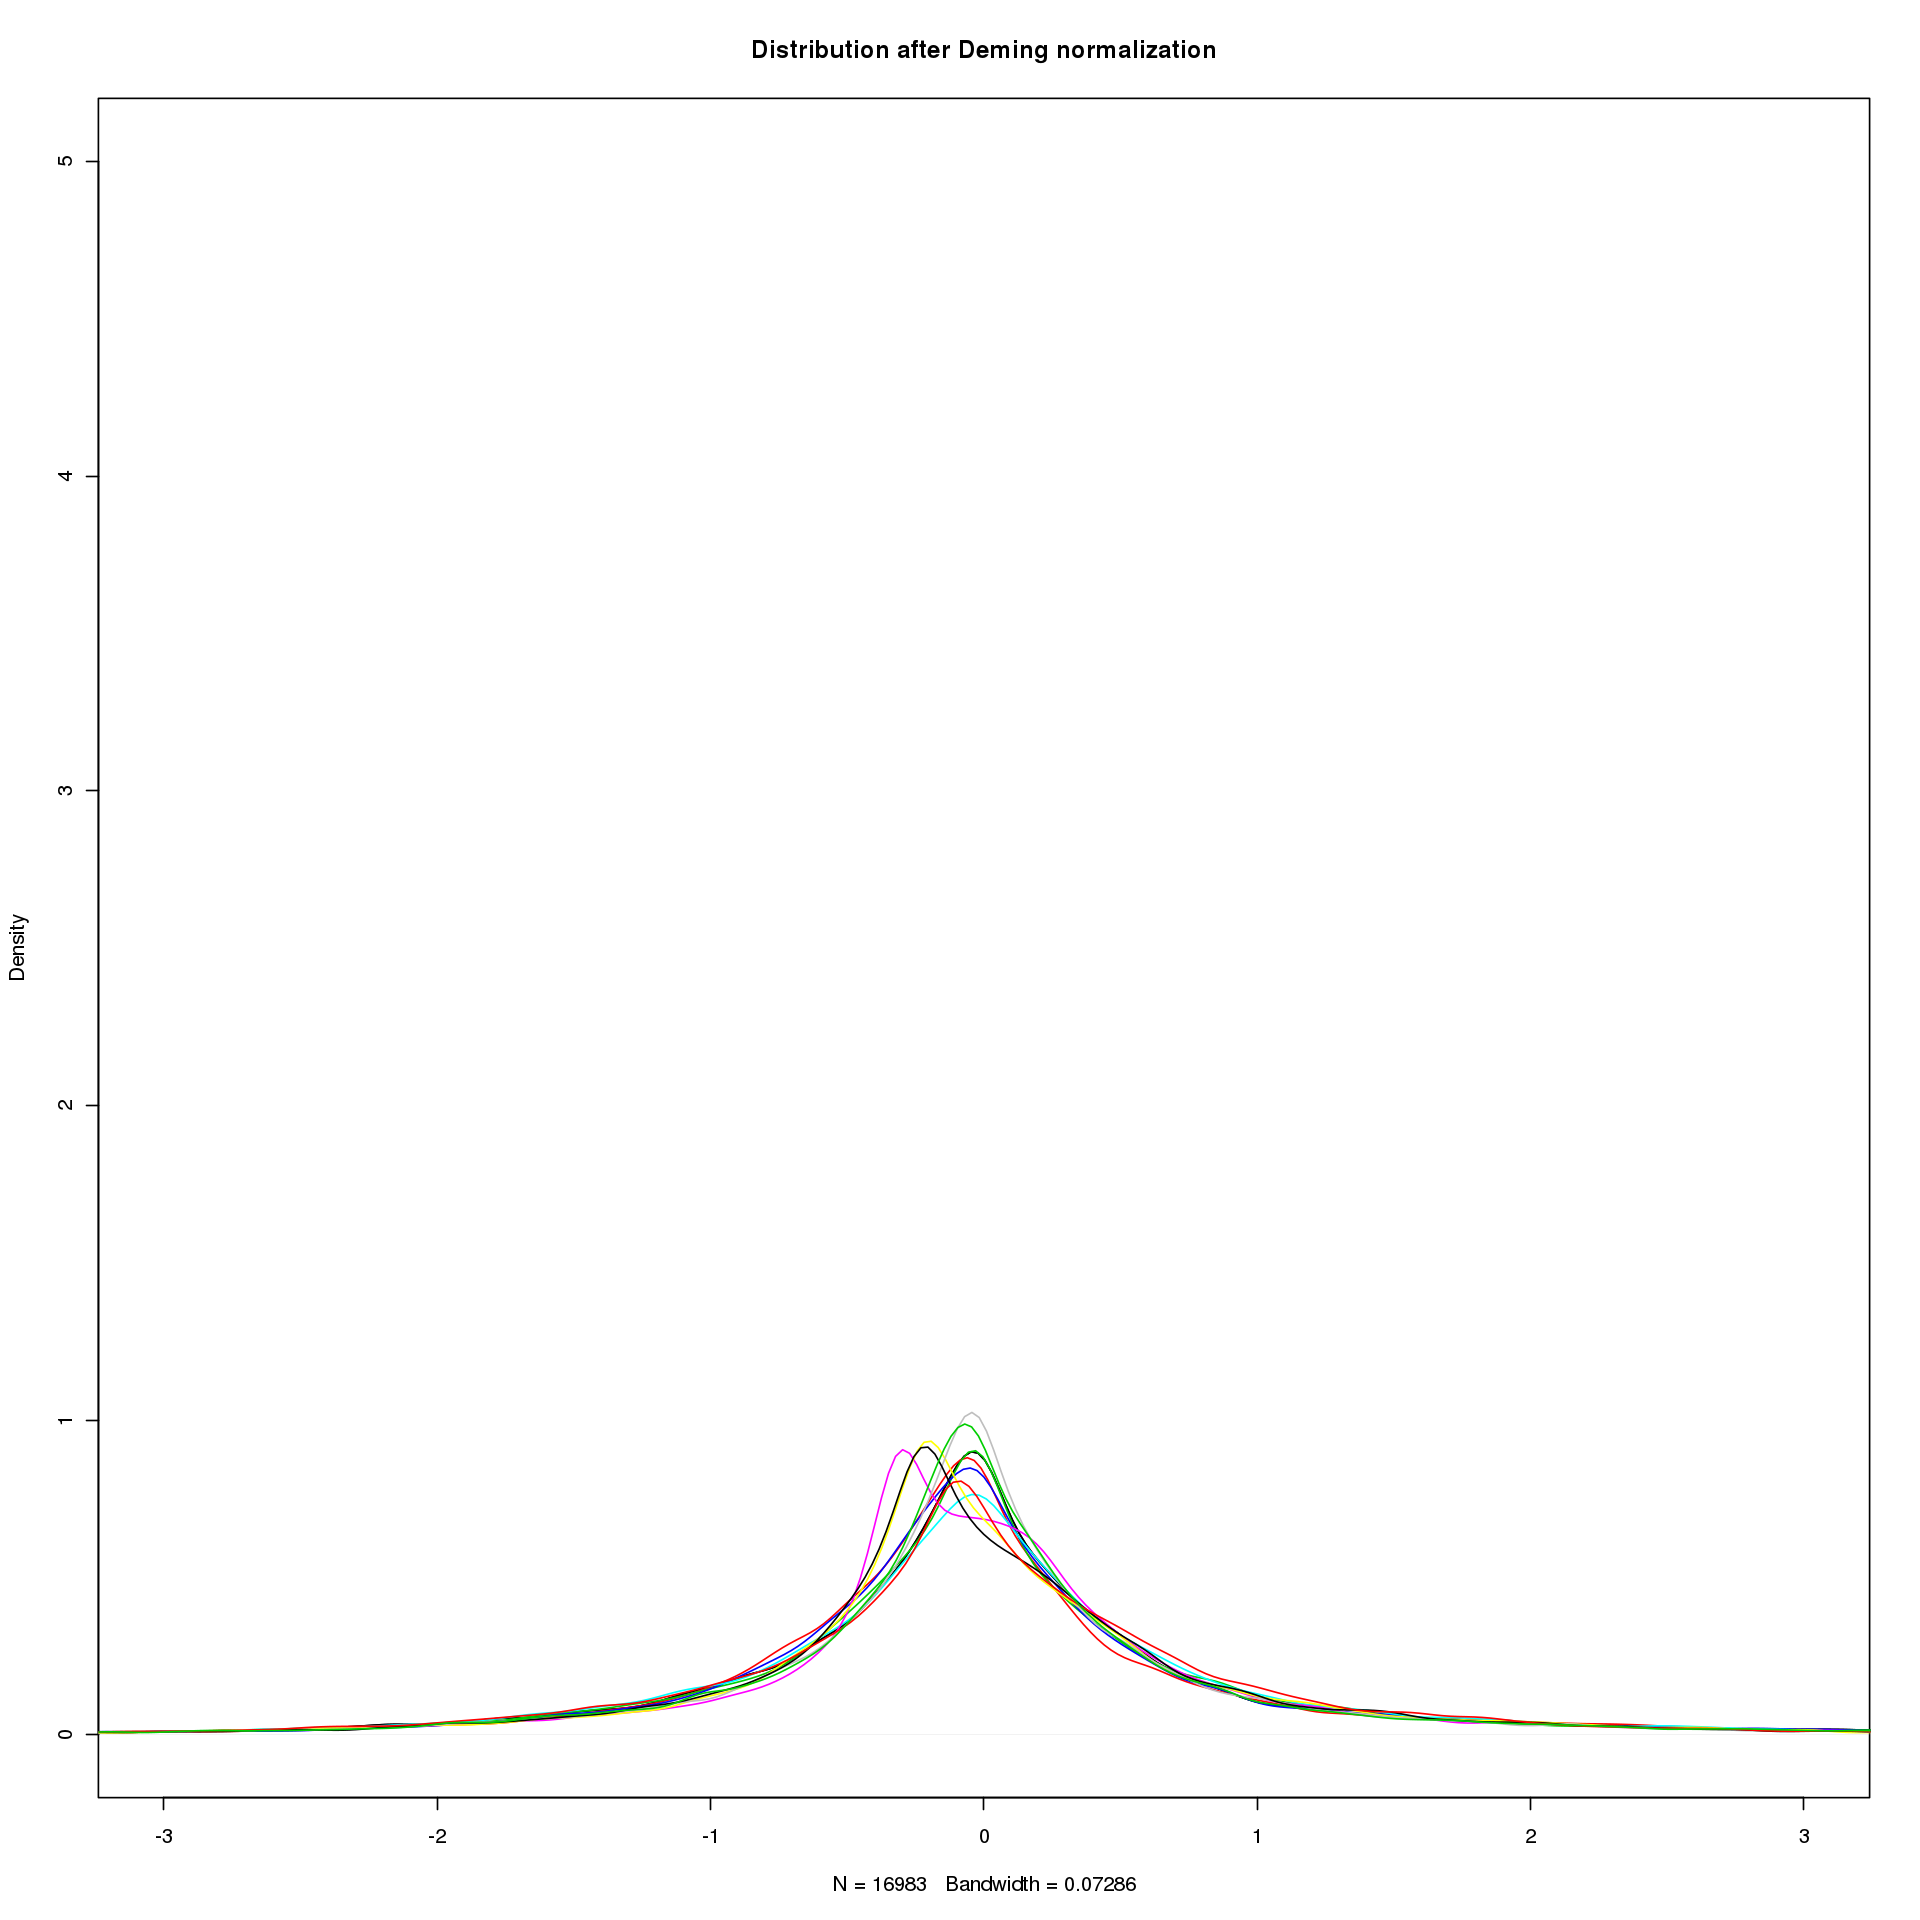

In [47]:
Deming_output <- list()
a <- 'GSE67462$OSKM'
Deming_output[[a]] <- Multiple_Deming_normalization(logFC_list=datasets_list,
                                                    number_top=correlation_output$Number_top_genes,
                                                    coeff_thresholds=c(0.1, 0.5),
                                                    se_table=T,
                                                    FDR_threshold=0.001, 
                                                    number_iter=2,
                                                    function_path=function_path)

#Here coeff_thresholds represent different thresholds for correlation coefficients
#(useful to try different values to see how consistent is the output of normalization)
#SE_table parameter specifies if SE values should be normalized as well (if you have them, put "True")
#Number of iterations specifies the number of independent runs (to see if the output is consistent)

In [48]:
#Outputs of the function:
#A) the graph showing the consistency of resulted normalization coefficients
#Deming_output[[1]]$Quality

#B) average error - the estimation of quality for each round of normalization (smaller - better)
#Deming_output[[1]]$Minimums

#C) Final list of normalization coefficients
Deming_output[[1]]$Final_deming_coefs

GSE89455$OSKM$HDF GSE89455$OSKM$HAdMSC     GSE89455$OSKM$HA 
           1.0000000            0.9868245            0.9846806 
  GSE89455$OSKM$HBEC  GSE89455$OSKM$HPrEC    GSE50206$OSKM$HDF 
           0.9881100            0.9575379            1.0541865 
   GSE50206$OSKM$ASC     GSE50206$OSKM$HA   GSE50206$OSKM$NHBE 
           1.0345896            1.0559152            1.0356937 
  GSE50206$OSKM$PrEC    GSE54848$OSKM$HDF 
           0.9793295            1.0551758

In [49]:
saveRDS(Deming_output, "deming_outputs/Deming_output_human_11ds_humanEntrez.rds")
#Deming_output <- readRDS("Deming_output_v1.5_gene_clusters_filter2.rds")

# Metafor

In [50]:
Deming_output <- readRDS("deming_outputs/Deming_output_human_11ds_humanEntrez.rds")
datasets_list <- datasets_list[names(Deming_output[[1]]$Normalized_data)]

In [52]:
#3. Aggregation of datasets into a single signature using mixed-effect model
#Use metafor library for that
library(metafor)

#A) Get list of significant genes (which are diff expressed in at least one dataset)
significant_genes <- c()

FDR_thresh <- 0.05 #for treatment
for (i in names(datasets_list)){
  print(i)
  temp <- datasets_list[[i]]
  significant_genes <- union(significant_genes,
                             rownames(temp[temp$FDR<FDR_thresh,]))
}
cat("\n Total number of significant genes =", length(significant_genes))

[1] "GSE89455$OSKM$HDF"
[1] "GSE89455$OSKM$HAdMSC"
[1] "GSE89455$OSKM$HA"
[1] "GSE89455$OSKM$HBEC"
[1] "GSE89455$OSKM$HPrEC"
[1] "GSE50206$OSKM$HDF"
[1] "GSE50206$OSKM$ASC"
[1] "GSE50206$OSKM$HA"
[1] "GSE50206$OSKM$NHBE"
[1] "GSE50206$OSKM$PrEC"
[1] "GSE54848$OSKM$HDF"

 Total number of significant genes = 19211

In [53]:
#B) Obtain normalized data
temp_data <- Deming_output[[1]]$Normalized_data
temp_logFC <- make_matrix_from_list(temp_data, "logFC")
temp_SE <- make_matrix_from_list(temp_data, "SE")

In [54]:
#C) Filter out genes that are not significant in all datasets
temp_logFC <- temp_logFC[significant_genes,]
temp_SE <- temp_SE[significant_genes,]

In [55]:
#D) Filter out low expressed genes (genes presented in only few datasets)
datasets_threshold <- 2
enough_data <- rownames(temp_logFC[apply(temp_logFC,1,function(x){sum(!is.na(x))})>=datasets_threshold,])
temp_logFC <- temp_logFC[enough_data,]
temp_SE <- temp_SE[enough_data,]

In [56]:
#E) Create a set with group factors
GSE <- c()
TREATMENT <- c()
ID <- c()
for (i in 1:length(datasets_list)){
    name <- names(datasets_list)[[i]]
    splt <- strsplit(name, "$", T)[[1]]
    #GSE <- c(GSE, splt[[1]])
    ID <- c(ID, name)
    GSE <- c(GSE, splt[[1]])
    TREATMENT <- c(TREATMENT, splt[[2]])
}

GSE
TREATMENT

[1] "GSE89455" "GSE89455" "GSE89455" "GSE89455" "GSE89455" "GSE50206"
 [7] "GSE50206" "GSE50206" "GSE50206" "GSE50206" "GSE54848"

[1] "OSKM" "OSKM" "OSKM" "OSKM" "OSKM" "OSKM" "OSKM" "OSKM" "OSKM" "OSKM"
[11] "OSKM"

In [57]:
#E+) make treatment simpler
MAPPING <- c("OSKM"="OSKM", 
             "OSK"="OSK", 
             "OKMS"="OSKM",
             "OK+9MS"="OSKM",
             "GFP"="Control",
             "C/EBPα- OSKM"="OSKM",
             "C/EBPα+ OSKM"="OSKM",
             "Oct4+SK"="OSK",
             "Oct6+SK"="OSK",
             "Oct4+defSox+K"="OSK",
             'OSKM+dox_mef'="OSKM",
             'OSKM-dox_mef'="Control",
             '7F-Esrrb'="7F",
             '7F-Glis1'="7F",
             '7F-Jdp2'="7F",
             '7F-Kdm2b'="7F",
             '7F-Mkk6'="7F",
             '7F-Nanog'="7F",
             '7F-Sall4'="7F",
             '7F'="7F"
            )
for (i in 1:length(TREATMENT)){
    TREATMENT[[i]] <- MAPPING[[TREATMENT[[i]]]]
}

In [58]:
datasets_annotations <- as.data.frame(ID)

datasets_annotations$ID <- as.factor(ID)
datasets_annotations$GSE <- as.factor(GSE)
datasets_annotations$TREATMENT <- as.factor(TREATMENT)
row.names(datasets_annotations) <- datasets_annotations$ID

In [78]:
#stoplist applying
# stoplist <- c("GSE38509$GFP", "GSE103979$GFP",
#             "GSE10871$OSKM", "GSE46321$C/EBPα- OSKM",
#             "GSE103979$Oct4+SK","GSE103979$Oct6+SK","GSE103979$Oct4+defSox+K","GSE103979$GFP")
stoplist <- c()
#stoplist <- c()
filter = !(names(datasets_list) %in% stoplist)

temp_logFC <- temp_logFC[, filter]
temp_SE <- temp_SE[, filter]
datasets_annotations <- datasets_annotations[filter,]

print(rownames(datasets_annotations))

 [1] "GSE89455$OSKM$HDF"    "GSE89455$OSKM$HAdMSC" "GSE89455$OSKM$HA"    
 [4] "GSE89455$OSKM$HBEC"   "GSE89455$OSKM$HPrEC"  "GSE50206$OSKM$HDF"   
 [7] "GSE50206$OSKM$ASC"    "GSE50206$OSKM$HA"     "GSE50206$OSKM$NHBE"  
[10] "GSE50206$OSKM$PrEC"   "GSE54848$OSKM$HDF"   


### model comparison
* y ~ 1 | TREATMENT + (1 | GSE / ID)  
* y ~ (1 | GSE / ID) 
* y ~ (1 | GSE / ID) [no Control] 
* y ~ 1 + (1 | ID) [No Control] 
* y ~ 1 | TREATMENT + (1 | GSE / ID) [No Control] 
* y ~ (1 | GSE / ID) [no Control; no RNA-seq] 
* y ~ (1 | ID) [no Control; no RNA-seq]
* y ~ (~ 1 | GSE,  ~ 1 | ID) 
* y ~ (~ 1 | GSE,  ~ 1 | ID) [no Control] 

In [59]:
mods_formula <- NA#~ TREATMENT
re_formula <- list(~1 | GSE, ~ 1 | ID)
sigma2 <- c(NA, NA)

important <- c("b", "pval", "se", "fit.stats", "QMp")

In [60]:
### test
dat <- as.matrix(temp_logFC)
stdat <- as.matrix(temp_SE)

output <- list()
# Run analysis
skipped = 0
for (g in 1:nrow(dat)){ #nrow(dat)
    
    temp_id <- rownames(dat)[g]
    gene_df <- datasets_annotations 
    gene_df['y'] <- dat[temp_id,] #mean effect
    gene_df['V'] <- stdat[temp_id,]^2 #effect variance
    gene_df <- gene_df[complete.cases(gene_df),]
    
    if(nrow(gene_df)>2){
        #check if we do not use formula for coefficients
        mods_formula <- if(typeof(mods_formula) == 'language') mods_formula else rep(0, nrow(gene_df))
        #run metafor
        tryCatch(suppressWarnings({
            result = rma.mv(yi = y, 
                            V = V,
                            data = gene_df,
                            random = re_formula,
                            method = "REML",
                            mods = mods_formula,
                            test = "t",
                            sigma2 = sigma2)
            gene_result <- list()
            for (res in important){
                gene_result[res] <- result[res]
                #Compute variance components in %
#                 VC <- var.comp(result)
#                 gene_result["lvl1"] <- VC$results[1,1]
#                 gene_result["lvl2"] <- VC$results[2,1]
#                 gene_result["lvl3"] <- VC$results[3,1]
            }
            output[[as.character(temp_id)]] <- gene_result
            
            }), error=function(e){
                skipped = skipped + 1
                print("Main\n")
                cat("ERROR :",conditionMessage(e), "\n")})
    }else{
          skipped = skipped + 1
    }
    if ((g %% 1000)==0){
        cat("Processed:", g, "of", nrow(dat), '\n')  
        flush.console()
    }
}
cat("Skipped:", skipped)

[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
Processed: 1000 of 19211 
[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
[1] "Main\n"
ERROR : Optimizer (nlminb) did not achieve convergence (convergence = 1). 
Proces

In [61]:
saveRDS(output, "metafor_outputs/y ~ (~ 1 | GSE, ~ 1 | ID) human_11_datasets_humanEntrez.rds")
#output <- readRDS("y ~ (~ 1 | GSE, ~ 1 | ID) gene_clusters_16_datasets.rds")

### run

In [ ]:
#E) Download annotation of datasets
#datasets_annotations <- read.csv("PATH.csv")

#F) Run metafor
#Include random terms if different species/tissues/sources of data are presented
#Random terms should be included as factors in specified columns of datasets_annotation
source(paste0(function_path,"FUN.Metafor_analysis.R"))
metafor_result <- suppressWarnings(Metafor_analysis(
                                   current_data = temp_logFC,
                                   current_std = temp_SE,
                                   current_desc = datasets_annotations,
                                   random_terms = c("GSE", "TREATMENT"), #= c("SPECIES","TISSUE_TYPE","SOURCE"),
                                   LOO = F))

#Number of significant genes
FDR_thresh <- 0.01
sum(metafor_result$FDR<FDR_thresh)

#saveRDS(metafor_result,"Metafor_result.rds")

In [32]:
#saveRDS(metafor_result,"Metafor_result_[GSE, TREATMENT]_+RNAdatasets.rds")

In [34]:
genes <- row.names(metafor_result[metafor_result$FDR<0.05,])
length(genes)

[1] 293

In [35]:
slopes[rownames(metafor_result[metafor_result$FDR<0.00001,]),]

GSE67462$OSKM GSE38509$OSKM GSE38509$OSK  GSE38509$GFP GSE116309$OKMS
NA               NA             NA            NA           NA           NA  
18711   0.003484013   0.0126235823  5.876696e-03  0.019085698 -0.000594378  
56517  -0.009586283  -0.0089103683 -5.710489e-04  0.005711010 -0.013494626  
72938  -0.008487499   0.0117127052 -1.760007e-02 -0.009532045  0.008062691  
NA.1             NA             NA            NA           NA           NA  
57742  -0.002839414  -0.0233566562  1.870312e-05 -0.009418734 -0.015263729  
66540  -0.003219904  -0.0392925703 -1.478333e-02 -0.008918381 -0.015158239  
NA.2             NA             NA            NA           NA           NA  
230145  0.001750851   0.0202632997  2.701794e-02 -0.010307787 -0.008452243  
NA.3             NA             NA            NA           NA           NA  
19267  -0.001442340  -0.0132231661 -2.651664e-02 -0.031850693 -0.016851725  
29809   0.003626267  -0.0025601269 -1.852684e-02  0.027859392  0.006021842  
67840  -0.002494784  -0.0219331452 -1.958182e-02 -0.013534774 -0.007423715  
NA.4             NA             NA            NA           NA           NA  
NA.5             NA             NA            NA           NA           NA  
269831 -0.009350859   0.0208028075  7.398856e-02 -0.041961248 -0.052632308  
NA.6             NA             NA            NA           NA           NA  
NA.7             NA             NA            NA           NA           NA  
NA.8             NA             NA            NA           NA           NA  
NA.9             NA             NA            NA           NA           NA  
NA.10            NA             NA            NA           NA           NA  
NA.11            NA             NA            NA           NA           NA  
NA.12            NA             NA            NA           NA           NA  
13134  -0.021808621   0.0067741348 -1.101619e-02 -0.005675556 -0.011759593  
NA.13            NA             NA            NA           NA           NA  
NA.14            NA             NA            NA           NA           NA  
NA.15            NA             NA            NA           NA           NA  
NA.16            NA             NA            NA           NA           NA  
NA.17            NA             NA            NA           NA           NA  
NA.18            NA             NA            NA           NA           NA  
12826  -0.004628831  -0.0000977187 -1.858367e-02 -0.025749873 -0.004843862  
       GSE116309$OK+9MS GSE46321$C/EBPα+ OSKM GSE46321$C/EBPα- OSKM
NA                NA              NA                    NA         
18711   8.603665e-03     0.031550285           0.022224563         
56517  -1.224822e-02    -0.015552767          -0.019678711         
72938   5.398946e-03    -0.047921787          -0.025164533         
NA.1              NA              NA                    NA         
57742  -3.871699e-02    -0.011948757          -0.039541186         
66540   6.505065e-04    -0.209921662           0.018105871         
NA.2              NA              NA                    NA         
230145 -8.737837e-05     0.002847536           0.029360697         
NA.3              NA              NA                    NA         
19267  -1.727249e-02    -0.123478737          -0.018757847         
29809   2.830906e-03    -0.124921132           0.045810545         
67840  -2.496147e-03    -0.018458986          -0.029756808         
NA.4              NA              NA                    NA         
NA.5              NA              NA                    NA         
269831 -1.150536e-02    -0.123373312           0.006889006         
NA.6              NA              NA                    NA         
NA.7              NA              NA                    NA         
NA.8              NA              NA                    NA         
NA.9              NA              NA                    NA         
NA.10             NA              NA                    NA         
NA.11             NA              NA           

In [36]:
metafor_result[metafor_result$FDR<0.00001,]

ID        coefficient se         pvalue       FDR         
17301     17301     -0.5003596  0.07724998 9.347203e-11 1.106460e-07
18711     18711      0.2926209  0.04853240 1.645760e-09 1.538006e-06
56517     56517     -0.2006138  0.03252600 6.924781e-10 7.232730e-07
72938     72938     -0.4119832  0.05623615 2.372133e-13 3.829053e-10
216974    216974     0.4955689  0.08360392 3.074320e-09 2.183505e-06
57742     57742     -0.3757872  0.05148524 2.900654e-13 4.292001e-10
66540     66540     -0.7202380  0.07938079 1.155690e-19 1.026021e-15
74038     74038     -0.3434498  0.04312175 1.656855e-15 3.677389e-12
230145    230145     0.2913192  0.03325094 1.931265e-18 1.143052e-14
627427    627427    -0.6403109  0.10755498 2.627315e-09 1.943775e-06
19267     19267     -0.4910604  0.08643442 1.336696e-08 7.911460e-06
29809     29809      0.2747118  0.04589536 2.155788e-09 1.664269e-06
67840     67840     -0.2846350  0.04740847 1.926501e-09 1.664269e-06
71837     71837     -0.3684766  0.06145365 2.022266e-09 1.664269e-06
170798    170798     1.0961393  0.18780933 5.332550e-09 3.381598e-06
269831    269831    -0.3762726  0.05459737 5.510163e-12 7.526036e-09
15051     15051     -0.9571842  0.11524010 9.898222e-17 2.929214e-13
67304     67304     -0.3854498  0.06232482 6.228737e-10 6.912341e-07
74365     74365     -0.3698626  0.04018267 3.431702e-20 6.093331e-16
97783     97783      0.4437806  0.07592432 5.064476e-09 3.330549e-06
100702    100702    -1.5726251  0.18764638 5.257309e-17 1.866976e-13
214952    214952     0.2091672  0.03602497 6.391744e-09 3.913511e-06
677168    677168    -1.3341049  0.21877778 1.074099e-09 1.059539e-06
13134     13134     -0.2714255  0.03519937 1.247496e-14 2.461171e-11
239319    239319     0.2201193  0.03270749 1.697388e-11 2.152773e-08
328830    328830    -0.4240160  0.07479539 1.436233e-08 8.226372e-06
100043387 100043387  0.2813887  0.03355991 5.086934e-17 1.866976e-13
320301    320301     0.5532420  0.06685210 1.277971e-16 3.241665e-13
93696     93696     -0.2410314  0.03289467 2.347169e-13 3.829053e-10
545261    545261    -1.0114253  0.16879208 2.071009e-09 1.664269e-06
12826     12826     -0.2683524  0.04572958 4.404300e-09 3.007798e-06
          intervention_LOO coefficient_LOO pvalue_LOO FDR_LOO
17301     0                0               1          1      
18711     0                0               1          1      
56517     0                0               1          1      
72938     0                0               1          1      
216974    0                0               1          1      
57742     0                0               1          1      
66540     0                0               1          1      
74038     0                0               1          1      
230145    0                0               1          1      
627427    0                0               1          1      
19267     0                0               1          1      
29809     0                0               1          1      
67840     0                0               1          1      
71837     0                0               1          1      
170798    0                0               1          1      
269831    0                0               1          1      
15051     0                0               1          1      
67304     0                0               1          1      
74365     0                0               1          1      
97783     0                0               1          1      
100702    0                0               1          1      
214952    0                0               1          1      
677168    0                0               1          1      
13134     0                0               1          1      
239319    0                0               1          1      
328830    0                0               1          1      
100043387 0                0               1          1      
320301    0                0               1          1      
9369

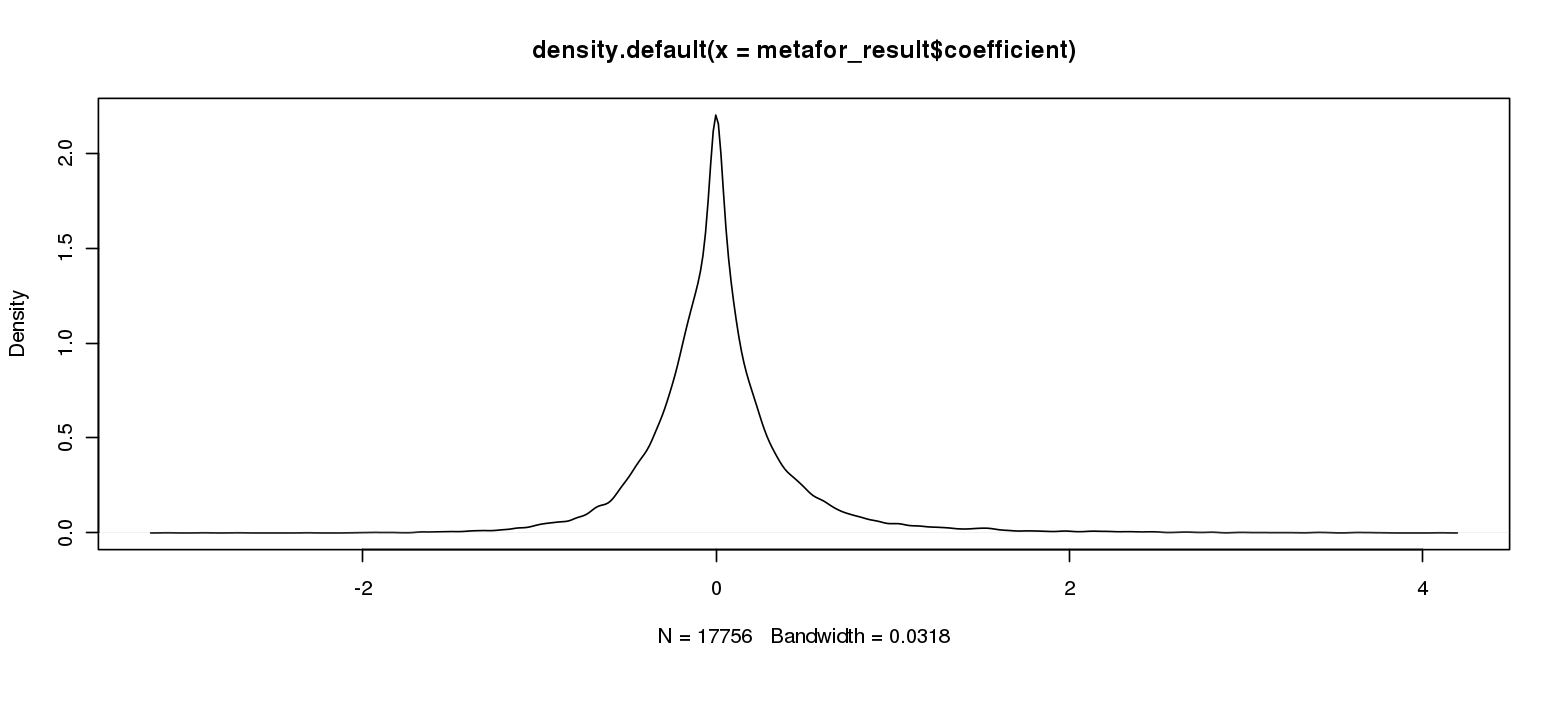

In [37]:
options(repr.plot.width = 13, repr.plot.height = 6)
par(mar=c(7,4,4,2)+0.1)
plot(density(metafor_result$coefficient))

### Model results exploration

In [30]:
out <- readRDS("y ~ (~ 1 | GSE, ~ 1 | ID) gene_clusters_16_datasets.rds")

In [ ]:
COLUMNS <- list(c("b", "coef", 1),
#                 c("b", "OSK.coef", 2),
#                 c("b", "OSKM.coef", 3),
                c("pval", "pval", 1),
#                 c("pval", "OSK.pval", 2),
#                 c("pval", "OSKM.pval", 3),
#                 c("QMp", "model.pval", NA),
                c("se", "se", 1),
#                 c("se", "OSK.se", 2),
#                 c("se", "OSKM.se", 3),
#                 c("lvl1", "lvl1", NA),
#                 c("lvl2", "lvl2", NA),
#                 c("lvl3", "lvl3", NA),
                c("fit.stats", "AIC", 8),
                c("fit.stats", "BIC", 9)
               )

df <- data.frame(row.names=names(out))

for (col in COLUMNS){
    #cat(col,'\n')
    tmp <- gather(out, col[[1]], col[[2]], as.numeric(col[[3]]))
    df <- cbind(df, tmp)
}

In [96]:
df$FDR.coef <- p.adjust(df$pval, method="BH")
# df$FDR.OSK <- p.adjust(df$OSK.pval, method="BH")
# df$FDR.OSKM <- p.adjust(df$OSKM.pval, method="BH")
# df$FDR.model <- p.adjust(df$model.pval, method="BH")

In [32]:
cdf <- df[complete.cases(df),]

In [98]:
#min(cdf$FDR.OSKM)
head(df[order(df$FDR.coef),])

coef     pval         se         AIC      BIC      FDR.coef    
20527 2.647769 1.519444e-11 0.14762199 35.82174 37.94589 1.185166e-09
17075 3.671379 7.713778e-11 0.22932416 43.76665 45.89080 3.008373e-09
66599 1.109390 1.159550e-08 0.09941881 21.11342 23.23757 3.014830e-07
18020 1.086597 2.627592e-07 0.12353392 25.65714 27.78129 4.099044e-06
20732 2.335273 2.481460e-07 0.26430203 37.01985 39.14400 4.099044e-06
11676 2.744023 1.242488e-06 0.35342517 41.24573 43.36988 1.615235e-05

In [101]:
passed <- cdf[cdf$FDR.coef < 0.05, ]
passed <- passed[order(passed$FDR.coef),]
#passed

In [ ]:
plot(unlist(temp_logFC['217333',]))

In [409]:
gg <- rownames(passed[passed$FDR.coef < 0.05, ])

In [33]:
#as.vector(lookUp(gg, 'org.Mm.eg', 'SYMBOL'))

In [102]:
cdf[cdf$FDR.coef < 0.05, ]

coef       pval         se         AIC        BIC       FDR.coef    
11676   2.7440234 1.242488e-06 0.35342517 41.2457259 43.369876 1.615235e-05
13436   1.6688883 9.111956e-06 0.25458252 32.1932661 34.317417 7.107326e-05
13511   2.0217658 1.003195e-04 0.38602351 38.4658653 40.590016 4.890577e-04
13867   1.4426438 1.796893e-04 0.29233192 49.3169333 51.441084 8.244569e-04
17075   3.6713787 7.713778e-11 0.22932416 43.7666502 45.890801 3.008373e-09
18020   1.0865973 2.627592e-07 0.12353392 25.6571354 27.781286 4.099044e-06
18476   0.5324727 3.036921e-06 0.07387985 14.0779994 16.202150 3.383998e-05
20527   2.6477687 1.519444e-11 0.14762199 35.8217426 37.945893 1.185166e-09
20732   2.3352725 2.481460e-07 0.26430203 37.0198462 39.143997 4.099044e-06
54648   0.7713629 7.331603e-05 0.14277438 17.3060798 19.430230 3.812433e-04
66599   1.1093905 1.159550e-08 0.09941881 21.1134241 23.237575 3.014830e-07
14426  -0.4020438 4.086572e-04 0.08899364 12.2764201 14.400571 1.517870e-03
18718  -0.6387805 7.474415e-06 0.09576293 10.0529198 12.177070 6.477826e-05
20184  -0.3087726 1.438166e-05 0.04905603 -5.6354157 -3.511265 1.019791e-04
227377 -1.0473764 3.731632e-04 0.22951918 24.6711759 26.795326 1.455336e-03
230103 -0.9559332 2.115513e-03 0.25798304 35.2513874 37.375538 6.346540e-03
67844  -1.0697878 2.344559e-03 0.29267286 37.2822839 39.406434 6.531272e-03
102614  1.0370675 9.693583e-03 0.35012130 41.3959477 43.520098 2.100276e-02
76295   0.4141288 3.875758e-05 0.07208982  7.9645603 10.088711 2.219097e-04
102644 -0.7618169 2.216012e-03 0.20686071 21.7038690 23.828020 6.401813e-03
19376  -0.5901857 5.488144e-06 0.08613387  7.4547852  9.578936 5.350941e-05
67951  -0.7764687 2.459711e-04 0.16263400 22.0146349 24.138786 1.009776e-03
15259  -0.4582185 2.344037e-04 0.09548457 13.0856661 15.209817 1.009776e-03
19091  -1.1600208 6.148172e-03 0.36419881 37.1493619 39.273513 1.410463e-02
68861  -0.3796861 3.291151e-03 0.10737716 19.1016157 21.018788 8.852060e-03
18082   0.5774758 3.556462e-05 0.09971269 21.8972593 24.021410 2.219097e-04
67216   0.8482239 4.868815e-03 0.25711495 23.9530849 26.077236 1.225057e-02
22222  -0.2285623 3.982995e-05 0.03989005 -4.3973218 -2.273171 2.219097e-04
67239  -0.2697419 1.135076e-02 0.09260509  9.0069251 10.924097 2.392863e-02
20932  -0.3446029 4.009237e-03 0.10154180  7.4144276  9.538578 1.042402e-02
56174  -0.3240385 1.671003e-03 0.08481125 10.3720000 12.496151 5.213528e-03
18746   0.1688362 9.503547e-04 0.04120098 -0.7650165  1.359134 3.088653e-03
26914   0.3470254 6.028751e-03 0.10862491  8.9799395 11.104090 1.410463e-02
16772   1.0912534 1.470543e-02 0.39594507 47.2196172 49.343768 3.018484e-02
12579  -0.6009253 4.437244e-04 0.13424395 29.6719444 31.796095 1.573205e-03
12847  -0.2564595 5.252034e-03 0.07861919  3.4136879  5.537838 1.280183e-02
19769  -0.2852082 9.010425e-04 0.06915543  1.7063356  3.830486 3.055710e-03
54138   0.1829693 9.560336e-03 0.06163009  0.2745467  2.398697 2.100276e-02

# Metafor Treatment vs Metafor Control (load data)

## mouse

In [26]:
#mouse signature parsing
outt <- readRDS("metafor_outputs/y ~ (~ 1 | GSE, ~ 1 | ID) all_genes_19_datasets_treat.rds")
outc <- readRDS("metafor_outputs/y ~ (~ 1 | ID) all_genes_3_datasets_control.rds")

COLUMNS <- list(c("b", "coef", 1),
                c("pval", "pval", 1),
                c("se", "se", 1),
                c("fit.stats", "AIC", 8),
                c("fit.stats", "BIC", 9)
               )

dft <- data.frame(row.names=names(outt))
dfc <- data.frame(row.names=names(outc))

for (col in COLUMNS){
    #cat(col,'\n')
    tmp <- gather(outt, col[[1]], col[[2]], as.numeric(col[[3]]))
    dft <- cbind(dft, tmp)

    tmp <- gather(outc, col[[1]], col[[2]], as.numeric(col[[3]]))
    dfc <- cbind(dfc, tmp)
}
dft$FDR.coef <- p.adjust(dft$pval, method="BH")
dfc$FDR.coef <- p.adjust(dfc$pval, method="BH")

dft$symbol <- as.data.frame(queryMany(rownames(dft), scopes="entrezgene", species="mouse"))$symbol

#inner merge
df <- transform(merge(dft[c("coef", "pval", "se", "FDR.coef")],
                        dfc[c("pval")],
                        suffixes=c('_T', '_C'), by=0, all=F), row.names=Row.names, Row.names=NULL)

#separate into upregulated, downregulated and both tables
up <- df[(df$FDR.coef < 0.05) & (df$pval_C >= 0.2) & (df$coef > 0.), ]
dw <- df[(df$FDR.coef < 0.05) & (df$pval_C >= 0.2) & (df$coef < 0.), ]
cdf <- df[(df$FDR.coef < 0.05) & (df$pval_C >= 0.2),]                        

#add symbol column
cdf$symbol <- as.data.frame(queryMany(rownames(cdf), scopes="entrezgene", species="mouse"))$symbol

Querying chunk 1

Querying chunk 2

Querying chunk 3

Querying chunk 4

Querying chunk 5

Querying chunk 6

Querying chunk 7

Querying chunk 8

Querying chunk 9

Querying chunk 10

Querying chunk 11

Querying chunk 12

Querying chunk 13

Querying chunk 14

Querying chunk 15

Querying chunk 16

Querying chunk 17

Querying chunk 18

Querying chunk 19

Querying chunk 20

Querying chunk 21

Querying chunk 22



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


Querying chunk 1

Querying chunk 2



Finished


In [2]:
dft <- read.csv('reprogramming_full.csv', row.names=1)
dfc <- read.csv('reprogramming_control.csv', row.names=1)

## human

In [9]:
#human signature parsing
out <- readRDS("metafor_outputs/y ~ (~ 1 | GSE, ~ 1 | ID) human_11_datasets_humanEntrez.rds")

COLUMNS <- list(c("b", "coef", 1),
                c("pval", "pval", 1),
                c("se", "se", 1),
                c("fit.stats", "AIC", 8),
                c("fit.stats", "BIC", 9)
               )

dft_human <- data.frame(row.names=names(out))

for (col in COLUMNS){
    #cat(col,'\n')
    tmp <- gather(out, col[[1]], col[[2]], as.numeric(col[[3]]))
    dft_human <- cbind(dft_human, tmp)
}

dft_human$FDR.coef <- p.adjust(dft_human$pval, method="BH")
dft_human$symbol <- as.data.frame(queryMany(rownames(dft_human), scopes="entrezgene", species="human"))$symbol

Querying chunk 1

Querying chunk 2

Querying chunk 3

Querying chunk 4

Querying chunk 5

Querying chunk 6

Querying chunk 7

Querying chunk 8

Querying chunk 9

Querying chunk 10

Querying chunk 11

Querying chunk 12

Querying chunk 13

Querying chunk 14

Querying chunk 15

Querying chunk 16

Querying chunk 17

Querying chunk 18

Querying chunk 19

Querying chunk 20



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [8]:
#write.csv(dft_human, 'reprogramming_human_full.csv')
write.csv(dft_human, 'reprogramming_human_full_humanEntrez.csv')
# dft_human <- read.csv('reprogramming_human_full_humanEntrez.csv', row.names=1)
# dft_human["ID"] <- rownames(dft_human)
# colnames(dft_human) <- c('logFC', "P.Value", "SE", "AIC", "BIC", "FDR", "symbol", "Entrez")


## both

In [5]:
#common signature parsing
out <- readRDS("metafor_outputs/y ~ (~ 1 | GSE, ~ 1 | ID) human_mouse_30_datasets_mouseEntrez.rds")

COLUMNS <- list(c("b", "coef", 1),
                c("pval", "pval", 1),
                c("se", "se", 1),
                c("fit.stats", "AIC", 8),
                c("fit.stats", "BIC", 9)
               )

dfb <- data.frame(row.names=names(out))

for (col in COLUMNS){
    #cat(col,'\n')
    tmp <- gather(out, col[[1]], col[[2]], as.numeric(col[[3]]))
    dfb <- cbind(dfb, tmp)
}

dfb$FDR.coef <- p.adjust(dfb$pval, method="BH")
dfb$symbol <- as.data.frame(queryMany(rownames(dfb), scopes="entrezgene", species="mouse"))$symbol

Querying chunk 1

Querying chunk 2

Querying chunk 3

Querying chunk 4

Querying chunk 5

Querying chunk 6

Querying chunk 7

Querying chunk 8

Querying chunk 9

Querying chunk 10

Querying chunk 11

Querying chunk 12

Querying chunk 13

Querying chunk 14

Querying chunk 15

Querying chunk 16

Querying chunk 17

Querying chunk 18



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [13]:
#write.csv(dfb, 'reprogramming_human_mouse_full.csv')
# dft_both <- read.csv('reprogramming_human_mouse_full.csv', row.names=1)
# dft_both["ID"] <- rownames(dft_both)
# colnames(dft_both) <- c('logFC', "P.Value", "SE", "AIC", "BIC", "FDR", "symbol", "Entrez")
# write.csv(dft_both, 'reprogramming_human_mouse_full.csv')

# Signatures analysis

In [13]:
#filtered reprog
# reprog <- cdf 
# reprog['ID'] <- rownames(reprog)
# colnames(reprog) <- c('logFC', 'pval_T', 'SE', "FDR", "pval_C", "Gene_symbol", "Entrez")

#nonfiltered reprog
dft["ID"] <- rownames(dft)
colnames(dft) <- c('logFC', "P.Value", "SE", "AIC", "BIC", "FDR", "symbol", "Entrez")

#nonfiltered reprog
dft_human["ID"] <- rownames(dft_human)
colnames(dft_human) <- c('logFC', "P.Value", "SE", "AIC", "BIC", "FDR", "symbol", "Entrez")

dft_both["ID"] <- rownames(dft_both)
colnames(dft_both) <- c('logFC', "P.Value", "SE", "AIC", "BIC", "FDR", "symbol", "Entrez")

In [15]:
#add reprogramming
#combined <- c(list("Reprogramming:Mouse"=reprog), age) #datasets_list)
combined_full_rep <- c(list("Reprogramming:Mouse"=dft, 
                            "Reprogramming:Human"=dft_human,
                            "Reprogramming:All"=dft_both), age)
#combined_datasets_list <- c(list("Reprogramming:Mouse"=reprog), datasets_list)
names(combined_full_rep)

[1] "Reprogramming:Mouse"           "Reprogramming:Human"          
 [3] "Reprogramming:All"             "Interventions:Median_lifespan"
 [5] "Interventions:Max_lifespan"    "Interventions:CR"             
 [7] "Interventions:GH_deficiency"   "Interventions:Rapamycin"      
 [9] "Interventions:Common_liver"    "Aging:Brain"                  
[11] "Aging:Muscle"                  "Aging:Liver"                  
[13] "Aging:All"                     "Aging:Human"                  
[15] "Aging:Rat"                     "Aging:Mouse"

In [3]:
combined_full_rep <- readRDS('signatures/combined_full_rep.rds')
#saveRDS(combined_full_rep, 'combined_full_rep.rds')

## signatures correlation

In [248]:
# sl <- data.frame(row.names=rownames(combined[[1]]))
# for (n in names(combined)){
#         tmp <- combined[[n]]
#         tmp[n] <- tmp['logFC']
#         sl <- transform(merge(sl, tmp[n], by=0, sort=F,), row.names=Row.names, Row.names=NULL)
# }
# #add aggregated signature
# reprog['Metafor'] <- reprog['logFC']
# sl <- transform(merge(sl, reprog['Metafor'], by=0, sort=F,), row.names=Row.names, Row.names=NULL)

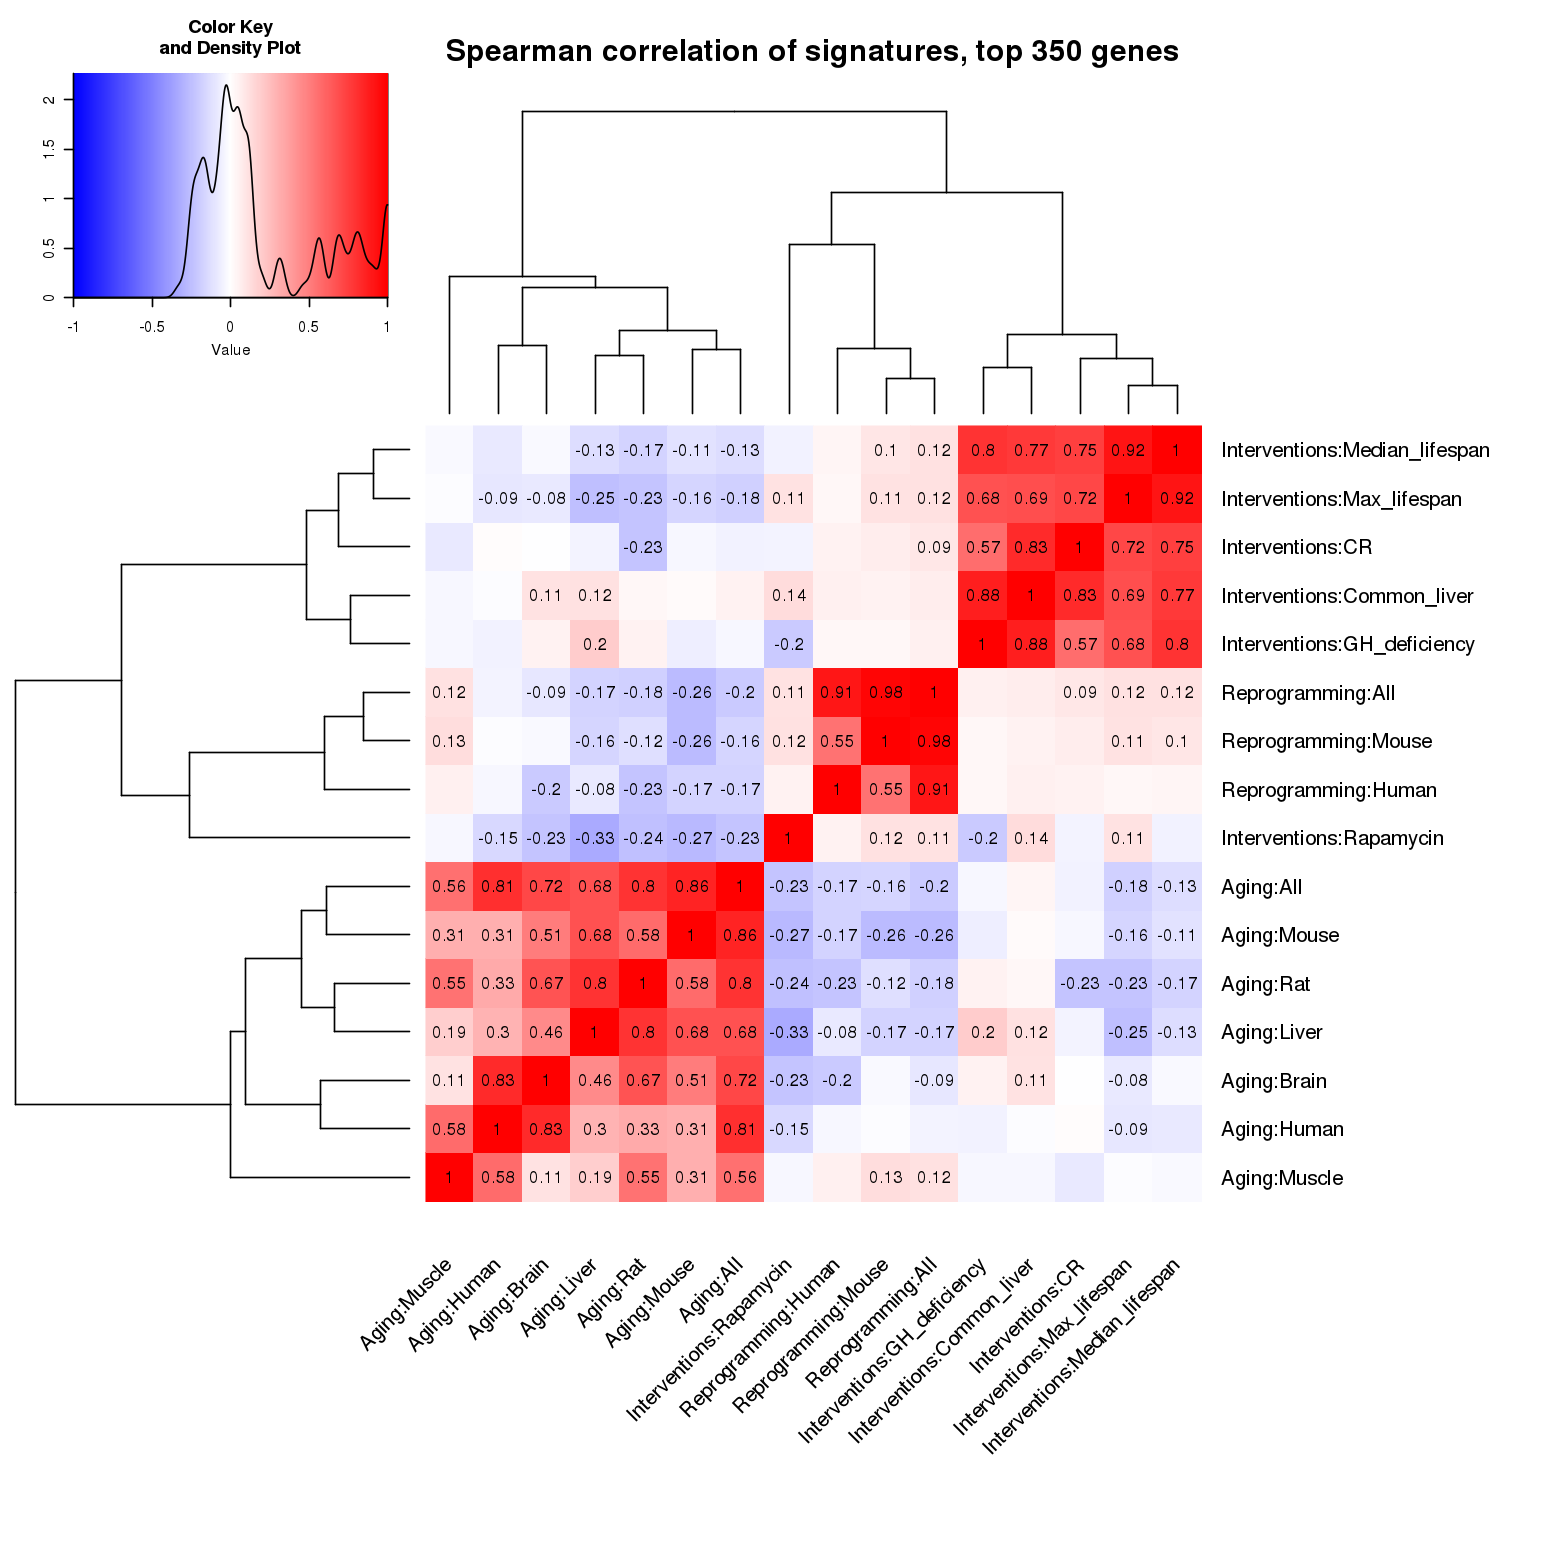

In [5]:
#plotting
corres <- suppressMessages(corplot(combined_full_rep, type='pairwise_top', method='spearman', top=350, 
                value_size=1.0, title='Spearman correlation of signatures, top 350 genes'))
#corplot(sl, type='full_intersection', method='spearman', top=F)

## signatures contingency matrix (enrichment)

In [52]:
thr <- 0.05
sub_rep <- reprog[reprog$FDR <= thr,] #only first 5 column filtered by threshold

cat("Total number of found reprogramming genes:", nrow(sub_rep), '\n')
cat("Chosen FDR threshold =", thr, '\n\n')

int_set <- c()
up_down_set <- c()
up_rep_down_age <- c()
down_rep_up_age <- c()

for (name in names(age)){
    sub_age <- age[[name]][age[[name]]$FDR <= thr,]
    sub <- merge(sub_age, sub_rep, by.x='Entrez', by.y='Entrez', suffixes=c(".rep", ".age"))
    
    # differently regulated genes subset
    up_down <-sub[((sub$logFC.age < 0) & (sub$logFC.rep > 0)) | 
                  ((sub$logFC.age > 0) & (sub$logFC.rep < 0)),]
    
    int_set[[name]] <- sub$Entrez.age
    
    urua <- length(sub[(sub$logFC.age > 0) & (sub$logFC.rep > 0),]$Entrez)
    urda <- length(sub[(sub$logFC.age < 0) & (sub$logFC.rep > 0),]$Entrez)
    drua <- length(sub[(sub$logFC.age > 0) & (sub$logFC.rep < 0),]$Entrez)
    drda <- length(sub[(sub$logFC.age < 0) & (sub$logFC.rep < 0),]$Entrez)
    
    if (all(c(urua, urda, drua, drda)) == T){
        #test for distribution randomness
        cont_table <- cbind(c(urua, drua), 
                            c(urda, drda))
        test <- chisq.test(cont_table)
        pval <- test$p.val
    }else{
        pval <- NA
    }

    up_rep_down_age[[name]] <- sub[(sub$logFC.age < 0) & (sub$coef.rep > 0),]$Entrez
    down_rep_up_age[[name]] <- sub[(sub$logFC.age > 0) & (sub$coef.rep < 0),]$Entrez
    up_down_set[[name]] <- up_down$Entrez
    
    cat(name, "(", nrow(sub_age), "genes )")
    cat("; intersected:", nrow(sub))
    cat('; ↑↓ genes:', nrow(up_down)) 
    cat('; ContTable pvalue:', as.character(pval), "\n")
}

Total number of found reprogramming genes: 1595 
Chosen FDR threshold = 0.05 

Interventions:Median_lifespan ( 4343 genes ); intersected: 549; ↑↓ genes: 225; ContTable pvalue: 2.27365704526278e-05 
Interventions:Max_lifespan ( 4892 genes ); intersected: 584; ↑↓ genes: 243; ContTable pvalue: 2.40229644267737e-05 
Interventions:CR ( 2047 genes ); intersected: 202; ↑↓ genes: 70; ContTable pvalue: 2.74736587413714e-05 
Interventions:GH_deficiency ( 2313 genes ); intersected: 339; ↑↓ genes: 138; ContTable pvalue: 0.000816877699763152 
Interventions:Rapamycin ( 772 genes ); intersected: 79; ↑↓ genes: 36; ContTable pvalue: 0.581433609510191 
Interventions:Common_liver ( 168 genes ); intersected: 18; ↑↓ genes: 8; ContTable pvalue: 1 
Aging:Brain ( 990 genes ); intersected: 112; ↑↓ genes: 57; ContTable pvalue: 0.876547664189639 
Aging:Muscle ( 587 genes ); intersected: 68; ↑↓ genes: 25; ContTable pvalue: 0.0352371141468236 
Aging:Liver ( 946 genes ); intersected: 126; ↑↓ genes: 80; ContTable pv

### Aggregation of Aging/Interventions signatures for contingency matrix

In [25]:
names(combined_full_rep)

[1] "Reprogramming:Mouse"           "Reprogramming:Human"          
 [3] "Reprogramming:All"             "Interventions:Median_lifespan"
 [5] "Interventions:Max_lifespan"    "Interventions:CR"             
 [7] "Interventions:GH_deficiency"   "Interventions:Rapamycin"      
 [9] "Interventions:Common_liver"    "Aging:Brain"                  
[11] "Aging:Muscle"                  "Aging:Liver"                  
[13] "Aging:All"                     "Aging:Human"                  
[15] "Aging:Rat"                     "Aging:Mouse"

In [12]:
#combine list of signatures into list of dataframes where each dataframe is the same column type
SLR <- list()
SLI <- list()
SLA <- list()
cols <- c('logFC', 'SE', 'P.Value', 'FDR')

for (col in cols){
    SLR[[col]] <- data.frame(row.names=rownames(combined_full_rep[['Reprogramming:Mouse']]))
    SLI[[col]] <- data.frame(row.names=rownames(combined_full_rep[['Interventions:Median_lifespan']]))
    SLA[[col]] <- data.frame(row.names=rownames(combined_full_rep[['Aging:Brain']]))
    for (name in names(combined_full_rep)){
        tmp <- combined_full_rep[[name]][col]
        colnames(tmp) <- c(name)
        if (grepl("Aging", name, fixed=T)){    
            SLA[[col]] <- transform(merge(SLA[[col]], tmp, 
                                                by=0, sort=F,), 
                                                row.names=Row.names, Row.names=NULL)
        }else if (grepl("Interventions", name, fixed=T)){
            SLI[[col]] <- transform(merge(SLI[[col]], tmp, 
                                                by=0, sort=F,), 
                                                row.names=Row.names, Row.names=NULL)
        }else{
            SLR[[col]] <- transform(merge(SLR[[col]], tmp, 
                                    by=0, sort=F,), 
                                    row.names=Row.names, Row.names=NULL) 
        }
    }
}

slr <- data.frame(cbind(rowMeans(SLR[['logFC']]), apply(SLR[['P.Value']], 1, function(x) exp(mean(log(x))))))
colnames(slr) <- c('logFC', 'P.Value')
slr$FDR <- p.adjust(slr$P.Value, method="BH")

sli <- data.frame(cbind(rowMeans(SLI[['logFC']]), apply(SLI[['P.Value']], 1, function(x) exp(mean(log(x))))))
colnames(sli) <- c('logFC', 'P.Value')
sli$FDR <- p.adjust(sli$P.Value, method="BH")

sla <- data.frame(cbind(rowMeans(SLA[['logFC']]), apply(SLA[['P.Value']], 1, function(x) exp(mean(log(x))))))
colnames(sla) <- c('logFC', 'P.Value')
sla$FDR <- p.adjust(sla$P.Value, method="BH")

subri = merge(slr, sli, by=0, suffixes=c(".Reprogramming", ".Interventions"))
subra = merge(slr, sla, by=0, suffixes=c(".Reprogramming", ".Aging"))

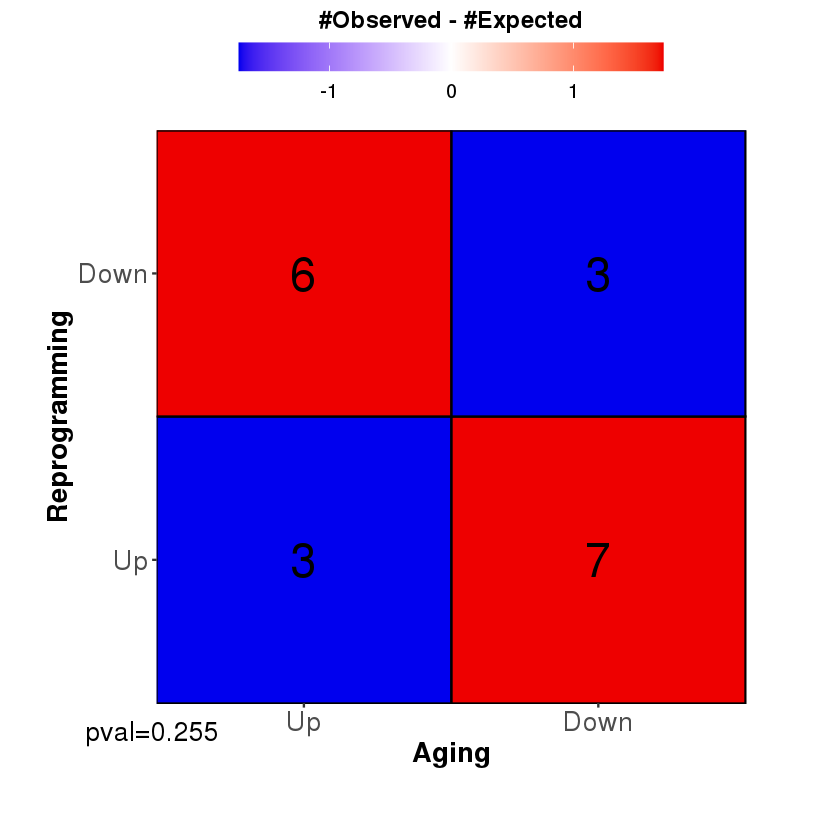

In [18]:
suf1 = 'Aging'
if (suf1 == 'Interventions'){
    sub <- subri[(subri$FDR.Interventions < 0.05) & (subri$FDR.Reprogramming < 0.05),]
}else{
    sub <- subra[(subra$FDR.Aging < 0.05) & (subra$FDR.Reprogramming < 0.05),]
}

col1 <- paste0('logFC', '.', suf1)
col2 <- paste0('logFC', '.', suf2)

urua <- length(sub[(sub[[col1]] > 0) & (sub[[col2]] > 0),]$Row.names)
urda <- length(sub[(sub[[col1]] < 0) & (sub[[col2]] > 0),]$Row.names)
drua <- length(sub[(sub[[col1]] > 0) & (sub[[col2]] < 0),]$Row.names)
drda <- length(sub[(sub[[col1]] < 0) & (sub[[col2]] < 0),]$Row.names)


if (all(c(urua, urda, drua, drda)) == T){
    #test for distribution randomness
    cont_table <- cbind(c(urua, drua), 
                        c(urda, drda))
    test <- chisq.test(cont_table)
    pval <- test$p.val
}

data <- as.matrix(test$observed)
#ex <- as.matrix(test$exprected)
rownames(data) <- c('Up', 'Down')
colnames(data) <- c('Up', 'Down')

suppressMessages(library(reshape2))
data <- melt(data)
colnames(data) <- c(suf1, suf2, 'value')
data$exp <- melt(test$expected)$value
data$OE <- data$value - data$exp
mindata <- min(data$OE)
maxdata <- max(data$OE)
avgdata <- mean(c(mindata, maxdata)) #exp(mean(log(data$value))) 
pval = format.pval(test$p.value, digits = 3)

lims = c()
if (length(lims) == 0){
lims = c(mindata, maxdata)
}

library(reshape2)
library(scales)
#    options(repr.plot.width = 5, repr.plot.height = 5)
g <- ggplot(data, aes(x=data[[suf1]], y=data[[suf2]], fill=OE)) + 
        geom_tile(colour = "black", size=0.5) + 
        scale_x_discrete(expand=c(0,0)) + scale_y_discrete(expand=c(0,0)) + 
        geom_text(data=data, aes(label=value), size=10, col='black') + 
        labs(tag = paste0("pval=", pval), x=suf1, y=suf2) +
        scale_fill_gradient2(high="red2", low="blue2", mid='white', limits=lims, midpoint=avgdata)+
        guides(fill=guide_colorbar(title.position = "top", title='#Observed - #Expected')) + 
        theme(legend.position = "top", legend.key.width = unit(1.8, "cm"),
                axis.text=element_text(size=16), axis.title=element_text(size=16, face="bold"),
                legend.text=element_text(size=12), 
                legend.title=element_text(size=14, face="bold"), 
                legend.title.align=0.5,
                plot.tag.position = c(0.15, 0.05), plot.tag = element_text(size=16),
                plot.margin = unit(c(0.,2.0, 1.5, 1.0), "cm")) 
g

### aggregation of gsea

In [26]:
gsea <- readRDS('gsea_results/fgsea_results_All.rds')

In [45]:
#combine list of signatures into list of dataframes where each dataframe is the same column type
SLR <- list()
SLI <- list()
SLA <- list()
cols <- c('pathway', 'pval', 'NES')

for (col in cols){
    SLR[[col]] <- data.frame(row.names=gsea[['Reprogramming:Mouse']]$pathway)
    SLI[[col]] <- data.frame(row.names=gsea[['Interventions:Median_lifespan']]$pathway)
    SLA[[col]] <- data.frame(row.names=gsea[['Aging:Brain']]$pathway)
    for (name in names(gsea)){
        tmp <- gsea[[name]][col]
        rownames(tmp) <- gsea[[name]]$pathway
        colnames(tmp) <- c(name)
        if (grepl("Aging", name, fixed=T)){    
            SLA[[col]] <- transform(merge(SLA[[col]], tmp, 
                                                by=0, sort=F,), 
                                                row.names=Row.names, Row.names=NULL)
        }else if (grepl("Interventions", name, fixed=T)){
            SLI[[col]] <- transform(merge(SLI[[col]], tmp, 
                                                by=0, sort=F,), 
                                                row.names=Row.names, Row.names=NULL)
        }else{
            SLR[[col]] <- transform(merge(SLR[[col]], tmp, 
                                    by=0, sort=F,), 
                                    row.names=Row.names, Row.names=NULL) 
        }
    }
}

slr <- data.frame(apply(SLR[['pval']], 1, function(x) exp(mean(log(x)))))
colnames(slr) <- c('P.Value')
slr$FDR <- p.adjust(slr$P.Value, method="BH")

sli <- data.frame(apply(SLI[['pval']], 1, function(x) exp(mean(log(x)))))
colnames(sli) <- c('P.Value')
sli$FDR <- p.adjust(sli$P.Value, method="BH")

sla <- data.frame(apply(SLA[['pval']], 1, function(x) exp(mean(log(x)))))
colnames(sla) <- c('P.Value')
sla$FDR <- p.adjust(sla$P.Value, method="BH")


sla

P.Value     
GOBP_ACETYL_COA_BIOSYNTHETIC_PROCESS                                                        0.0588704749
GOBP_ACETYL_COA_METABOLIC_PROCESS                                                           0.0754729931
GOBP_ACIDIC_AMINO_ACID_TRANSPORT                                                            0.3290521633
GOBP_ACTIN_CYTOSKELETON_REORGANIZATION                                                      0.0232444724
GOBP_ACTIN_FILAMENT_BASED_MOVEMENT                                                          0.0622661876
GOBP_ACTIN_FILAMENT_BASED_PROCESS                                                           0.0075516236
GOBP_ACTIN_FILAMENT_BASED_TRANSPORT                                                         0.3270242126
GOBP_ACTIN_FILAMENT_BUNDLE_ORGANIZATION                                                     0.0105458885
GOBP_ACTIN_FILAMENT_DEPOLYMERIZATION                                                        0.0237963298
GOBP_ACTIN_FILAMENT_ORGANIZATION                                                            0.0072873671
GOBP_ACTIN_MEDIATED_CELL_CONTRACTION                                                        0.1194485851
GOBP_ACTIN_NUCLEATION                                                                       0.0924522877
GOBP_ACTIN_POLYMERIZATION_OR_DEPOLYMERIZATION                                               0.0112646799
GOBP_ACTION_POTENTIAL                                                                       0.1816612795
GOBP_ACTIVATED_T_CELL_PROLIFERATION                                                         0.1537182521
GOBP_ACTIVATION_OF_CYSTEINE_TYPE_ENDOPEPTIDASE_ACTIVITY_INVOLVED_IN_APOPTOTIC_PROCESS       0.0362114204
GOBP_ACTIVATION_OF_GTPASE_ACTIVITY                                                          0.2151190939
GOBP_ACTIVATION_OF_IMMUNE_RESPONSE                                                          0.0016937731
GOBP_ACTIVATION_OF_INNATE_IMMUNE_RESPONSE                                                   0.0573175478
GOBP_ACTIVATION_OF_JUN_KINASE_ACTIVITY                                                      0.2405441885
GOBP_ACTIVATION_OF_MAPK_ACTIVITY                                                            0.0934560859
GOBP_ACTIVATION_OF_MAPKK_ACTIVITY                                                           0.4728734465
GOBP_ACTIVATION_OF_PROTEIN_KINASE_ACTIVITY                                                  0.0270909465
GOBP_ACTIVATION_OF_PROTEIN_KINASE_B_ACTIVITY                                                0.2654948483
GOBP_ACTIVIN_RECEPTOR_SIGNALING_PATHWAY                                                     0.3093637440
GOBP_ACTOMYOSIN_STRUCTURE_ORGANIZATION                                                      0.0373356656
GOBP_ACUTE_INFLAMMATORY_RESPONSE                                                            0.0155857779
GOBP_ACUTE_PHASE_RESPONSE                                                                   0.0668205243
GOBP_ACYLGLYCEROL_HOMEOSTASIS                                                               0.3416922433
GOBP_ADAPTIVE_IMMUNE_RESPONSE                                                               0.0008174353
⋮                                                                                           ⋮           
REACTOME_TRANSLATION                                                                        0.007991059 
REACTOME_TRANSLATION_OF_SARS_COV_1_STRUCTURAL_PROTEINS                                      0.325880041 
REACTOME_TRANSLATION_OF_SARS_COV_2_STRUCTURAL_PROTEINS                                      0.286682413 
REACTOME_TRANSLESION_SYNTHESIS_BY_Y_FAMILY_DNA_POLYMERASES_BYPASSES_LESIONS_ON_DNA_TEMPLATE 0.356225437 
REACTOME_TRANSLOCATION_OF_SLC2A4_GLUT4_TO_THE_PLASMA_MEMBRANE                               0.143670958 
REACTOME_TRANSMISSION_ACROSS_CHEMICAL_SYNAPSES                                              0.036218144 
REACTOME_TRANSPORT_OF_BILE_SALTS_AND_ORGANIC_ACIDS_METAL_IONS_AND_AMINE_COMPOUNDS           0.36624879

## Correlation of reprogramming signature with datasets

In [59]:
tmp_sub <- combined_datasets_list[c('Reprogramming', 'GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
                                'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
                                'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
                                'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
                                'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
                                'GSE127927$7F-Sall4', 'GSE127927$7F', 
                                'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1')]

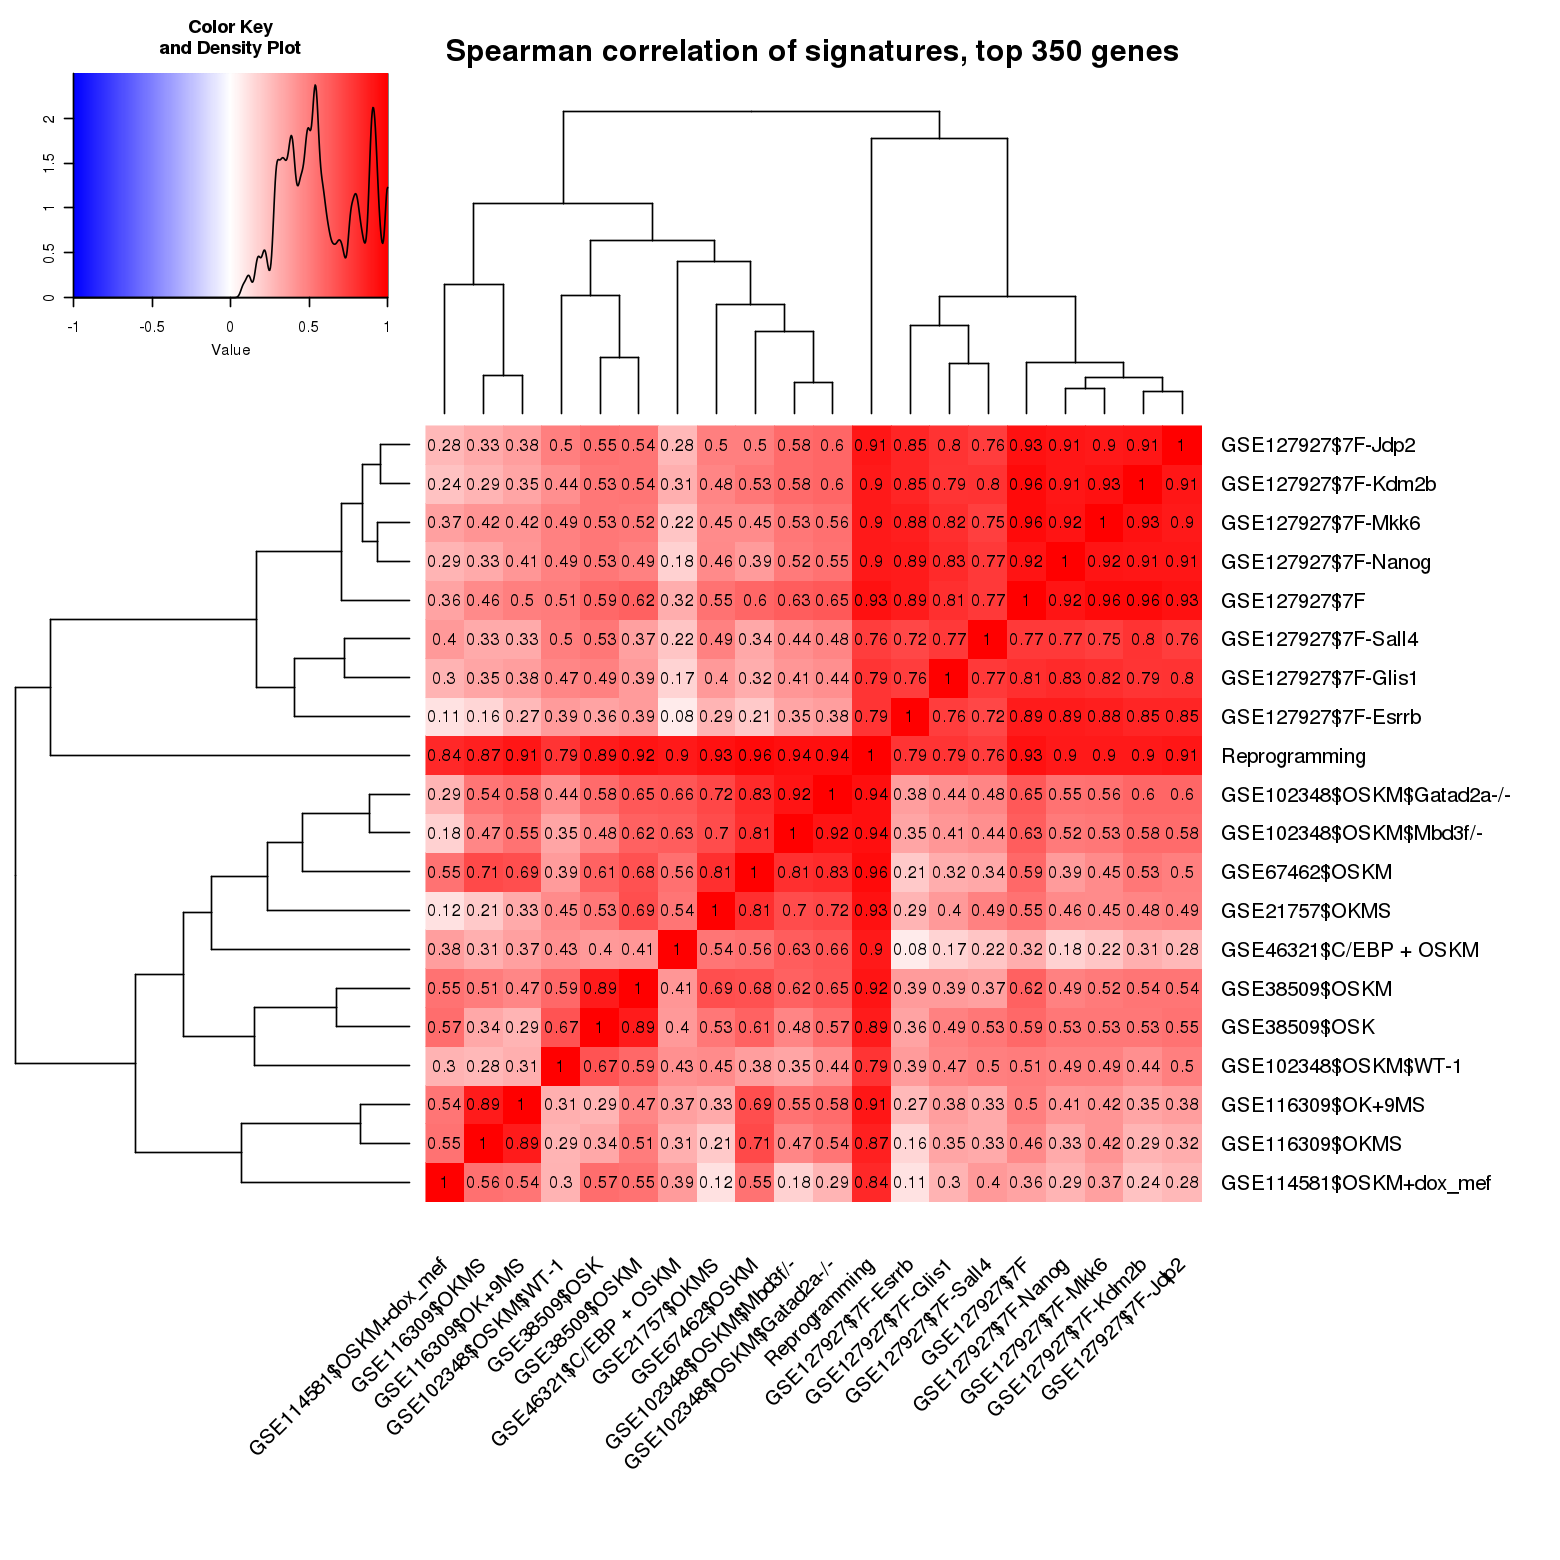

In [60]:
#datasets + signature
corres <- suppressMessages(corplot(tmp_sub, 
                type='pairwise_top', method='spearman', top=350, 
                value_size=1.0, title='Spearman correlation of signatures, top 350 genes'))

## Significant genes in signatures

In [15]:
names(combined_full_rep)

[1] "Reprogramming:Mouse"           "Reprogramming:Human"          
 [3] "Reprogramming:All"             "Interventions:Median_lifespan"
 [5] "Interventions:Max_lifespan"    "Interventions:CR"             
 [7] "Interventions:GH_deficiency"   "Interventions:Rapamycin"      
 [9] "Interventions:Common_liver"    "Aging:Brain"                  
[11] "Aging:Muscle"                  "Aging:Liver"                  
[13] "Aging:All"                     "Aging:Human"                  
[15] "Aging:Rat"                     "Aging:Mouse"

In [3]:
#combine list of signatures into list of dataframes where each dataframe is the same column type
SL <- list()
cols <- c('logFC', 'SE', 'P.Value', 'FDR')

for (col in cols){
    SL[[col]] <- data.frame(row.names=rownames(combined_full_rep[[1]]))
    for (name in names(combined_full_rep)){
            tmp <- combined_full_rep[[name]][col]
            colnames(tmp) <- c(name)
            SL[[col]] <- transform(merge(SL[[col]], tmp, all = TRUE,
                                                by=0, sort=F,), 
                                                row.names=Row.names, Row.names=NULL)
    }
}


### particular genes

In [4]:
top <- 5
gmean <- function(x) exp(mean(log(x)))
gm = as.data.frame(list('gmean'=apply(SL[['P.Value']], 1, gmean )))
gm <- rownames(gm[order(gm$gmean),, drop=FALSE])[1:top]

In [5]:
types <- c(rep('Reprogramming',3), rep('Interventions',6), rep('Aging', 7))

asub <- SL[['FDR']][, types=='Aging']
GM <- as.vector(apply(asub, 1, gmean))
asub <- (GM < 0.05)
#asub <- as.vector(apply((GM < 0.05), 1, all))

isub <- SL[['FDR']][, types=='Interventions']
GM <- as.vector(apply(isub, 1, gmean))
isub <- (GM < 0.05)
#isub <- as.vector(apply((GM < 0.05), 1, all))

rsub <- SL[['FDR']][, types=='Reprogramming']
GM <- as.vector(apply(rsub, 1, gmean))
rsub <- (GM < 0.05)
#rsub <- as.vector(apply((GM < 0.05), 1, all))

direction_cond <- asub & isub & rsub

In [6]:
cond <- SL[['FDR']][as.vector(apply((
                                    direction_cond & 
                                    (SL[['FDR']] < 1.0)
                                    ), 1, all)),]
cond_filt <- cond[order(cond$Reprogramming.Mouse),]
accepted <- rownames(cond_filt)
length(accepted)

[1] 10636

In [15]:
SL[['logFC']][g,]

Reprogramming.Mouse Reprogramming.Human Reprogramming.All
13436 2.894651            4.195398            3.696735         
      Interventions.Median_lifespan Interventions.Max_lifespan Interventions.CR
13436 0.04413691                    0.01074905                 -0.3352233      
      Interventions.GH_deficiency Interventions.Rapamycin
13436 -0.003928172                -0.03153587            
      Interventions.Common_liver Aging.Brain Aging.Muscle Aging.Liver
13436 -0.3942723                 -0.02963876 -0.01947945  -0.3953453 
      Aging.All   Aging.Human Aging.Rat  Aging.Mouse 
13436 -0.03276389 0.1895444   -0.5241394 -0.003543827

[1] "209011"


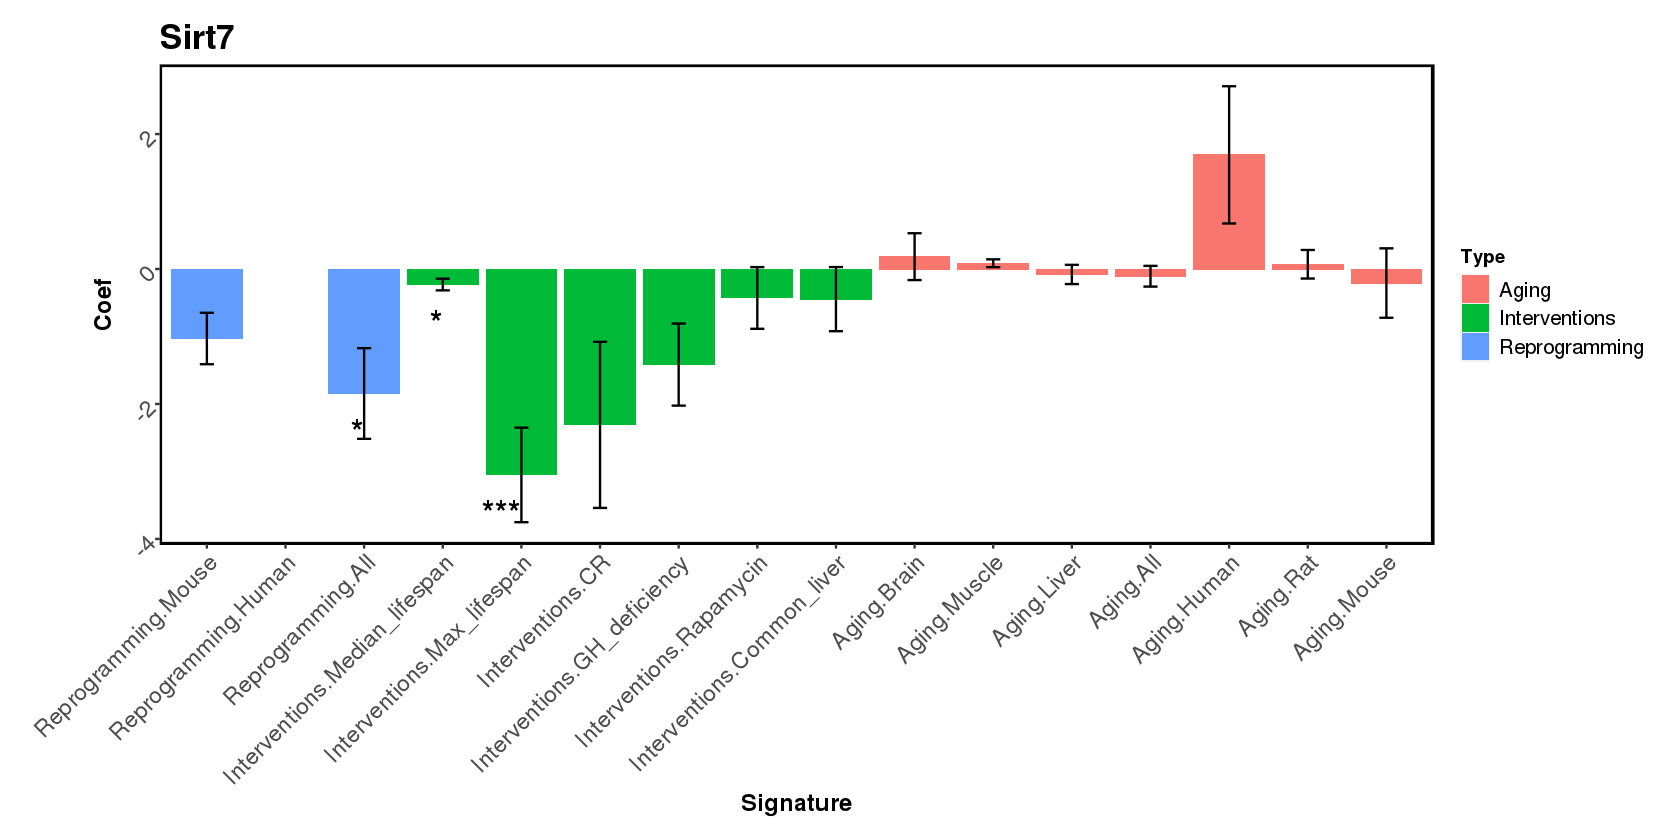

In [19]:
#g <- rownames(SL[['FDR']][order(SL[['FDR']]$Reprogramming),][17,])#gm[[1]]
tdat <- combined_full_rep[[1]]
tdat <- tdat[tdat$symbol == 'Sirt7',]
g <- rownames(tdat[complete.cases(tdat),])[[1]]
print(g)
#g <- accepted[2]
#g <- gm[[1]]

sym <- combined_full_rep[[1]][g,]$symbol
plab <- function(p )ifelse(p<0.001,'***', ifelse(p<0.01,'**', ifelse(p<0.05,'*',''))) #func for mapping stars

#rescale columns
tmpLogFC = SL[['logFC']] / apply(SL[['logFC']], 2, sd, na.rm=TRUE)
tmpSE = SL[['SE']] / apply(SL[['logFC']], 2, sd, na.rm=TRUE)

mel <- transform(merge(t(tmpLogFC[g,]), t(tmpSE[g,]), by=0, sort=F), row.names=Row.names, Row.names=NULL)
mel <- merge(mel,  t(SL[['FDR']][g,]), by=0, sort=F)
colnames(mel) <- c('Signature', 'Coef', 'SE', 'FDR')
mel$Type <- types
mel$Signature <- factor(as.character(mel$Signature), levels=unique(as.character(mel$Signature)))
mel$Star <- plab(mel$FDR)
mel$Vjust <- if_else(mel$Coef > 0, -0.7, 2)

#plot
#suppressMessages(library(ggrepel))
options(repr.plot.width = 14, repr.plot.height = 7)
p <- ggplot(mel, aes(x=Signature, y=Coef, fill=Type))+ 
        ggtitle(sym) +
        geom_bar(stat="identity") +
        geom_text(aes(label=Star, vjust=mel$Vjust, hjust='right'), fontface='bold', size=7)+
        geom_errorbar(aes(ymin=Coef-SE, ymax=Coef+SE), width=0.18) + 
        theme(axis.text=element_text(size=14, angle=45, hjust=1),
                axis.title=element_text(size=14, face="bold"), 
                plot.title=element_text(size = 20, face = "bold"),
                legend.title=element_text(size=11, face = "bold"),
                legend.text=element_text(size=12),
                panel.background = element_rect(fill='white', colour='black', size=1.1, linetype='solid'),
                panel.grid.major = element_blank(),
                panel.grid.minor = element_blank(),
                plot.margin = unit(c(0.5,0.5,0.5,2.0), "cm"))
p

## fGSEA

In [25]:
# data_name <- 'GSE127927$7F'
# clusters <- fromJSON(paste0("tmp/", data_name, "_genes.json"))

In [41]:
fgsea_results <- list()

for (name in names(combined_full_rep)){
    signature <- combined_full_rep[[name]]
    #signature['ES'] <- -log10(signature$P.Value) * sign(signature$logFC) #PVALUEEEE
    ranked_list <- cbind(entrez = rownames(signature), signature['ES'])   
    fgsea <- Run_functional_GSEA(ranked_list, species="Mus musculus", type="Entrez", 
                           n_permutations=10000, min_size=15, max_size=1000, with_MF=F,
                           ontologies_list=F, 
                           ontologies_dict=F)
    fgsea_results[[name]] <- as.data.frame(fgsea)
}

In [42]:
saveRDS(fgsea_results, 'fgsea_results_All_hallmarks.rds')


In [22]:

fgsea_results[[1]][grepl("HALLMARK", fgsea_results[[1]]$pathway),]

pathway                                    pval         padj       
4264 HALLMARK_ADIPOGENESIS                      0.3068987750 0.483941904
4265 HALLMARK_ALLOGRAFT_REJECTION               0.0027516293 0.017337145
4266 HALLMARK_ANDROGEN_RESPONSE                 0.4421036678 0.604627315
4267 HALLMARK_ANGIOGENESIS                      0.0229071922 0.085074803
4268 HALLMARK_APICAL_JUNCTION                   0.0007240081 0.006264495
4269 HALLMARK_APICAL_SURFACE                    0.6980313647 0.794385828
4270 HALLMARK_APOPTOSIS                         0.0056480380 0.029899470
4271 HALLMARK_BILE_ACID_METABOLISM              0.0008748906 0.007180853
4272 HALLMARK_CHOLESTEROL_HOMEOSTASIS           0.0648648649 0.173684624
4273 HALLMARK_COAGULATION                       0.0072278271 0.036054409
4274 HALLMARK_COMPLEMENT                        0.0160846254 0.065854519
4275 HALLMARK_DNA_REPAIR                        0.0049064704 0.027278989
4276 HALLMARK_E2F_TARGETS                       0.0003223727 0.004041343
4277 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.0001448855 0.003929619
4278 HALLMARK_ESTROGEN_RESPONSE_EARLY           0.0235332044 0.086158628
4279 HALLMARK_ESTROGEN_RESPONSE_LATE            0.0229773463 0.085193101
4280 HALLMARK_FATTY_ACID_METABOLISM             0.2081155856 0.381097458
4281 HALLMARK_G2M_CHECKPOINT                    0.0003223727 0.004041343
4282 HALLMARK_GLYCOLYSIS                        0.1717391304 0.335974405
4283 HALLMARK_HEDGEHOG_SIGNALING                0.6685194543 0.774502538
4284 HALLMARK_HEME_METABOLISM                   0.0362266338 0.116379639
4285 HALLMARK_HYPOXIA                           0.0141885044 0.059552964
4286 HALLMARK_IL2_STAT5_SIGNALING               0.0059368665 0.031071661
4287 HALLMARK_IL6_JAK_STAT3_SIGNALING           0.0020261845 0.013702754
4288 HALLMARK_INFLAMMATORY_RESPONSE             0.0001449275 0.003929619
4289 HALLMARK_INTERFERON_ALPHA_RESPONSE         0.7150068839 0.806076642
4290 HALLMARK_INTERFERON_GAMMA_RESPONSE         0.7823580283 0.849467978
4291 HALLMARK_KRAS_SIGNALING_DN                 0.0598318241 0.163713535
4292 HALLMARK_KRAS_SIGNALING_UP                 0.1965267728 0.368163161
4293 HALLMARK_MITOTIC_SPINDLE                   0.1527657110 0.311844986
4294 HALLMARK_MTORC1_SIGNALING                  0.0934880722 0.225054837
4295 HALLMARK_MYC_TARGETS_V1                    0.0003223727 0.004041343
4296 HALLMARK_MYC_TARGETS_V2                    0.9582050867 0.973515251
4297 HALLMARK_MYOGENESIS                        0.0002895613 0.004041343
4298 HALLMARK_NOTCH_SIGNALING                   0.4799322608 0.635315929
4299 HALLMARK_OXIDATIVE_PHOSPHORYLATION         0.9193454967 0.946903610
4300 HALLMARK_P53_PATHWAY                       0.1555072464 0.316041913
4301 HALLMARK_PANCREAS_BETA_CELLS               0.5846387064 0.714615079
4302 HALLMARK_PEROXISOME                        0.3546949439 0.528317832
4303 HALLMARK_PI3K_AKT_MTOR_SIGNALING           0.0052011626 0.028403585
4304 HALLMARK_PROTEIN_SECRETION                 0.0001542020 0.003929619
4305 HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY   0.3043621399 0.480894582
4306 HALLMARK_SPERMATOGENESIS                   0.0002984184 0.004041343
4307 HALLMARK_TGF_BETA_SIGNALING                0.0169657423 0.068657269
4308 HALLMARK_TNFA_SIGNALING_VIA_NFKB           0.0005797101 0.005417156
4309 HALLMARK_UNFOLDED_PROTEIN_RESPONSE         0.0001525553 0.003929619
4310 HALLMARK_UV_RESPONSE_DN                    0.0001500150 0.003929619
4311 HALLMARK_UV_RESPONSE_UP                    0.7629431835 0.837088792
4312 HALLMARK_WNT_BETA_CATENIN_SIGNALING        0.7204823313 0.809116577
4313 HALLMARK_XENOBIOTIC_METABOLISM             0.0847896440 0.208933769
     ES         NES        nMoreExtreme size
4264  0.2674422  1.0468091  951         200 
4265 -0.3996576 -1.4537199   18         204 
4266 -0.2935968 -1.0082076 2916         125 
4267 -0.5428197 -1.5278567  135          36 
4268 -0.4316080 -1.5664222    4         199 
4269 -0.2949

In [199]:
# tmp <- fgsea_results[["Reprogramming"]]
# ontolist <- tmp[tmp$padj < 0.05,]$pathway

In [3]:
fgsea_results <-readRDS("fgsea_results_All.rds")
#gsea_rep <- fgsea_results[['Reprogramming']]
#saveRDS(fgsea_results, "fgsea_results_ds19_full_genes.rds")

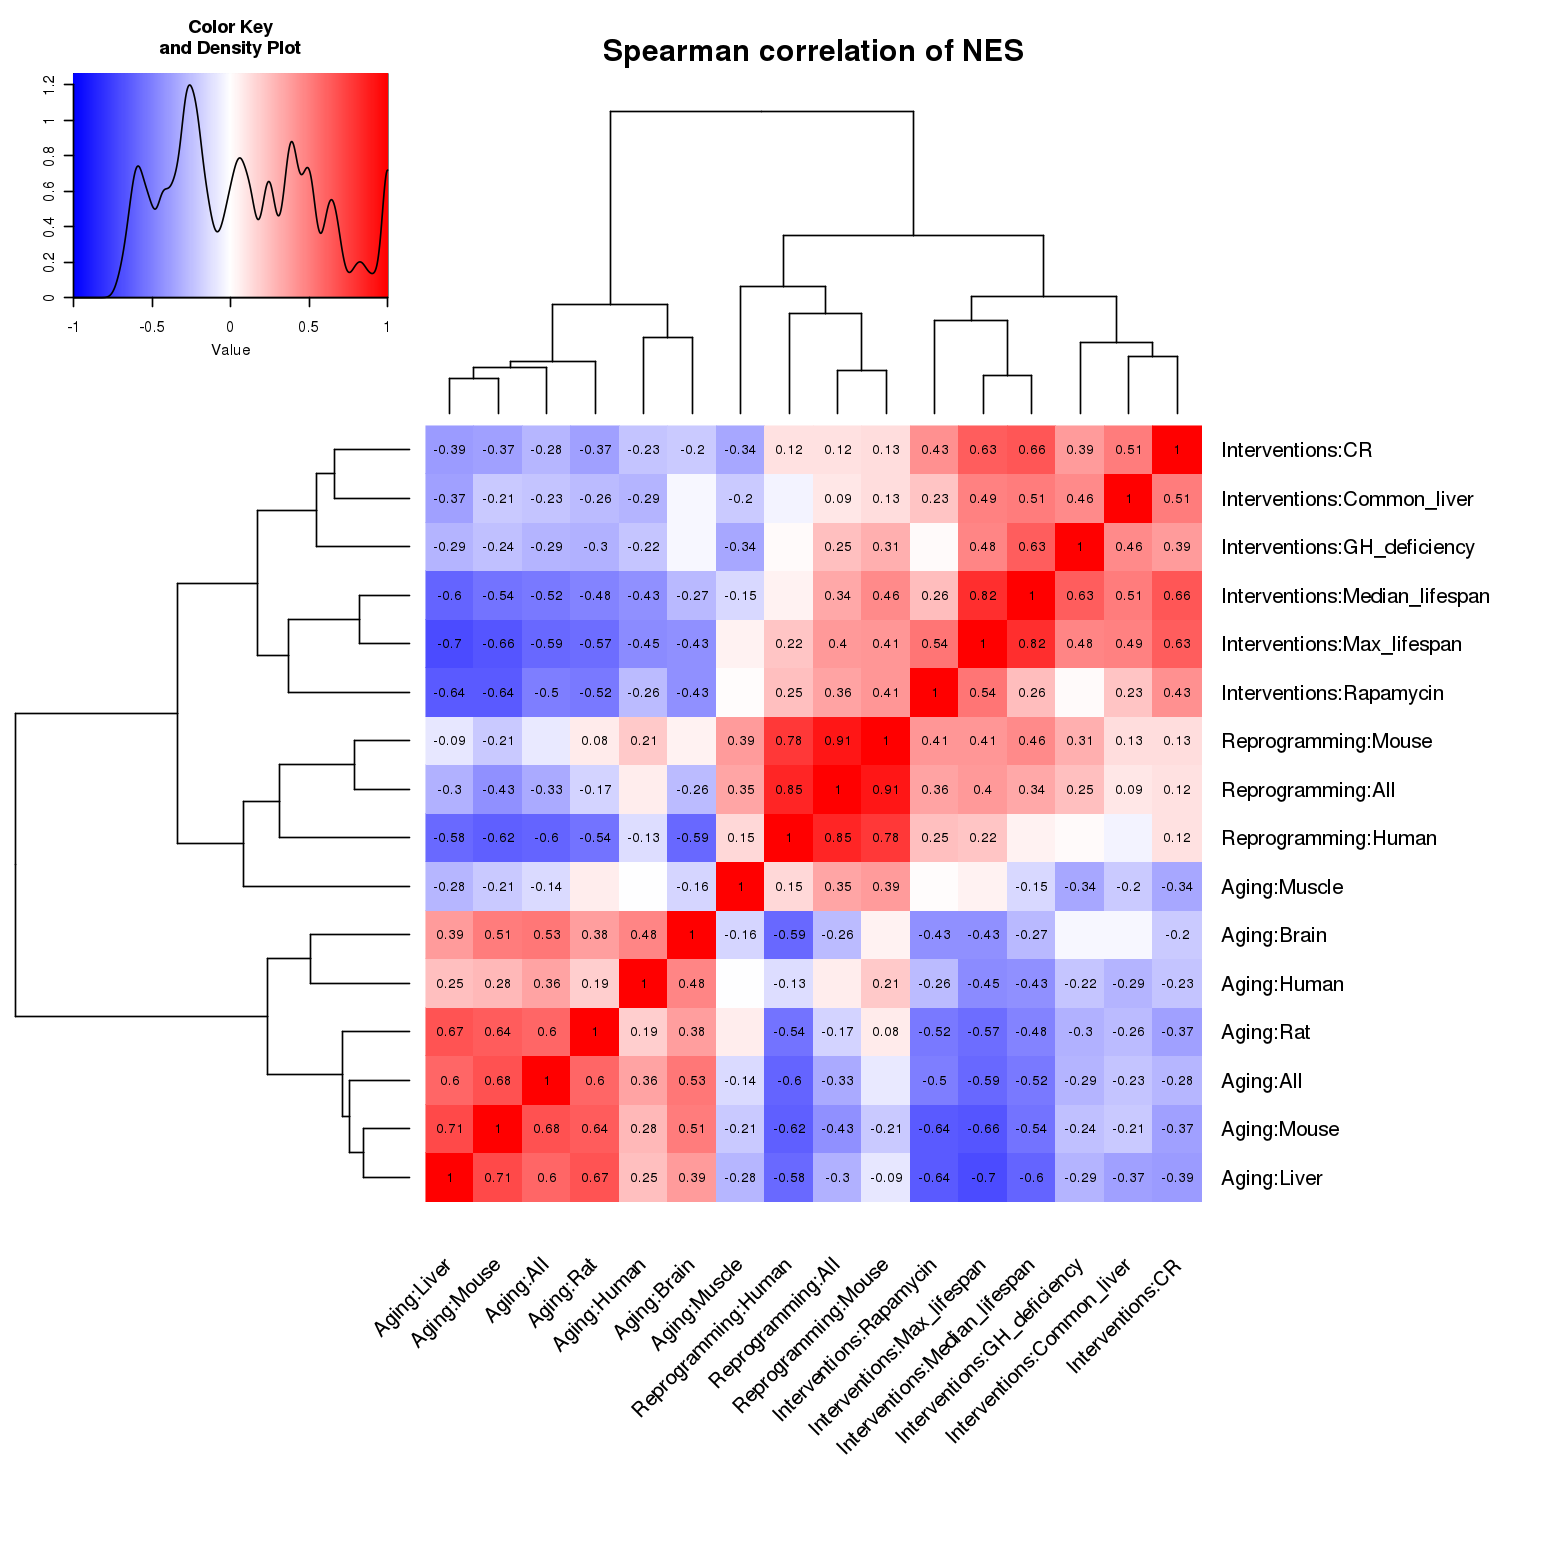

In [26]:
for (name in names(fgsea_results)){
    fgsea_results[[name]] <- as.data.frame(fgsea_results[[name]])
    rownames(fgsea_results[[name]]) <- fgsea_results[[name]]$pathway
}

corres <- suppressMessages(corplot(fgsea_results, type='pairwise_top', method='spearman', top=350, pvplot=F,
                    label_size=1.2, value_size=0.8, title="Spearman correlation of NES",
                    measure="NES", criterion="padj"))

In [47]:
names(fgsea_results)

[1] "Reprogramming:Mouse"           "Reprogramming:Human"          
 [3] "Reprogramming:All"             "Interventions:Median_lifespan"
 [5] "Interventions:Max_lifespan"    "Interventions:CR"             
 [7] "Interventions:GH_deficiency"   "Interventions:Rapamycin"      
 [9] "Interventions:Common_liver"    "Aging:Brain"                  
[11] "Aging:Muscle"                  "Aging:Liver"                  
[13] "Aging:All"                     "Aging:Human"                  
[15] "Aging:Rat"                     "Aging:Mouse"

In [110]:
# ff <- fgsea_results[c('Reprogramming', 'Interventions:Median_lifespan', 
#                       'Interventions:Max_lifespan', 'Interventions:CR',
#                       'Interventions:GH_deficiency', 'Interventions:Rapamycin', 
#                        'Aging:Mouse', 'Aging:Human', 'Aging:Rat')]

ff <- fgsea_results
terms <- lapply(ff, "[[", "pathway")
terms_list <- Reduce(intersect, terms)

tmp <- fgsea_results[['Reprogramming:All']]
tmp <- tmp[tmp$padj < 0.05,] #filter
# tmp <- tmp[order(tmp$padj),][1:top, ] #top #[tmp$NES > 0,]

terms_list <- intersect(terms_list, tmp$pathway)
length(terms_list)

[1] 1030

In [111]:
#terms_list <- intersect(fgsea_passed$pathway, terms_list) return empty set
top <- 8
term_sub <- tmp[tmp$pathway %in% terms_list,]
fgsea_passed_pos <- term_sub[term_sub$NES > 0,]
fgsea_passed_pos <- fgsea_passed_pos[order(fgsea_passed_pos$pval), ][1:top,]  
fgsea_passed_neg <- term_sub[term_sub$NES < 0,]
fgsea_passed_neg <- fgsea_passed_neg[order(fgsea_passed_neg$pval), ][1:top,]
fgsea_passed <- rbind(fgsea_passed_pos, fgsea_passed_neg)

terms_list <- fgsea_passed$pathway


In [112]:
terms_list

[1] "REACTOME_PROCESSIVE_SYNTHESIS_ON_THE_C_STRAND_OF_THE_TELOMERE"   
 [2] "GOBP_NEGATIVE_REGULATION_OF_TELOMERE_MAINTENANCE_VIA_TELOMERASE" 
 [3] "GOBP_NEGATIVE_REGULATION_OF_HISTONE_METHYLATION"                 
 [4] "REACTOME_PCNA_DEPENDENT_LONG_PATCH_BASE_EXCISION_REPAIR"         
 [5] "GOBP_PROTEIN_LOCALIZATION_TO_CHROMOSOME_CENTROMERIC_REGION"      
 [6] "REACTOME_CYCLIN_A_B1_B2_ASSOCIATED_EVENTS_DURING_G2_M_TRANSITION"
 [7] "GOBP_REGULATION_OF_SISTER_CHROMATID_COHESION"                    
 [8] "KEGG_MISMATCH_REPAIR"                                            
 [9] "GOBP_CELL_MORPHOGENESIS"                                         
[10] "GOBP_POSITIVE_REGULATION_OF_INTRACELLULAR_SIGNAL_TRANSDUCTION"   
[11] "GOBP_REGULATION_OF_ANATOMICAL_STRUCTURE_MORPHOGENESIS"           
[12] "GOBP_PROTEIN_CATABOLIC_PROCESS"                                  
[13] "GOBP_EXOCYTOSIS"                                                 
[14] "GOBP_MAPK_CASCADE"                                               
[15] "GOBP_MEMBRANE_ORGANIZATION"                                      
[16] "GOBP_POSITIVE_REGULATION_OF_PROTEIN_PHOSPHORYLATION"

In [54]:
#rownames(tmp)#[order(tmp$NES),][1:top, 1:7]
#subset(tmp, grepl("REPA", pathway))[, 1:7] #find all reparatin pathways

In [113]:
df <- c()

for (name in names(ff)){
    fgs <- as.data.frame(ff[[name]])
    rownames(fgs) <- fgs$pathway
    fgs <- fgs[terms_list,]
    tmp <- cbind(fgs[c("pathway", "NES", "size", "padj")], rep(name, nrow(fgs)))
    rownames(tmp) <- NULL
    colnames(tmp) <- c("Function", "NES", "Size", "P.adj", "Signature")
    df <- rbind(df, tmp)
}

df[df$P.adj > 0.05,]$Size =  NA_integer_
#df[df$P.adj > 0.05,]$NES =  NA_integer_

#formatting
df$Function <- gsub("_"," ", df$Function)
#df$Function <- gsub("HALLMARK ","", df$Function)
df$Function <- factor(df$Function, ordered=TRUE, levels=unique(df$Function))

In [103]:
selected_functions <- as.vector(df[(df$Signature == 'Reprogramming') & !is.na(df$Size),]$Function)

df <- df[df$Function %in% selected_functions,]

Loading required package: ggpubr



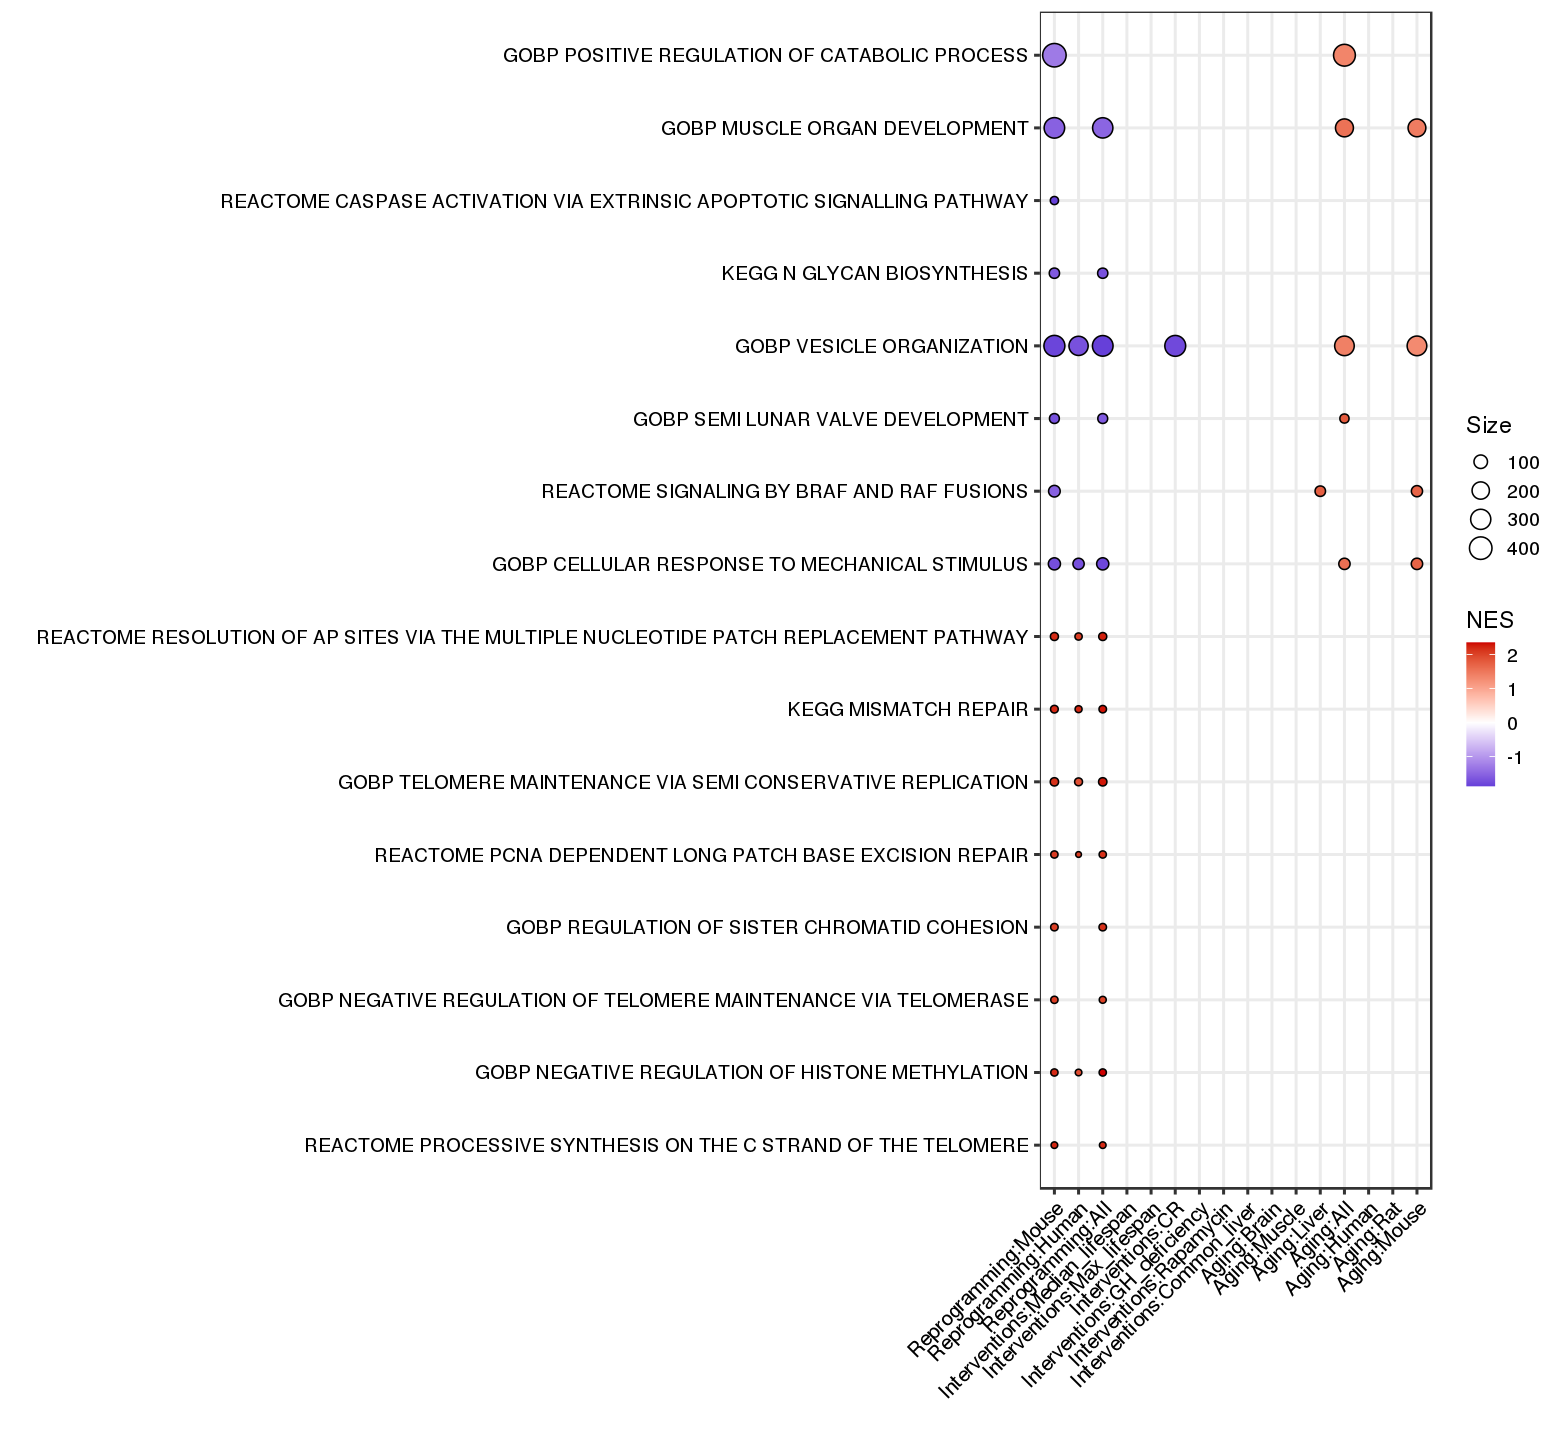

In [ ]:
options(repr.plot.width=13, repr.plot.height=12)
g <- ggplot(df, aes(Signature, Function)) + 
    #ggtitle(data_name) + 
    geom_point(aes(size=Size, fill=NES), shape=21, color="black") + 
    scale_fill_gradient2(high="red3", low="blue3",
                            mid='white',
                            guide = "colorbar"
                            #limits=c(-max_abs_score, max_abs_score),
                            #oob=squish)+
                        )+ 
                        labs(x = "",y = "") +
                #scale_x_discrete(expand = c(0, 0)) +scale_y_discrete(expand = c(0, 0)) +
                theme_bw(base_size = 14) +
     theme(axis.text.x = element_text(angle = 45, vjust = 1,hjust=1,size=12, colour="black"),
        axis.text.y = element_text(size=11,colour="black"),
        axis.title=element_text(size=11,colour="black"),)
    
g

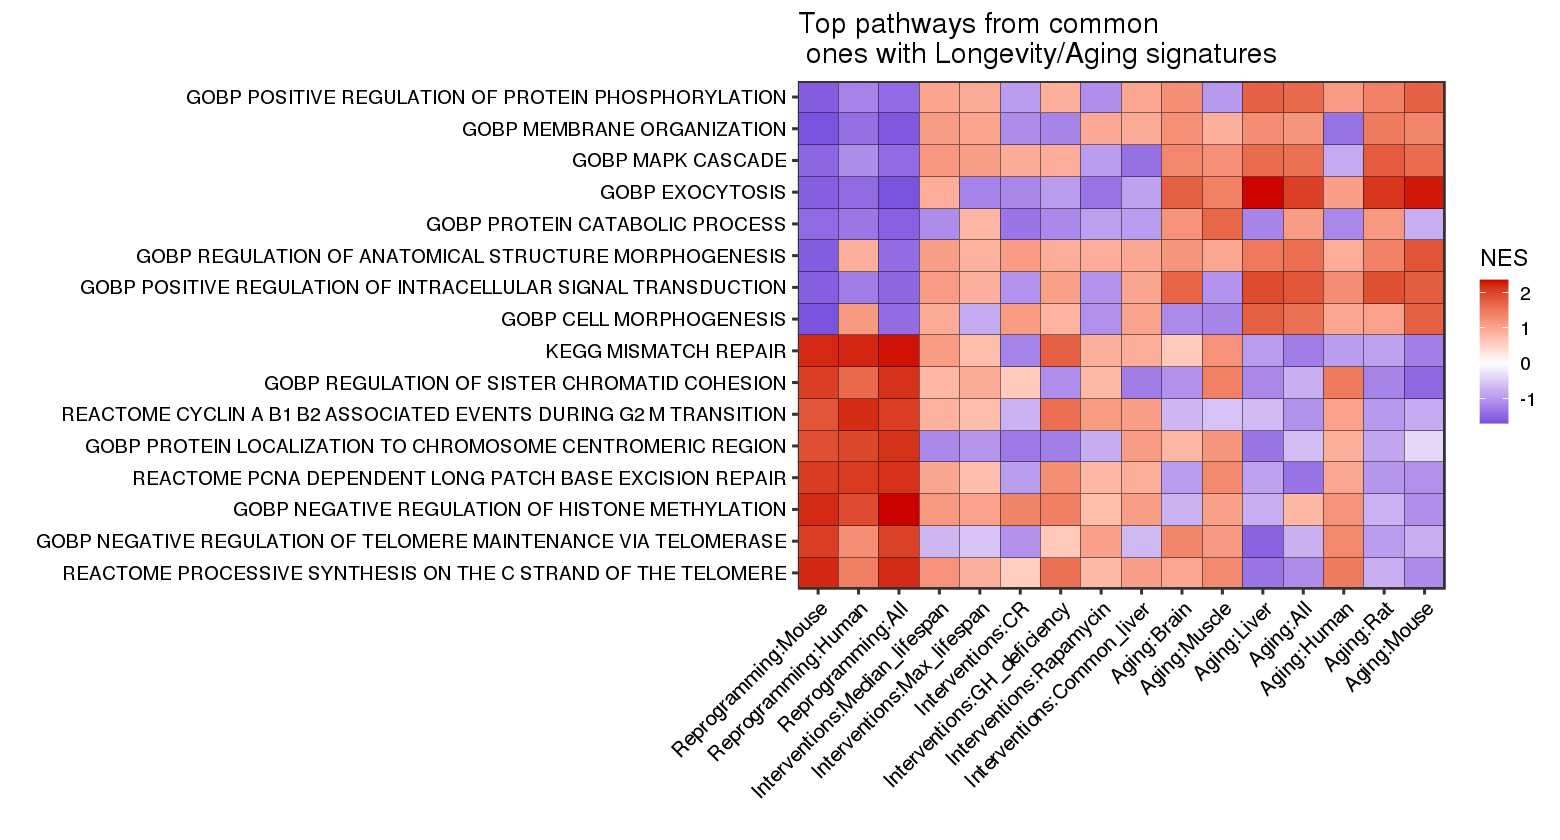

In [114]:
options(repr.plot.width=13, repr.plot.height=7)
g <- ggplot(df, aes(x=Signature, y=Function, fill=NES)) + 
    geom_tile(colour = "black",size=0.1)+
    scale_fill_gradient2(high="red3",low="blue3",
                            #mid=background_color,
                            guide = "colorbar",
                            #limits=c(-max_abs_score, max_abs_score),
                            #oob=squish)+
                        ) +
                    labs(x = "",y = "", title="Top pathways from common \n ones with Longevity/Aging signatures") +
                    scale_x_discrete(expand = c(0, 0)) +scale_y_discrete(expand = c(0, 0)) +
                    theme_bw(base_size = 14) +
        theme(axis.text.x = element_text(angle = 45, vjust = 1,hjust=1,size=12, colour="black"),
            axis.text.y = element_text(size=11,colour="black"),
            axis.title=element_text(size=11,colour="black"),
            panel.grid.major = element_line(colour="black"), panel.grid.minor = element_line(colour="black"))
g

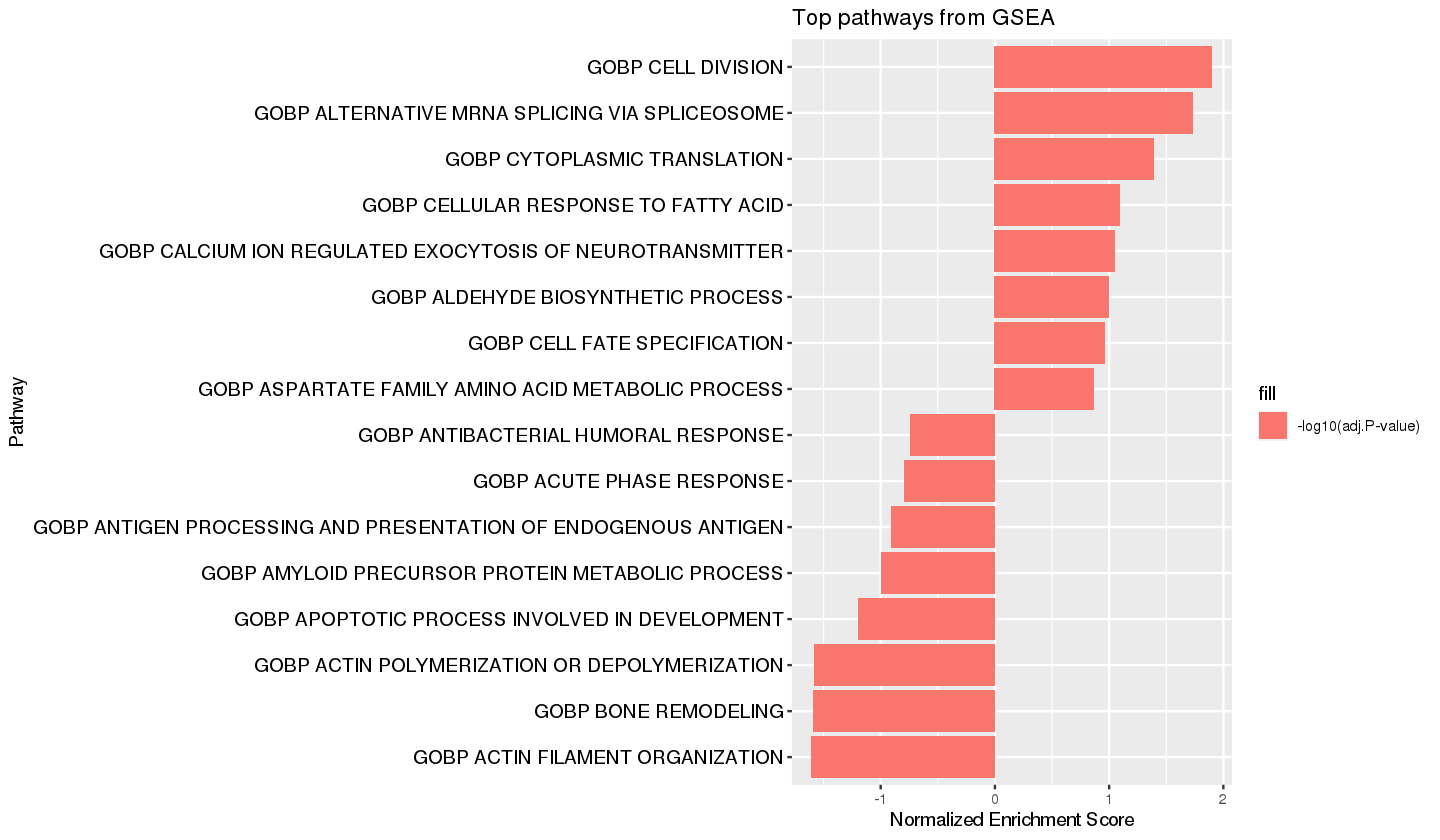

In [88]:
#build top GSEA terms for reprogramming signature
top <- 8

fgsea_rep <- fgsea_results[['Reprogramming:All']]
fgsea_rep[['-log10(adj.P-value)']] <- -log10(fgsea_rep$padj)
fgsea_passed_pos <- fgsea_rep[fgsea_rep$NES > 0,][order(fgsea_rep$padj), ][1:top,]  
fgsea_passed_neg <- fgsea_rep[fgsea_rep$NES < 0,][order(fgsea_rep$padj), ][1:top,]

fgsea_passed <- rbind(fgsea_passed_pos, fgsea_passed_neg)
fgsea_passed$pathway <- gsub("_"," ", fgsea_passed$pathway)

#plot
options(repr.plot.width=12, repr.plot.height=7)
ggplot(fgsea_passed, aes(reorder(pathway, NES), NES)) +
     geom_col(aes(fill='-log10(adj.P-value)')) +
     coord_flip() +
     labs(x="Pathway", 
          y="Normalized Enrichment Score",
          title="Top pathways from GSEA") + 
     theme(axis.text.y = element_text(size=11,colour="black"))

## Special functions

In [430]:
#length(Deming_output[[1]][["Normalized_data"]])

[1] 14

In [10]:
# construct compounds_zscore_matrix = CZM
deming_data <- Deming_output[[1]][["Normalized_data"]]

CZM <- data.frame(row.names=rownames(deming_data[[1]]), tmp=rownames(deming_data[[1]]))

for (n in names(deming_data)){
    deming_data[[n]][n] <- -log10(deming_data[[n]]$FDR) * sign(deming_data[[n]]$logFC)
    CZM <- merge(CZM, deming_data[[n]][n], by="row.names", sort=FALSE)
    row.names(CZM) <- CZM$Row.names
    CZM <- CZM[, -1]
    
}
CZM <- CZM[, -1]

ERROR: Error in eval(expr, envir, enclos): object 'Deming_output' not found


In [5]:
# or use metafor results for CZM
reprog <- combined_full_rep[['Reprogramming:Mouse']]
reprog['Reprogramming:Mouse'] <- -log10(reprog$FDR) * sign(reprog$logFC)
CZM <- reprog['Reprogramming:Mouse']

In [87]:
# construct signatures genes list = SGL with top genes
top <- 200
SGL = list()

for (n in names(age)){
    sub <- age[[n]] #[complete.cases(age[[n]]),]
    sub_up <- sub[sub$logFC >= 0,]
    sub_dw <-sub[sub$logFC < 0,]
    if (length(sub_up) > 0){
        SGL[[n]]$Up <- sub_up[order(sub_up$P.Value),][1:top,]$Entrez
        SGL[[n]]$Down <- sub_dw[order(sub_dw$P.Value),][1:top,]$Entrez
        cat(n, "up:", length(SGL[[n]]$Up), "down:", length(SGL[[n]]$Down), '\n')
        }
}

Interventions:Median_lifespan up: 200 down: 200 
Interventions:Max_lifespan up: 200 down: 200 
Interventions:CR up: 200 down: 200 
Interventions:GH_deficiency up: 200 down: 200 
Interventions:Rapamycin up: 200 down: 200 
Interventions:Common_liver up: 200 down: 200 
Aging:Brain up: 200 down: 200 
Aging:Muscle up: 200 down: 200 
Aging:Liver up: 200 down: 200 
Aging:All up: 200 down: 200 
Aging:Human up: 200 down: 200 
Aging:Rat up: 200 down: 200 
Aging:Mouse up: 200 down: 200 


In [7]:
# or just upload SGL
SGL <- source('Signatures_lists_aging_longevity.R')$value

In [8]:
str(SGL)

List of 13
 $ Interventions:Median_lifespan:List of 2
  ..$ Up  : chr [1:547] "11806" "13170" "16956" "13119" ...
  ..$ Down: chr [1:453] "277753" "20714" "68054" "13190" ...
 $ Interventions:Max_lifespan   :List of 2
  ..$ Up  : chr [1:539] "15496" "277753" "28248" "13170" ...
  ..$ Down: chr [1:461] "13089" "13190" "20714" "20208" ...
 $ Interventions:CR             :List of 2
  ..$ Up  : chr [1:493] "14262" "545670" "13119" "76487" ...
  ..$ Down: chr [1:507] "12686" "15957" "100689" "20208" ...
 $ Interventions:GH_deficiency  :List of 2
  ..$ Up  : chr [1:560] "20860" "13089" "94179" "56185" ...
  ..$ Down: chr [1:440] "15496" "28248" "66107" "16000" ...
 $ Interventions:Rapamycin      :List of 2
  ..$ Up  : chr [1:469] "19876" "17750" "17718" "216795" ...
  ..$ Down: chr [1:303] "237256" "27273" "74023" "67701" ...
 $ Interventions:Common_liver   :List of 2
  ..$ Up  : chr [1:91] "16008" "14860" "21743" "22390" ...
  ..$ Down: chr [1:77] "64385" "74558" "231655" "55927" ...
 $ Agi

In [10]:
function_path <- './post_functions/'
source(paste0(function_path, 'FUN.Association_test.R'))

In [ ]:
test_result <- Association_test(SGL,
                                 CZM,
                                 number_permutations=5000,
                                 function_path=function_path)

In [2]:
#saveRDS(test_result, "GSEA_result_special_case_7.rds")
test_result <- readRDS("GSEA_result_special_case_7.rds")

In [12]:
names(test_result)

[1] "GSEA"       "pvalue"     "Gene_table" "Top"        "Direction" 
[6] "NES_vector"

$p1

$p2


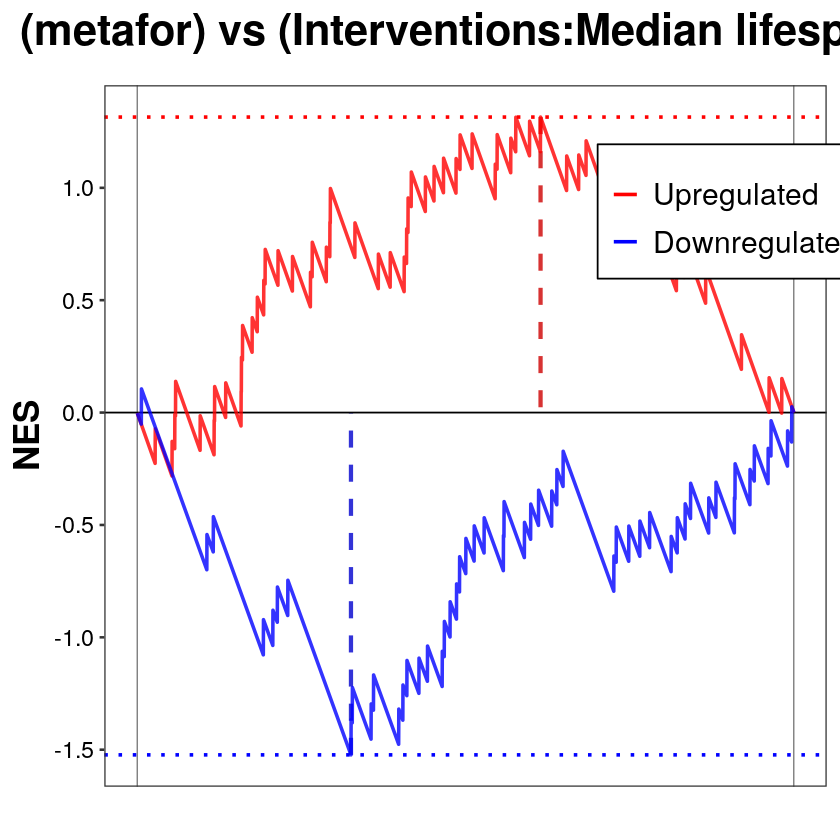

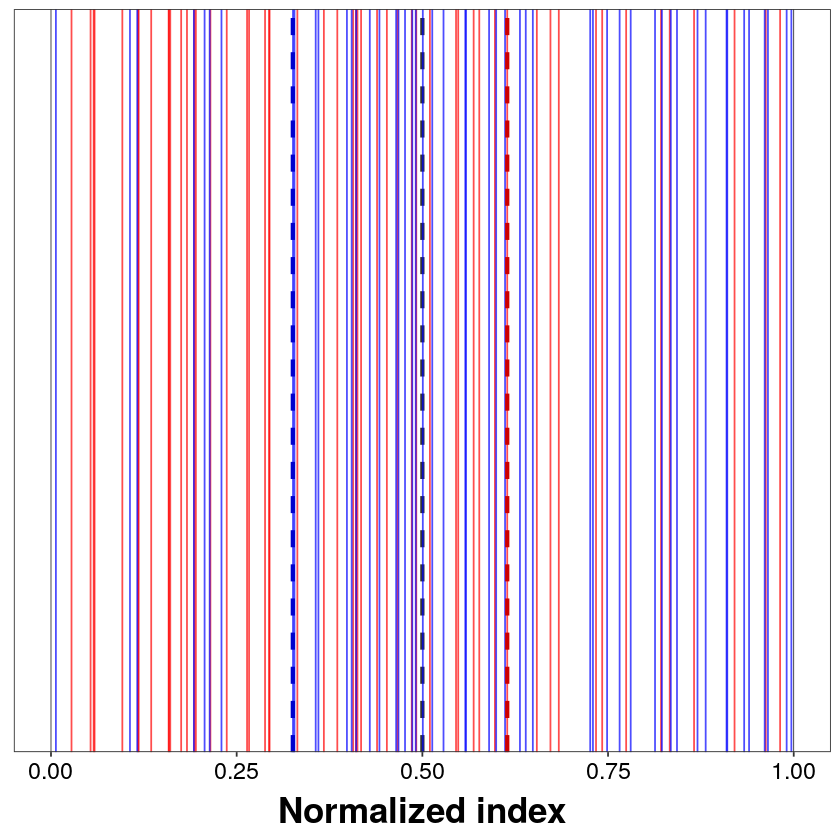

In [15]:
#NES vizualization
library(ggplot2)
source(paste0(function_path, 'FUN.NES_visualizer.R'))
NES_visualizer(test_output=test_result, 
               signature_name='Interventions:Median_lifespan', 
               intervention_name='metafor')               

In [34]:
test_result[['GSEA']]

Signature                     GSE67462$OSKM
Interventions:Median_lifespan Interventions:Median_lifespan  1.17424092  
Interventions:Max_lifespan    Interventions:Max_lifespan     1.59426364  
Interventions:CR              Interventions:CR               1.95818848  
Interventions:GH_deficiency   Interventions:GH_deficiency   -0.04205212  
Interventions:Rapamycin       Interventions:Rapamycin        1.51438482  
Interventions:Common_liver    Interventions:Common_liver     1.46132774  
Aging:Brain                   Aging:Brain                    1.81405569  
Aging:Muscle                  Aging:Muscle                   1.60161108  
Aging:Liver                   Aging:Liver                   -1.37243659  
Aging:All                     Aging:All                      0.01025170  
Aging:Human                   Aging:Human                    2.22478759  
Aging:Rat                     Aging:Rat                     -1.22600812  
Aging:Mouse                   Aging:Mouse                    0.31243586  
                              GSE38509$OSKM GSE38509$OSK GSE38509$GFP
Interventions:Median_lifespan  0.70190493    0.55895955  -0.74393359 
Interventions:Max_lifespan     0.82642968    0.27355830  -0.99779670 
Interventions:CR               0.03974743   -0.46853055  -2.57039580 
Interventions:GH_deficiency    0.56955712    0.56459186   0.23315163 
Interventions:Rapamycin       -0.26524501    1.55977929  -2.29175175 
Interventions:Common_liver     0.19458334    0.34184254  -1.53340215 
Aging:Brain                    2.10568477    1.71287172   2.45163686 
Aging:Muscle                  -0.02799559    0.05616272  -1.61551718 
Aging:Liver                   -0.20778740   -1.45096751   0.37667685 
Aging:All                     -0.97134068   -0.13222947   0.02019918 
Aging:Human                    0.96136674    0.11451058   1.35578353 
Aging:Rat                      0.14686961    0.47698534   0.58948887 
Aging:Mouse                    0.36700281   -0.38358432   0.10232275 
                              GSE116309$OKMS GSE116309$OK+9MS
Interventions:Median_lifespan  1.5974048      1.72250853     
Interventions:Max_lifespan     1.2687435      1.68024285     
Interventions:CR               1.6218034      2.56546577     
Interventions:GH_deficiency    1.6173821      1.62172317     
Interventions:Rapamycin       -1.0164799      1.75178983     
Interventions:Common_liver     1.3413373      1.12904874     
Aging:Brain                    2.7578207      0.13298104     
Aging:Muscle                  -1.2639053      0.14586728     
Aging:Liver                    1.7134703     -0.46320673     
Aging:All                     -0.9857938     -0.76314135     
Aging:Human                    2.3725353      1.61622185     
Aging:Rat                     -0.2449630     -1.20494278     
Aging:Mouse                    0.5495704      0.01552131     
                              GSE46321$C/EBPα+ OSKM GSE46321$C/EBPα- OSKM
Interventions:Median_lifespan  0.41695760           -0.65783687          
Interventions:Max_lifespan     1.50983425           -0.15016499          
Interventions:CR               0.71472969            0.31500730          
Interventions:GH_deficiency    0.17468214           -0.84488462          
Interventions:Rapamycin        0.93484107           -1.21594291          
Interventions:Common_liver    -0.89017022           -1.36507839          
Aging:Brain                   -0.51632660           -2.84643178          
Aging:Muscle                   1.51343049            0.35864997          
Aging:Liver                   -1.04080144           -2.28102054          
Aging:All                      0.13470880            0.15095565          
Aging:Human                    0.06074951            0.09350056          
Aging:Rat                     -1.32919808           -2.38492059          
Aging:Mouse                   -1.08684121           -1.64813050          
                              GSE10871$OSKM GSE21757$OKMS GSE103979$Oct4+SK
Interventions:Median_lifespan -0.1

In [16]:
test_result[['pvalue']]

Signature                     metafor
Interventions:Median_lifespan Interventions:Median_lifespan 0.0146 
Interventions:Max_lifespan    Interventions:Max_lifespan    0.0022 
Interventions:CR              Interventions:CR              0.4194 
Interventions:GH_deficiency   Interventions:GH_deficiency   0.0578 
Interventions:Rapamycin       Interventions:Rapamycin       0.0236 
Interventions:Common_liver    Interventions:Common_liver    0.6686 
Aging:Brain                   Aging:Brain                   0.8054 
Aging:Muscle                  Aging:Muscle                  0.3604 
Aging:Liver                   Aging:Liver                   0.0576 
Aging:All                     Aging:All                     0.0210 
Aging:Human                   Aging:Human                   0.5008 
Aging:Rat                     Aging:Rat                     0.3968 
Aging:Mouse                   Aging:Mouse                   0.0108

In [47]:
test_result[['Gene_table']][['Interventions:Median_lifespan']]$metafor$Up

Gene_name Index Significant
1  73167      113  Y          
2  76263      218  Y          
3  19193      235  Y          
4  14872      240  Y          
5  14860      393  Y          
6  246703     480  Y          
7  15929      483  Y          
8  72900      552  Y          
9  66333      648  Y          
10 17993      650  Y          
11 109145     657  Y          
12 56176      717  Y          
13 234309     749  Y          
14 66866      789  Y          
15 17210      798  Y          
16 107227     878  Y          
17 17319      968  Y          
18 18538     1080  Y          
19 66118     1091  Y          
20 64384     1179  Y          
21 101565    1201  Y          
22 30932     1204  Y          
23 73724     1357  Y          
24 353187    1503  Y          
25 56278     1577  Y          
26 76889     1664  Y          
27 71838     1679  Y          
28 67105     1688  Y          
29 11529     1708  Y          
30 78308     1796  Y          
31 56451     1850  Y          
32 14194     1909  Y          
33 14057     1987  Y          
34 67398     2012  Y          
35 11565     2087  Y          
36 233802    2231  Y          
37 67880     2243  Y          
38 70397     2328  Y          
39 102032    2359  Y          
40 215201    2445  Y          
41 13030     2513  Y          
42 12580     2676  N          
43 252967    2751  N          
44 70237     2797  N          
45 70380     3002  N          
46 12909     3036  N          
47 192166    3168  N          
48 56444     3360  N          
49 57315     3408  N          
50 72947     3542  N          
51 216558    3765  N          
52 108927    3937  N          
53 67035     4016  N

In [230]:
#test_result[['NES_vector']][['Interventions:Median_lifespan']]

# CMAP

In [2]:
cmapu <- read.gmt('drugs/cmap_up.gmt')
cmapd <- read.gmt('drugs/cmap_dw.gmt')
lincsu <- read.gmt('drugs/lincs_up.gmt')
lincsd <- read.gmt('drugs/lincs_dw.gmt')

names(cmapu) <- paste("CMAP_UP_", names(cmapu), sep='')
names(cmapd) <- paste("CMAP_DOWN_", names(cmapd), sep='')
names(lincsu) <- paste("LINCS_UP_", names(lincsu), sep='')
names(lincsd) <- paste("LINCS_DOWN_", names(lincsd), sep='')

db <- c(cmapu, cmapd, lincsu, lincsd)

In [3]:
reprog <- read.csv('reprogramming_mouse_full.csv', row.names=1)
reprog['ES'] = -log10(reprog['P.Value']) * sign(reprog['logFC'])

In [4]:
profile <- reprog['ES']
symbols <- toupper(reprog$symbol)
profile <- cbind('symbol'=symbols, 'profile'=profile)

## unidirectional GSEA

In [9]:
fgsea <- Run_functional_GSEA(profile, species="Mus musculus", type="Symbol", 
                        n_permutations=10000, min_size=12, max_size=600, with_MF=F,
                        ontologies_list=F, 
                        ontologies_dict=db)

Loading required package: Rcpp


Attaching package: ‘data.table’


The following object is masked from ‘package:GenomicRanges’:

    shift


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [1]:
fgsea <- readRDS('fgsea_results_cmap.rds')

In [7]:
### DO NOT IMPORT ANYTHING BEFORE RUN THIS CELL
# p <- strsplit(gsea$pathway, '_')

# db <- c()
# direction <- c()
# drug <- c()

# #Split terms into three columns:: db, direction, instance
# for (i in p){
#     db <- c(db, i[[1]])
#     direction <- c(direction, i[[2]])
#     drug <- c(drug, paste(i[3:length(i)], collapse='_'))
# }

# cols <- cbind(db, direction, drug)
# gsea <- cbind(cols, gsea)

# #parse compound names from instances
# gsea$pure_drugs <- NaN

# for (i in 1:nrow(gsea)){
#     dbtype <- as.vector(gsea[i, ]$db)
#     drug <- as.vector(gsea[i, ]$drug)
#     if (dbtype == 'CMAP'){
#         pd <- sub("*(-\\d+-\\d+)|(-\\d+)$", "", drug)
#     }else{
#         tmp <- sub("^\\w+-\\w\\d+_", "", pd)
#         pd <- sub("_.*", "", tmp)
#     }
#     gsea[i, 'pure_drugs'] <- pd
# }
#parse cell line


#saveRDS(gsea, 'fgsea_results_cmap.rds')

In [2]:
cmap_collapse_direction <- function(fgsea, d){
    dg <- fgsea[fgsea$drug == d,]

    if (nrow(dg) != 2){
        return(NaN)
    }

    nesup <- dg[dg$direction=='UP', 'NES']
    nesdw <- dg[dg$direction=='DOWN', 'NES']
    pvup <- dg[dg$direction=='UP', 'pval']
    pvdw <- dg[dg$direction=='DOWN', 'pval']

    if (sign(nesup)==sign(nesdw)){
        if (pvup < pvdw){
            pvdw <- 1 - pvdw
        }else{
            pvup <- 1 - pvup
        }
        NES <- (nesup - nesdw) / 2
        pval <- exp(mean(log(c(pvup, pvdw))))
    }else{
        NES <- (nesup - nesdw) / 2
        pval <- exp(mean(log(c(pvup, pvdw))))
    }
    direc <- if(NES>0) "UP" else "DOWN"

    out <- list("db"=as.vector(dg$db)[[1]], 
                "direction"=direc,
                "drug"=as.vector(dg$drug)[[1]],
                "pathway"=as.vector(dg$pathway)[[1]],
                "pval"=pval,
                "padj"=NaN,
                "NES"=NES,
                #"leadingEdge"=paste(c(dg$leadingEdge[[1]], dg$leadingEdge[[2]]), collapse=', '),
                "pure_drugs"=as.vector(dg$pure_drugs)[[1]]
                )

    return(out)
}


In [3]:
#group to pseudo-bidirectional GSEA
fgsea_paired <- list()
for (d in unique(fgsea$drug)){
    fgsea_paired <- rbind(fgsea_paired, cmap_collapse_direction(fgsea, d))
}

In [4]:
fgsea_paired <- data.frame(fgsea_paired)

In [8]:
cols1 = c(1, 2, 3, 4, 8);    
cols2 = c(5, 6, 7);    
fgsea_paired[,cols1] = apply(fgsea_paired[,cols1], 2, function(x) as.character(x));
fgsea_paired[,cols2] = apply(fgsea_paired[,cols2], 2, function(x) as.numeric(x));

In [26]:
colnames(fgsea)

[1] "db"           "direction"    "drug"         "pathway"      "pval"        
 [6] "padj"         "ES"           "NES"          "nMoreExtreme" "size"        
[11] "leadingEdge"  "pure_drugs"

In [27]:
cols1 = c(1, 2, 3, 4, 11, 12);    
cols2 = c(5, 6, 7, 8, 9, 10);    
fgsea[,cols1] = apply(fgsea[,cols1], 2, function(x) as.character(x));
fgsea[,cols2] = apply(fgsea[,cols2], 2, function(x) as.numeric(x));

In [18]:
fgsea_paired <- fgsea_paired[fgsea_paired$db != 'NaN',]

In [20]:
fgsea_paired$padj <- p.adjust(fgsea_paired$pval, method="BH")

In [23]:
fgsea_paired[fgsea_paired$padj < 0.05,]

db    direction drug                                    
7399 LINCS UP        BRD-A24381660_zeranol_VCAP_6.0_h_10.0_um
     pathway                                           pval padj NES     
7399 LINCS_UP_BRD-A24381660_zeranol_VCAP_6.0_h_10.0_um 0    0    0.481226
     pure_drugs    
7399 zuclopenthixol

In [69]:
nrow(fgsea)
nrow(fgsea_paired)

In [3]:
tmp <- fgsea[fgsea$padj < 0.05,]
tmp <- tmp[tmp$pval == ave(tmp$pval, tmp$pure_drugs, FUN=min),] #best drugs by pval

In [21]:
top <- 10
#term_sub <- tmp[tmp$pathway %in% terms_list,]
term_sub <- tmp

#filter
fgsea_passed_pos_up <- term_sub[(term_sub$NES > 0)
                    & (term_sub$direction == 'UP')
                    ,]
fgsea_passed_pos_up <- fgsea_passed_pos_up[order(fgsea_passed_pos_up$pval), ][1:min(top, nrow(fgsea_passed_pos_up)),]  
###
fgsea_passed_pos_dw <- term_sub[(term_sub$NES > 0)
                    & (term_sub$direction == 'DOWN')
                    ,]
fgsea_passed_pos_dw <- fgsea_passed_pos_dw[order(fgsea_passed_pos_dw$pval), ][1:min(top, nrow(fgsea_passed_pos_dw)),]  
###
fgsea_passed_neg_dw <- term_sub[term_sub$NES < 0
                    & (term_sub$direction == 'DOWN')
                    ,]
fgsea_passed_neg_dw <- fgsea_passed_neg_dw[order(fgsea_passed_neg_dw$pval), ][1:min(top, nrow(fgsea_passed_neg_dw)),]
###
fgsea_passed_neg_up <- term_sub[(term_sub$NES < 0)
                    & (term_sub$direction == 'UP')
                    ,]
fgsea_passed_neg_up <- fgsea_passed_neg_up[order(fgsea_passed_neg_up$pval), ][1:min(top, nrow(fgsea_passed_neg_up)),] 

fgsea_passed <- rbind(fgsea_passed_pos_up, fgsea_passed_pos_dw, fgsea_passed_neg_dw, fgsea_passed_neg_up)

In [59]:
#fgsea_passed[fgsea_passed$pure_drugs=='resveratrol',]

## results exploration

In [33]:
bigsea <- read.csv('gsea_results/bigsea_results_mouse_5000.csv', row.names=1)

bigsea$instance_id <- NaN
bigsea$pure_drugs <- NaN
for (i in 1:nrow(bigsea)){
    drug <- as.vector(bigsea[i, ]$Term)
    #pd <- sub("*(-\\d+-\\d+)|(-\\d+)$", "", drug)
    iid <- gsub(".*-([0-9]+)", '\\1', drug)
    pd <- sub("*(-\\d+)$", "", drug)
    bigsea[i, 'instance_id'] <- as.numeric(iid)
    bigsea[i, 'pure_drugs'] <- pd
}
    

In [4]:
#gmean <- function(x) exp(mean(log(x)))

# drugs <- data.frame(drugs=unique(bigsea$pure_drugs))
# rownames(drugs) <- drugs$drugs
# drugs <- drugs[,-1]
# drugs$NES <- NaN
# drugs$pval <- NaN

# for (d in rownames(drugs)){
#     smpl <- bigsea[bigsea$pure_drugs == d,]
#     if (nrow(smpl) > 1){
#         tst <- t.test(smpl$NES)
#         m <- as.vector(tst$estimate)
#         p <- tst$p.value
#     }else{
#         m <- smpl$NES
#         p <- smpl$pval
#     }
#     drugs[d, 'NES'] <- m
#     drugs[d, 'pval'] <- p
# }
# drugs$padj <- p.adjust(drugs$pval, method="BH")    
# drugs$drug <- rownames(drugs)

In [180]:
#plot(density(bigsea[bigsea$pure_drugs=='sirolimus',]))
#gmean(bigsea[bigsea$pure_drugs=='sirolimus',]$pval)

## results deeper

In [34]:
library("readxl")
cmap <- read_excel('drugs/cmap_instances.xls')[c(1,2,3,5,7)]
cmap <- cmap[complete.cases(cmap),]

In [35]:
comb <- merge(bigsea[c('NES', 'pval', 'padj', 'instance_id')],
              cmap, by='instance_id')
colnames(comb) <- c('instance_id', 'NES', 'pval', 'padj', 'batch_id', 'name', 'concentration', 'cell')
comb$concentration <- as.character(comb$concentration)
comb$out <- ifelse(comb$padj < 0.05, sign(comb$NES), 0)

In [36]:
drugs <- NULL
for (d in unique(comb$name)){
    smpl <- comb[comb$name == d,]
    for (cell in unique(smpl$cell)){
        smpl_cell <- smpl[smpl$cell == cell,]
        for (conc in unique(smpl_cell$conc)){
            smpl_cell_conc <- smpl_cell[smpl_cell$concentration == conc,]
                if (nrow(smpl_cell_conc) > 1){
                    tst <- t.test(smpl_cell_conc$NES)
                    m <- as.vector(tst$estimate)
                    p <- tst$p.value
                }else{
                    m <- smpl_cell_conc$NES
                    p <- smpl_cell_conc$pval
                }
                inst <- paste0(d, '_', cell, '_', conc)
                drugs <- rbind(drugs, data.frame(instance=inst, NES=m, pval=p, drug=d))
        }
    }
}
drugs$padj <- p.adjust(drugs$pval, method="BH")  
drugs <- drugs[order(drugs$NES, decreasing=T),]
drugs$ID <- 1:nrow(drugs)


In [37]:
suppressMessages(library(plyr))
drugs$drug <- as.character(drugs$drug)
top <- 7

drugs$passed <- ifelse(drugs$padj < 0.05, T, F)
drugs$top <- F
drugs[drugs$NES >0,][order(drugs[drugs$NES >0,]$padj, decreasing=F),][1:top,]$top <- T
drugs[drugs$NES <0,][order(drugs[drugs$NES <0,]$padj, decreasing=F),][1:top,]$top <- T

#manually added drugs
drugs[drugs$instance=='sirolimus_ssMCF7_1e-07',]$top = TRUE

drugs$Text <- NA
drugs$Text[drugs$top == T] <- as.character(drugs$drug[drugs$top == T])
drugs$Color <- 'NO'
#drugs$Color[drugs$top == T] <- ifelse(sign(drugs$NES[drugs$top == T]) > 0, 'UP', 'DOWN')
drugs$Color[drugs$passed == T] <- ifelse(sign(drugs$NES[drugs$passed == T]) > 0, 'Up', 'Down')
drugs$Size <- ifelse(drugs$Color != 'NO', 0.55, 0.5)

In [38]:
#plot
library(ggrepel)
fontsize=18
WIDTH=21.0

mycolors <- c("blue", "red", "grey60")
names(mycolors) <- c("Down", "Up", "NO")

P4 <- ggplot(drugs, aes(x=ID, y=NES, label=Text, color=Color, size=Size)) +
          geom_point(alpha=0.2) +
          geom_text_repel(fill='white', size=6, max.time = 1, direction='both', seed=1,
                         max.overlaps =10, force=1, force_pull=1,
                         point.padding = 2.3, hjust=1.) + 
          geom_hline(yintercept=0, linetype="dashed", color = "red", size=0.5, alpha=0.4)+
          #coord_flip() +
          expand_limits(x = c(-150, nrow(drugs) + 150)) +
          #expand_limits(x = c(-3, 3)) +
          labs(y="Normalized Enrichment Score", 
               x="CMAP compounds",
               color='Direction') + 
          theme(axis.text.y = element_text(size=fontsize,colour="black"),
               axis.text.x = element_blank(),
               axis.title.x = element_text(size=fontsize,colour="black", face="bold"),
               axis.title.y = element_text(size=fontsize,colour="black", face="bold"),
               legend.position = 'right',
               legend.title = element_text(size=fontsize, colour="black", face="bold"),
               legend.text = element_text(size=fontsize, colour="black", face="bold"),
               panel.background = element_rect(fill='white', colour='black', size=1.5, linetype='solid'),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               ) + 
          scale_colour_manual(breaks=c("Down", "Up", ""), values = mycolors) + 
          scale_fill_manual(breaks=c("Down", "Up", ""), values = mycolors) + 
          scale_size(guide = 'none') +
          guides(fill=guide_legend(title="CMAP direction"))

ggsave('figs/panel4_bottom.pdf', P4, units = "cm", width=WIDTH, height=5, dpi=300, scale=2.5)

### regression models

In [88]:
tdata <- comb[comb$name == 'trichostatin A',]
tdata

instance_id NES         pval   padj        batch_id name          
71    331        -1.77266177 0.0008 0.014437870 28       trichostatin A
72    332        -1.73089923 0.0012 0.016598639 28       trichostatin A
90    364        -0.06733363 0.8698 0.977032947 35       trichostatin A
126   413         0.12397153 0.7636 0.947124847 45       trichostatin A
160   448        -0.51520695 0.5076 0.924303618 60       trichostatin A
299   873        -0.09342765 0.8210 0.964453243 504      trichostatin A
358   981        -0.47153803 0.5122 0.924303618 502      trichostatin A
369   992        -0.56130563 0.5006 0.924303618 506      trichostatin A
391  1014         0.33523842 0.5516 0.924303618 506      trichostatin A
409  1050        -0.65760931 0.4770 0.924303618 513      trichostatin A
428  1072        -0.43059656 0.5180 0.924303618 513      trichostatin A
444  1112        -1.72321704 0.0012 0.016598639 514      trichostatin A
465  1153        -0.11214865 0.7850 0.954074517 602      trichostatin A
487  1175         2.11512207 0.0002 0.005446429 602      trichostatin A
507  1212        -1.78861817 0.0006 0.011261538 603      trichostatin A
529  1234        -0.68557672 0.4660 0.924303618 603      trichostatin A
560  1284         0.28411383 0.5816 0.924303618 630      trichostatin A
582  1306        -0.31385078 0.5630 0.924303618 631      trichostatin A
658  1400        -0.04451616 0.9154 0.990335477 614      trichostatin A
679  1421        -0.01988124 0.9620 0.993762609 615      trichostatin A
710  1471        -0.28914391 0.5786 0.924303618 632      trichostatin A
774  1535        -0.42960563 0.5182 0.924303618 633      trichostatin A
800  1561         0.14585563 0.7274 0.940072034 622      trichostatin A
850  1612        -0.43962523 0.5166 0.924303618 623      trichostatin A
874  1637        -1.68145993 0.0020 0.021441125 626      trichostatin A
896  1659         1.69590332 0.0016 0.020504202 626      trichostatin A
909  1672        -0.02034445 0.9614 0.993762609 627      trichostatin A
969  1732        -0.02336631 0.9556 0.993081247 640      trichostatin A
1021 1785        -0.33489366 0.5518 0.924303618 641      trichostatin A
1029 1793        -0.92174800 0.2616 0.656691358 628      trichostatin A
⋮    ⋮           ⋮           ⋮      ⋮           ⋮        ⋮             
5414 6820        -0.23248110 0.6196 0.92430362  744      trichostatin A
5450 6874        -0.22348037 0.6272 0.92430362  1050     trichostatin A
5454 6879         0.03000483 0.9434 0.99276976  1051     trichostatin A
5460 6886        -0.02386045 0.9544 0.99308125  1052     trichostatin A
5465 6891        -1.43388250 0.0128 0.06583474  1053     trichostatin A
5483 6910         0.14169523 0.7350 0.94183078  1059     trichostatin A
5489 6916        -0.05864097 0.8862 0.98081899  1061     trichostatin A
5503 6932        -0.48584005 0.5102 0.92430362  767      trichostatin A
5522 6951        -0.22956090 0.6208 0.92430362  767      trichostatin A
5541 6972        -0.08531708 0.8344 0.96445324  765      trichostatin A
5562 6993         1.81965038 0.0006 0.01126154  765      trichostatin A
5574 7005        -0.15297078 0.7158 0.93584744  766      trichostatin A
5608 7043        -0.03752612 0.9282 0.99033548  1064     trichostatin A
5612 7047        -0.31813738 0.5608 0.92430362  1065     trichostatin A
5638 7073        -0.38291531 0.5300 0.92430362  1071     trichostatin A
5642 7077        -1.53496249 0.0048 0.03416569  1073     trichostatin A
5670 7105        -0.63177288 0.4880 0.92430362  1079     trichostatin A
5685 7136        -0.59482315 0.4962 0.92430362  764      trichostatin A
5722 7179        -0.36355018 0.5374 0.92430362  747      trichostatin A
5779 7236         1.77670060 0.0006 0.01126154  748      trichostatin A
5787 7245        -0.88607631 0.2968 0.73566843  761      trichostatin A
5827 7285        -0.37230609 0.5332 0.92430362  762      trichostatin A
5866 7324        -0.13972760 0.7404 0.94420213  676      trichostatin A
5929 7387        -0.63075405 0.4882 0.9243036

In [86]:
tbl <- as.data.frame(table(comb$name))
tbl[order(tbl$Freq, decreasing=T),]

Var1                      Freq
1247 trichostatin A            182 
1181 tanespimycin               62 
706  LY-294002                  61 
1278 valproic acid              57 
1117 sirolimus                  44 
537  fulvestrant                40 
464  estradiol                  37 
579  haloperidol                32 
798  monorden                   22 
1242 tretinoin                  22 
1210 thioridazine               20 
285  chlorpromazine             19 
527  fluphenazine               18 
1295 wortmannin                 18 
327  clozapine                  17 
553  genistein                  17 
97   alpha-estradiol            16 
1024 prochlorperazine           16 
1249 trifluoperazine            16 
1262 troglitazone               16 
21   15-delta prostaglandin J2  15 
550  geldanamycin               15 
858  nordihydroguaiaretic acid  15 
1088 rosiglitazone              14 
73   acetylsalicylic acid       13 
105  alvespimycin               12 
1292 vorinostat                 12 
952  pioglitazone               11 
751  metformin                  10 
826  naproxen                    9 
⋮    ⋮                         ⋮   
234  cantharidin               1   
268  celastrol                 1   
361  cytochalasin B            1   
369  decitabine                1   
375  demecolcine               1   
387  dexverapamil              1   
411  dimethyloxalylglycine     1   
427  DL-PPMP                   1   
432  dopamine                  1   
491  exemestane                1   
508  fisetin                   1   
549  gefitinib                 1   
586  HC toxin                  1   
598  HNMPA-(AM)3               1   
777  MG-132                    1   
811  N-phenylanthranilic acid  1   
871  oligomycin                1   
879  oxamic acid               1   
900  pararosaniline            1   
923  PHA-00665752              1   
930  phenanthridinone          1   
941  phenyl biguanide          1   
1132 splitomicin               1   
1169 sulindac sulfide          1   
1220 tioguanine                1   
1232 tomelukast                1   
1234 topiramate                1   
1270 tyrphostin AG-1478        1   
1271 tyrphostin AG-825         1   
1272 U0125                     1

In [89]:
model <- lm(out ~ cell + concentration, data=tdata)

summary(model)


Call:
lm(formula = out ~ cell + concentration, data = tdata)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.20416 -0.03353  0.08255  0.08255  1.26522 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.32023    0.09815   3.263 0.001324 ** 
cellMCF7           -0.11607    0.08414  -1.379 0.169491    
cellPC3            -0.29875    0.09177  -3.256 0.001356 ** 
cellssMCF7         -0.03353    0.42107  -0.080 0.936628    
concentration1e-07 -0.28670    0.07413  -3.867 0.000154 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.415 on 177 degrees of freedom
Multiple R-squared:  0.118,	Adjusted R-squared:  0.09805 
F-statistic: 5.919 on 4 and 177 DF,  p-value: 0.000171


### drugplot

In [43]:
drugage <- read.csv('drugs/drugage.csv')
drugage$compound_name <- tolower(drugage$compound_name)

In [80]:
cmap_uniq <- unique(tolower(comb$name))
drugage_uniq <- unique(drugage$compound_name)
common_drugs <- intersect(cmap_uniq, drugage_uniq)

common_drugs <- sample(common_drugs, 50)

In [81]:
drugs_sorted <- drugs#[common_drugs, ]
drugs_sorted <- drugs_sorted[order(drugs_sorted$padj),]
drugs_sorted$in_drugage <- ifelse(drugs_sorted$drug %in% common_drugs, 1, 0)
drugs_sorted$cum <- cumsum(drugs_sorted$in_drugage)

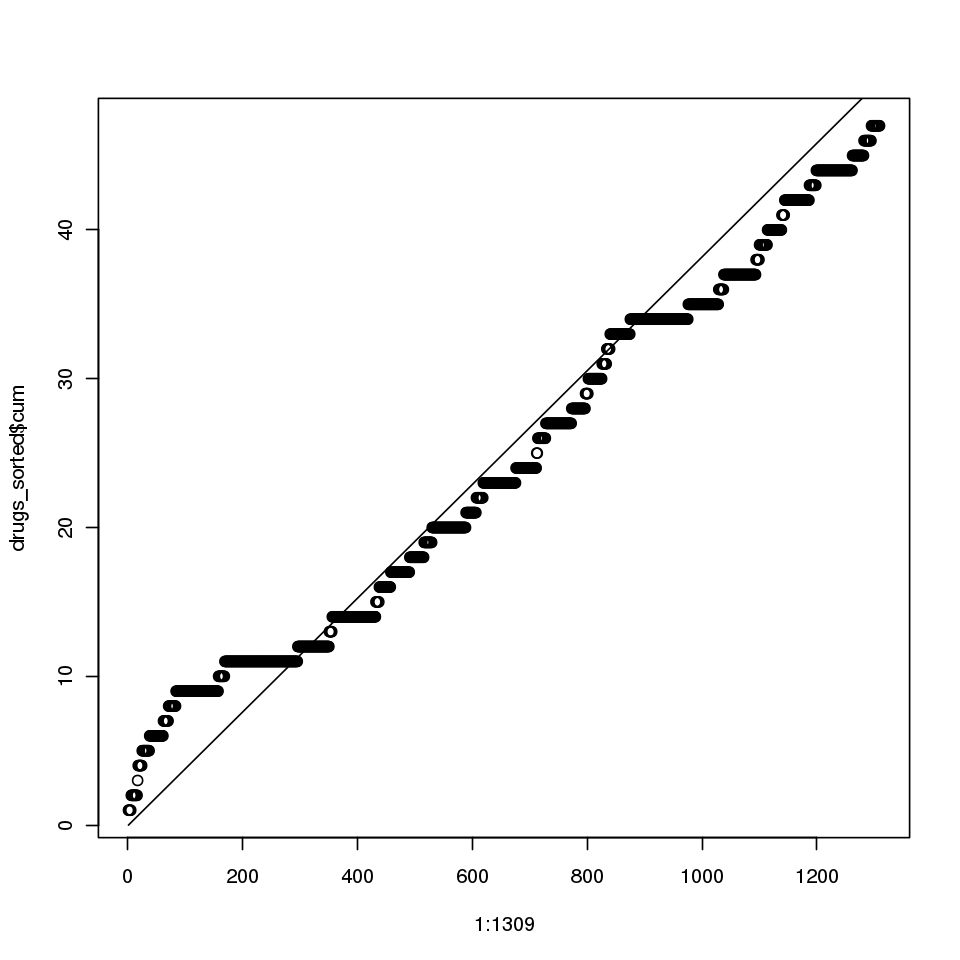

In [82]:
plot(1:1309, drugs_sorted$cum)
lines(1:1309, seq(0, length(common_drugs), length.out = 1309))

In [28]:
unique(comb$name)

[1] "metformin"                              
   [2] "phenformin"                             
   [3] "phenyl biguanide"                       
   [4] "valproic acid"                          
   [5] "estradiol"                              
   [6] "alpha-estradiol"                        
   [7] "dexamethasone"                          
   [8] "mesalazine"                             
   [9] "chlorpropamide"                         
  [10] "tolbutamide"                            
  [11] "tamoxifen"                              
  [12] "verapamil"                              
  [13] "dexverapamil"                           
  [14] "exemestane"                             
  [15] "rofecoxib"                              
  [16] "amitriptyline"                          
  [17] "sulindac"                               
  [18] "tacrolimus"                             
  [19] "15-delta prostaglandin J2"              
  [20] "raloxifene"                             
  [21] "nordihydroguaiaretic acid"              
  [22] "sulfasalazine"                          
  [23] "celecoxib"                              
  [24] "LM-1685"                                
  [25] "SC-58125"                               
  [26] "tanespimycin"                           
  [27] "tomelukast"                             
  [28] "TTNPB"                                  
  [29] "tretinoin"                              
  [30] "LY-294002"                              
  [31] "ciclosporin"                            
  [32] "indometacin"                            
  [33] "clofibrate"                             
  [34] "MK-886"                                 
  [35] "prednisolone"                           
  [36] "thalidomide"                            
  [37] "genistein"                              
  [38] "fludrocortisone"                        
  [39] "quercetin"                              
  [40] "sulindac sulfide"                       
  [41] "exisulind"                              
  [42] "fulvestrant"                            
  [43] "monastrol"                              
  [44] "staurosporine"                          
  [45] "NU-1025"                                
  [46] "acetylsalicylic acid"                   
  [47] "flufenamic acid"                        
  [48] "N-phenylanthranilic acid"               
  [49] "monorden"                               
  [50] "sirolimus"                              
  [51] "arachidonyltrifluoromethane"            
  [52] "trichostatin A"                         
  [53] "diclofenac"                             
  [54] "mercaptopurine"                         
  [55] "nifedipine"                             
  [56] "nitrendipine"                           
  [57] "felodipine"                             
  [58] "azathioprine"                           
  [59] "sodium phenylbutyrate"                  
  [60] "novobiocin"                             
  [61] "fasudil"                                
  [62] "2-deoxy-D-glucose"                      
  [63] "imatinib"                               
  [64] "pirinixic acid"                         
  [65] "rosiglitazone"                          
  [66] "troglitazone"                           
  [67] "cobalt chloride"                        
  [68] "wortmannin"                             
  [69] "tetraethylenepentamine"                 
  [70] "clozapine"                              
  [71] "thioridazine"                           
  [72] "haloperidol"                            
  [73] "chlorpromazine"                         
  [74] "trifluoperazine"                        
  [75] "iloprost"                               
  [76] "copper sulfate"                         
  [77] "oxamic acid"                            
  [78] "W-13"                                   
  [79] "arachidonic acid"                       
  [80] "oligomycin"                             
  [81] "prochlorperazine"                       
  [82] "quinpirole"               

In [12]:
comb

instance_id NES         pval   padj       batch_id
1      1         -1.03949193 0.1592 0.42462615 1       
2      2         -1.14226187 0.0890 0.26214389 1       
3      3         -1.47000000 0.0090 0.05073937 1       
4      4         -1.54723837 0.0044 0.03253333 1       
5     21          0.11586821 0.7788 0.95223091 2       
6     22          0.99785921 0.1918 0.49701784 2       
7     23         -1.23382832 0.0526 0.17639362 2       
8     61         -1.06719039 0.1396 0.37965225 2a      
9    121         -1.01236535 0.1808 0.47435699 5       
10   122          0.21075225 0.6398 0.92430362 5       
11   123         -1.27216532 0.0412 0.14853428 5       
12   124         -1.39280474 0.0170 0.07879939 5       
13   141          0.16820124 0.6940 0.93535130 6       
14   142         -0.30328937 0.5684 0.92430362 6       
15   143         -1.60483028 0.0036 0.03234848 6       
16   144         -0.18381480 0.6726 0.92977365 6       
17   161         -0.08654437 0.8326 0.96445324 7a      
18   164          0.42509240 0.5194 0.92430362 7       
19   165         -1.25277945 0.0472 0.16368391 7       
20   166          0.23360990 0.6190 0.92430362 7       
21   167         -0.19585240 0.6574 0.92681954 8       
22   168         -1.29772994 0.0356 0.13580988 8       
23   169         -0.12778772 0.7564 0.94420213 8       
24   201          0.22617828 0.6234 0.92430362 13      
25   202          0.06015205 0.8838 0.98078431 13      
26   203         -0.87364030 0.3094 0.76472447 13      
27   204         -0.53132467 0.5060 0.92430362 13      
28   205         -0.83615563 0.3448 0.84131200 16      
29   206          0.56572887 0.5002 0.92430362 16      
30   207         -1.29721695 0.0362 0.13784020 16      
⋮    ⋮           ⋮           ⋮      ⋮          ⋮       
6071 7530        -1.81148090 0.0006 0.01126154 1090    
6072 7531         1.08788867 0.1262 0.34944167 1090    
6073 7532        -0.92200577 0.2606 0.65445039 1090    
6074 7533         0.97981070 0.2086 0.53645025 1090    
6075 7534         1.74698720 0.0010 0.01544304 1090    
6076 7535        -1.84527943 0.0006 0.01126154 1091    
6077 7536        -1.83459394 0.0006 0.01126154 1091    
6078 7537        -0.10316299 0.8032 0.96198746 1091    
6079 7538         1.85373014 0.0006 0.01126154 1091    
6080 7539        -0.55580537 0.5016 0.92430362 1091    
6081 7540        -0.34334620 0.5472 0.92430362 1092    
6082 7541        -0.41188497 0.5224 0.92430362 1092    
6083 7542        -0.39815087 0.5270 0.92430362 1092    
6084 7543        -0.07997507 0.8440 0.96638649 1092    
6085 7544        -0.10016441 0.8080 0.96205578 1092    
6086 7545        -0.44016906 0.5164 0.92430362 1093    
6087 7546        -0.07825002 0.8470 0.96772804 1093    
6088 7547        -0.02221956 0.9578 0.99376261 1093    
6089 7548         0.34899678 0.5448 0.92430362 1093    
6090 7549         0.31387177 0.5630 0.92430362 1093    
6091 7550        -1.56538224 0.0042 0.03234848 1094    
6092 7551        -0.39746519 0.5270 0.92430362 1094    
6093 7552        -0.19479176 0.6590 0.92681954 1094    
6094 7553        -1.29527290 0.0366 0.13884328 1094    
6095 7554        -1.77164932 0.0008 0.01443787 1094    
6096 7555        -0.30394041 0.5682 0.92430362 1095    
6097 7556         0.18127933 0.6742 0.93024655 1095    
6098 7557        -0.08681748 0.8324 0.96445324 1095    
6099 7558        -0.21528532 0.6348 0.92430362 1095    
6100 7559         0.14389473 0.7308 0.94053997 1095    
     name                                    concentration cell out
1    metformin                               1e-05         MCF7  0 
2    metformin                               1e-05         MCF7  0 
3    metformin                               1e-07         MCF7  0 
4    metformin                               0.001         MCF7 -1 
5    phenformin                              1e-05         MCF7  0 
6    phenyl biguanide                        1e-05         MCF7  0 
7    valproic acid                           0.001       

## bidirectional gsea

In [5]:
agg <- aggregate(profile$ES, by=list(profile$symbol), mean)
rownames(agg) <- agg[,1]
agg <- agg[,-1, drop=FALSE]

# or use metafor results for CZM
CZM <- agg
colnames(CZM) <- c('Reprogramming:Mouse')

In [6]:
cmapu <- read.gmt('drugs/cmap_up.gmt')
cmapd <- read.gmt('drugs/cmap_dw.gmt')
lincsu <- read.gmt('drugs/lincs_up.gmt')
lincsd <- read.gmt('drugs/lincs_dw.gmt')

In [7]:
SGL <- list()
for (t in names(cmapu)){
    SGL[[t]] <- list("Up"=cmapu[[t]], "Down"=cmapd[[t]])
}
# for (t in names(lincsu)){
#     SGL[[t]] <- list("Up"=lincsu[[t]], "Down"=lincsd[[t]])
# }

In [8]:
subSGL <- sample(SGL, 30)

In [9]:
source('post_functions/FUN.Association_test.R')
bigsea <- Association_test(signatures_genes_list=subSGL, 
                            compounds_zscore_matrix=CZM,
                            number_permutations=2000,
                            function_path="post_functions/")

[1] "parbendazole-3881"
[1] "Number of significant genes in this signature: 196"
[1] "Number of identified genes: 165"
Time difference of 9.82882 secs
[1] "Resampling pvalue calculation completed"
[1] " "
[1] "sirolimus-362"
[1] "Number of significant genes in this signature: 196"
[1] "Number of identified genes: 169"
Time difference of 9.807796 secs
[1] "Resampling pvalue calculation completed"
[1] " "
[1] "melatonin-5393"
[1] "Number of significant genes in this signature: 196"
[1] "Number of identified genes: 166"
Time difference of 10.53224 secs
[1] "Resampling pvalue calculation completed"
[1] " "
[1] "ornidazole-5064"
[1] "Number of significant genes in this signature: 196"
[1] "Number of identified genes: 170"
Time difference of 9.761961 secs
[1] "Resampling pvalue calculation completed"
[1] " "
[1] "mephenytoin-3580"
[1] "Number of significant genes in this signature: 196"
[1] "Number of identified genes: 160"
Time difference of 9.349612 secs
[1] "Resampling pvalue calculation 

In [21]:
#compare python and R results in terms of NES spearman correlation
pyres <- read.csv('bigsea_results.csv', row.names=1)
pyres[rownames(bigsea$GSEA), c('pval', 'NES')]

cor(merge(bigsea$GSEA, bigsea$pvalue, by=0, sort=F)[,3],
    pyres[rownames(bigsea$GSEA), c('pval', 'NES')]$NES, method='spearman')

[1] 0.825139

## inverse CMAP (data from Alex)

In [25]:
q <- read.delim('drugs/sig_query/arfs/TAG/query_result.gct', skip=2)
q$fdr_q_nlog10 <- as.numeric(as.character(q$fdr_q_nlog10))
q$norm_cs <- as.numeric(as.character(q$norm_cs))
q$pert_idose <- gsub("-666", "", q$pert_idose)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [26]:
#aggregate data within the same pert_idose and pert_itime across cell lines
colnames(q)

[1] "id"              "pert_id"         "pert_iname"      "cell_iname"     
 [5] "pert_type"       "pert_idose"      "pert_itime"      "nsample"        
 [9] "ss_ngene"        "cc_q75"          "tas"             "qc_pass"        
[13] "is_hiq"          "is_ncs_sig"      "is_exemplar_sig" "is_null_sig"    
[17] "moa"             "target_name"     "raw_cs"          "fdr_q_nlog10"   
[21] "norm_cs"

In [27]:
head(q,3)

id                                    pert_id        pert_iname cell_iname
1 desc                                  na             na         na        
2 TA.OE012_A549_96H:BRDN0000561642:-666 BRDN0000561642 MYC        A549      
3 TA.OE008_HA1E_96H:BRDN0000464823:-666 BRDN0000464823 MYC        HA1E      
  pert_type pert_idose pert_itime nsample ss_ngene cc_q75 ⋯ qc_pass is_hiq
1 na        na         na         na      na       na     ⋯ na      na    
2 trt_oe               96 h       3       481      0.77   ⋯ 1       1     
3 trt_oe               96 h       3       511      0.81   ⋯ 1       1     
  is_ncs_sig is_exemplar_sig is_null_sig moa  target_name raw_cs fdr_q_nlog10
1 na         na              na          na   na          na          NA     
2 1          1               0           -666 -666        0.5805 15.6536     
3 1          1               0           -666 -666        0.5546  3.2087     
  norm_cs
1     NA 
2 2.2494 
3 2.1490

In [34]:
q[grepl("BRDN0000561642", q$id),]

id                                     pert_id        pert_iname cell_iname
2  TA.OE012_A549_96H:BRDN0000561642:-666  BRDN0000561642 MYC        A549      
11 TA.OE012_SALE_96H:BRDN0000561642:-666  BRDN0000561642 MYC        SALE      
19 TA.OE012_AALE_96H:BRDN0000561642:-666  BRDN0000561642 MYC        AALE      
49 TA.OE012_H1299_96H:BRDN0000561642:-666 BRDN0000561642 MYC        H1299     
   pert_type pert_idose pert_itime nsample ss_ngene cc_q75 ⋯ qc_pass is_hiq
2  trt_oe               96 h       3       481      0.77   ⋯ 1       1     
11 trt_oe               96 h       3       504      0.7    ⋯ 1       1     
19 trt_oe               96 h       3       381      0.72   ⋯ 1       1     
49 trt_oe               96 h       3       386      0.62   ⋯ 1       1     
   is_ncs_sig is_exemplar_sig is_null_sig moa  target_name raw_cs fdr_q_nlog10
2  1          1               0           -666 -666        0.5805 15.6536     
11 1          1               0           -666 -666        0.5111  2.7808     
19 1          1               0           -666 -666        0.5011  2.7226     
49 1          1               0           -666 -666        0.4837  2.6362     
   norm_cs
2  2.2494 
11 1.9805 
19 1.9420 
49 1.8743

In [2]:
df <- q[,c('pert_iname', 'cell_iname', 'pert_type', 'pert_idose', 'pert_itime', 
           'target_name', 'raw_cs', 'fdr_q_nlog10', 'norm_cs')]
df <- df[-1,]
df$condition <- paste(df$pert_iname, df$pert_type, df$pert_idose, df$pert_itime, sep='|')

In [3]:
tocombine <- df[,c("condition", "norm_cs")]

#filter conditions with more than 3 experiments (across cell lines)
freqs <- as.data.frame(table(tocombine$condition))
passed_conditions <- freqs[freqs$Freq > 2, ]$Var1


tocombine <- tocombine[tocombine$condition %in% passed_conditions,]

library(tidyverse)
agg <- tocombine %>%
            group_by(condition) %>%
            summarise(p = t.test(norm_cs, mu = 0)$p.value,
                Avg = mean(norm_cs),
                Star = ifelse(p<0.001,'***', ifelse(p<0.01,'**', ifelse(p<0.05,'*',''))),
                )

agg <- agg[order(agg$p),] #sort by value


top <- 10
agg_up <- agg[agg$Avg > 0,][1:top,]
agg_dw <- agg[agg$Avg < 0,][1:top,]

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

`summarise()` ungrouping output (override with `.groups` argument)



In [27]:
agg[order(agg$Avg),]

condition                         p            Avg       Star
1     KLF6|trt_oe||96 h                 6.295942e-08 -1.438625 *** 
2     BRD-A15079084|trt_cp|10 uM|24 h   2.400531e-05 -1.434420 *** 
3     MAP3K9|trt_oe||96 h               9.206799e-06 -1.418240 *** 
4     CEP-37440|trt_cp|10 uM|24 h       9.119802e-05 -1.398667 *** 
5     ON-01910|trt_cp|10 uM|6 h         1.053467e-04 -1.380860 *** 
6     TAK-733|trt_cp|0.08 uM|24 h       4.085247e-04 -1.365000 *** 
7     BAS-00535043|trt_cp|10 uM|6 h     1.199661e-04 -1.356820 *** 
8     cytochalasin-d|trt_cp|10 uM|6 h   1.693498e-08 -1.348725 *** 
9     pitavastatin|trt_cp|10 uM|24 h    2.505743e-03 -1.336850 **  
10    MAP3K2|trt_oe||96 h               2.569557e-05 -1.304120 *** 
11    cerivastatin|trt_cp|10 uM|24 h    4.373511e-03 -1.295225 **  
12    BRD-K15050703|trt_cp|20 uM|24 h   1.469810e-06 -1.278612 *** 
13    BRD-K63423329|trt_cp|20 uM|24 h   6.252949e-05 -1.276600 *** 
14    PF-06465469|trt_cp|10 uM|24 h     1.187818e-04 -1.274400 *** 
15    BCL10|trt_oe||96 h                8.789011e-08 -1.270490 *** 
16    BRD-K47869605|trt_cp|10 uM|6 h    5.911216e-03 -1.268425 **  
17    BRD-K49477330|trt_cp|20 uM|24 h   4.285724e-04 -1.262125 *** 
18    SB-2343|trt_cp|2.5 uM|24 h        7.163877e-06 -1.259467 *** 
19    MAP3K2|trt_oe||72 h               2.137505e-03 -1.257500 **  
20    BRD-K19876534|trt_cp|10 uM|24 h   5.143020e-07 -1.246425 *** 
21    BRD-A19037878|trt_cp|0.04 uM|24 h 3.163787e-04 -1.230450 *** 
22    brequinar|trt_cp|10 uM|24 h       6.616748e-04 -1.224560 *** 
23    ingenol|trt_cp|10 uM|24 h         2.010008e-02 -1.224240 *   
24    MLN-9708|trt_cp|0.25 uM|24 h      8.052027e-04 -1.220450 *** 
25    valdecoxib|trt_cp|200 uM|24 h     7.220202e-04 -1.220440 *** 
26    NVP-BEZ235|trt_cp|10 uM|24 h      5.830683e-10 -1.219160 *** 
27    MEK-162|trt_cp|2.22 uM|24 h       1.343969e-03 -1.214575 **  
28    PF-05212384|trt_cp|10 uM|24 h     1.982023e-05 -1.212660 *** 
29    neratinib|trt_cp|10 uM|24 h       4.156645e-05 -1.212350 *** 
30    PD-407824|trt_cp|10 uM|24 h       2.644657e-03 -1.204525 **  
⋮     ⋮                                 ⋮            ⋮         ⋮   
25829 BRD-K76674262|trt_cp|10 uM|6 h    2.050165e-04 1.093000  *** 
25830 captopril|trt_cp|10 uM|6 h        5.541964e-03 1.095450  **  
25831 KU-C104129|trt_cp|10 uM|6 h       6.502552e-04 1.097100  *** 
25832 BRD-K38246370|trt_cp|20 uM|24 h   3.220435e-03 1.097100  **  
25833 TUL-XX025TFA|trt_cp|10 uM|6 h     5.907660e-04 1.098340  *** 
25834 BRD-K84924563|trt_cp|40 uM|24 h   1.640649e-04 1.102100  *** 
25835 BRD-K71855031|trt_cp|4 uM|24 h    3.420304e-04 1.102400  *** 
25836 BRD-A72575012|trt_cp|4 uM|6 h     4.530279e-04 1.103380  *** 
25837 zebularine|trt_cp|12 uM|24 h      9.920131e-04 1.109200  *** 
25838 BRD-K61788733|trt_cp|4 uM|24 h    5.332637e-06 1.111940  *** 
25839 BRD-K37932103|trt_cp|10 uM|24 h   1.082834e-03 1.118175  **  
25840 GMEB2|trt_sh||144 h               9.753856e-03 1.132825  **  
25841 rhapontin|trt_cp|10 uM|6 h        2.389552e-04 1.136060  *** 
25842 BRD-K04779531|trt_cp|10 uM|6 h    1.271521e-03 1.148650  **  
25843 BRD-K04779531|trt_cp|10 uM|24 h   2.039299e-03 1.153300  **  
25844 ERRFI1|trt_sh||96 h               1.203020e-06 1.162062  *** 
25845 BRD-A04845303|trt_cp|10 uM|24 h   6.607465e-06 1.190850  *** 
25846 CTNNB1|trt_oe|3.0 uL|96 h         2.685807e-07 1.198789  *** 
25847 SA-1463787|trt_cp|20 uM|24 h      1.004976e-03 1.200275  **  
25848 alda-1|trt_cp|40 uM|24 h          1.772712e-03 1.202380  **  
25849 BRD-K67506692|trt_cp|10 uM|24 h   8.910362e-05 1.204783  *** 
25850 BRD-K15968719|trt_cp|20 uM|24 h   1.834338e-03 1.225500  **  
25851 BRD-K61053657|trt_cp|80 uM|24 h   6.123059e-04 1.230900  *** 
25852 BMS-641988|trt_cp|12 uM|24 h      2.324292e-04 1.232880  *** 
25853 CCND3|trt_oe||72 h                9.117676e-05 1.259067  *** 
25854 AR-C133057XX|trt_cp|12 uM|24 h    5.245587e-04 1.297075  *** 
25855 SLC2A1|trt_oe|200.0 ng|96 h       3.107431e-06 1.328060 

In [4]:
agg_up
agg_dw

condition                      p            Avg       Star
1  TP53|trt_oe||96 h              1.301260e-27 0.4798339 *** 
2  MYC|trt_oe||96 h               1.708597e-19 1.8883895 *** 
3  RUFY1|trt_sh||96 h             1.455893e-10 0.9588391 *** 
4  PRKCE|trt_sh||96 h             1.698487e-09 0.8124342 *** 
5  CSK|trt_sh||96 h               4.652518e-09 0.4535292 *** 
6  CTNNB1|trt_oe||96 h            2.670332e-08 0.6955760 *** 
7  BRD-K93577185|trt_cp|4 uM|24 h 1.091083e-07 0.9578857 *** 
8  LARS2|trt_oe||96 h             1.245617e-07 0.9513750 *** 
9  MS4A15|trt_xpr||96 h           1.363391e-07 0.9238300 *** 
10 TNFSF14|trt_xpr||96 h          1.443562e-07 0.8617200 ***

condition                       p            Avg        Star
1  BRAF|trt_oe||96 h               1.928229e-16 -0.8064402 *** 
2  CARD11|trt_oe||96 h             3.813949e-12 -1.1998571 *** 
3  INCENP|trt_xpr||96 h            1.200605e-10 -1.0913667 *** 
4  wortmannin|trt_cp|10 uM|6 h     2.153773e-10 -1.0022200 *** 
5  XPO1|trt_xpr||96 h              3.882377e-10 -1.1363278 *** 
6  NVP-BEZ235|trt_cp|10 uM|24 h    5.830683e-10 -1.2191600 *** 
7  sirolimus|trt_cp|10 uM|24 h     1.274040e-09 -0.8084273 *** 
8  everolimus|trt_cp|10 uM|24 h    1.412689e-09 -1.0749316 *** 
9  ingenol|trt_cp|10 uM|6 h        4.826152e-09 -1.1612500 *** 
10 cytochalasin-d|trt_cp|10 uM|6 h 1.693498e-08 -1.3487250 ***

In [85]:
oe <- q[(q$pert_type == 'trt_xpr') & (q$fdr_q_nlog10 > 2.0),]

oei <- oe[c('id', 'pert_iname', 'cell_iname', 'pert_idose', 'pert_itime', 
            'nsample', 'raw_cs', 'fdr_q_nlog10', 'norm_cs')]
            
pos <- c()
for (i in oei$pert_iname){
    cond <- sign(oei[oei$pert_iname %in% c(i),]$norm_cs) > 0
    if (all(cond) & (length(cond) > 1)){
        pos <- c(pos, i)
    }
}


In [87]:
print(as.character(unique(oei[oei$pert_iname %in% unique(pos),]$pert_iname )))

  [1] "SDC4"                  "PPP2R2D"               "SELE"                 
  [4] "CELA1"                 "RRAS2"                 "GCDH"                 
  [7] "SIGLEC15"              "LDLRAD3"               "SMCO4"                
 [10] "RSPO3"                 "GPRC5A"                "LIG4"                 
 [13] "SLC2A4RG"              "PLS3"                  "GLRA1"                
 [16] "RNF128"                "ERRFI1"                "STK40"                
 [19] "C8ORF44-SGK3"          "CHRNA7"                "CDH11"                
 [22] "SLC22A2"               "PIK3R5"                "PLXNA4"               
 [25] "SHROOM3"               "SLC23A1"               "TRAT1"                
 [28] "OIP5"                  "RASAL2"                "SLC39A8"              
 [31] "SFMBT1"                "SLC12A6"               "SLC9B1"               
 [34] "PKDCC"                 "TAOK1"                 "PRAG1"                
 [37] "PIPOX"                 "PARG"                  "BTNL9"   

In [39]:
unique(q$pert_type)

[1] na         trt_oe     trt_xpr    trt_sh     trt_sh.cgs trt_cp     trt_lig   
Levels: na trt_cp trt_lig trt_oe trt_sh trt_sh.cgs trt_xpr

In [40]:
colnames(q)

[1] "id"              "pert_id"         "pert_iname"      "cell_iname"     
 [5] "pert_type"       "pert_idose"      "pert_itime"      "nsample"        
 [9] "ss_ngene"        "cc_q75"          "tas"             "qc_pass"        
[13] "is_hiq"          "is_ncs_sig"      "is_exemplar_sig" "is_null_sig"    
[17] "moa"             "target_name"     "raw_cs"          "fdr_q_nlog10"   
[21] "norm_cs"

In [41]:
cp <- q[(q$pert_type == 'trt_cp') & (q$fdr_q_nlog10 > 2.0),]

In [53]:
cpi <- cp[c('id', 'pert_iname', 'cell_iname', 'pert_idose', 'pert_itime', 
            'nsample', 'raw_cs', 'fdr_q_nlog10', 'norm_cs')]
            
pos <- c()
for (i in cpi$pert_iname){
    cond <- sign(cpi[cpi$pert_iname %in% c(i),]$norm_cs) > 0
    if (all(cond) & (length(cond) > 1)){
        pos <- c(pos, i)
    }
}


In [57]:
length(unique(pos))

[1] 95

In [62]:
ff <- as.data.frame(table(cp[cp$pert_iname %in% pos,]$moa))
ff[order(ff$Freq),]

Var1                                                                                                                                                                                                                                                                 
2    11-beta-HSD1 inhibitor                                                                                                                                                                                                                                               
3    11-beta-HSD1 inhibitor|Acetylcholinesterase inhibitor|ATPase inhibitor|Caspase inhibitor|HIV protease inhibitor|Lipid peroxidase inhibitor|NFKB inhibitor|Quorum sensing signaling modulator|STAT inhibitor|Steryl sulfatase inhibitor|Tyrosine phosphatase inhibitor
4    11-beta-HSD1 inhibitor|Acetylcholinesterase inhibitor|Caspase inhibitor|HIV protease inhibitor|Lipid peroxidase inhibitor|Quorum sensing signaling modulator|Steryl sulfatase inhibitor|Tyrosine phosphatase inhibitor|ATPase inhibitor|NFKB inhibitor|STAT inhibitor
5    11-beta-HSD1 inhibitor|FXR agonist                                                                                                                                                                                                                                   
6    17,20 lyase inhibitor|Cytochrome P450 inhibitor|Steroid sulfatase inhibitor|Androgen biosynthesis inhibitor                                                                                                                                                          
7    3-ketoacyl CoA thiolase inhibitor                                                                                                                                                                                                                                    
8    3beta-hydroxy-delta5-steroid dehydrogenase inhibitor                                                                                                                                                                                                                 
9    5-alpha reductase inhibitor                                                                                                                                                                                                                                          
10   Abl inhibitor|Aurora kinase inhibitor|FLT3 inhibitor                                                                                                                                                                                                                 
11   Abl inhibitor|Src inhibitor|VEGFR inhibitor                                                                                                                                                                                                                          
12   ACAT inhibitor                                                                                                                                                                                                                                                       
13   ACAT inhibitor|Sterol regulatory element binding protein (SREBP) inhibitor                                                                                                                                                                                           
14   ACE inhibitor                                                                                                                                                                                                                                                        
15   ACE inhibitor|Angiotensin receptor antagonist|Insulin sensitizer                                                                                                                                                                                                     


In [30]:
aggregate(~pert_iname, cp, )

id                                              pert_id      
123    CPC013_HEPG2_6H:BRD-A68274214-001-01-7:10       BRD-A68274214
166    CPC018_ASC_24H:BRD-A56987319-001-02-0:10        BRD-A56987319
189    PBIOA020_A549_24H:M13                           BRD-K81491172
203    CPC020_HA1E_6H:BRD-K34098590-001-01-3:10        BRD-K34098590
212    DOS055_HT29_24H:BRD-K93062774-001-01-5:5        BRD-K93062774
267    CPC006_PC3_24H:G04                              BRD-A46335897
275    CPC012_SKB_24H:BRD-K02130563-001-06-4:10        BRD-K02130563
276    REP.A014_PC3_24H:E13                            BRD-K58501140
282    MOAR003_A375_24H:N24                            BRD-K33226500
290    CRCGN015_HEPG2_48H:BRD-K52020312:11.4991        BRD-K52020312
317    REP.A024_THP1_24H:L14                           BRD-K78055238
320    LJP001_MDAMB231_24H:BRD-K99616396-001-02-8:0.4  BRD-K99616396
332    CPC006_HA1E_6H:BRD-K51575138-001-01-7:10        BRD-K51575138
339    CPC007_HA1E_6H:BRD-K82983587-001-03-8:10        BRD-K82983587
406    CPC006_HT29_24H:BRD-K06890060-001-05-9:40       BRD-K06890060
420    CRCGN016_MCF10A.WT.HP_24H:BRD-K59590127:10.9778 BRD-K59590127
426    CPC019_HA1E_6H:BRD-K33116223-001-01-9:10        BRD-K33116223
428    REP.B020_MDAMB231_24H:L23                       BRD-K46970505
488    POL001_HT29_24H:B07                             BRD-K39256324
517    CPC012_MCF7_24H:BRD-K22828899-001-01-5:10       BRD-K22828899
525    CPC015_SKB_24H:BRD-K22503835-001-06-0:10        BRD-K22503835
553    CRCGN006_A549_24H:BRD-K78260339:0.0823045       BRD-K78260339
562    CPC007_A549_24H:BRD-K03568209-001-12-2:10       BRD-K03568209
566    PAC044_U2OS_6H:BRD-K29776425-001-01-2:10.0059   BRD-K29776425
568    MOAR002_PC3_24H:N11                             BRD-K58568447
569    DOSVAL003_HCC515_24H:BRD-K21528100:5            BRD-K21528100
571    PAC069_U2OS_6H:BRD-K60936953-001-07-9:20        BRD-K60936953
597    CPC019_HA1E_6H:BRD-K49553303-001-01-8:10        BRD-K49553303
604    POL001_HEPG2_24H:L21                            BRD-K94649603
605    CPC002_PC3_24H:BRD-A49046702-003-03-4:10        BRD-A49046702
⋮      ⋮                                               ⋮            
423331 REP.A016_MCF10A_24H:M07                         BRD-A77216878
423334 REP.A004_MCF7_24H:K20                           BRD-K21718444
423336 CRCGN015_HEPG2_48H:BRD-K96088139:100.478        BRD-K96088139
423339 CPC006_MCF7_24H:M18                             BRD-K54256913
423342 REP.A024_YAPC_24H:M12                           BRD-K78485176
423346 REP.A014_MCF10A_24H:L02                         BRD-K59325863
423347 REP.A015_YAPC_24H:O10                           BRD-K61195623
423349 CRCGN015_HEPG2_48H:BRD-K63682780:11.1441        BRD-K63682780
423350 CVD001_HEPG2_6H:BRD-K47869605-001-18-9:10       BRD-K47869605
423351 CRCGN015_HEPG2_48H:BRD-K10180294:11.2688        BRD-K10180294
423352 PBIOA022_HEPG2_24H:M02                          BRD-A12230535
423362 CRCGN015_HEPG2_48H:BRD-K08114154:32.8622        BRD-K08114154
423364 DOSVAL005_HEPG2_24H:BRD-K01404579:20            BRD-K01404579
423367 MOAR003_A375_24H:I19                            BRD-K37723606
423371 CPC015_NPC_24H:BRD-A55594068-065-03-1:10        BRD-A55594068
423378 NMH002_NPC_24H:BRD-K42624714-001-03-3:10        BRD-K42624714
423380 REP.B010_MCF10A_24H:D13                         BRD-K12787259
423381 PBIOA016_HEPG2_24H:I08                          BRD-K86525559
423388 GPR001_XC_XH:GALR2_M617:3_H                     GALR2_M617   
423389 CPC009_MCF7_24H:BRD-K38625260-019-01-0:10       BRD-K38625260
423391 CPC006_PC3_24H:I05                              BRD-A52650764
423394 CPC009_A549_24H:BRD-K38625260-019-01-0:10       BRD-K38625260
423404 LJP009_THP1_24H:I18                             BRD-K55187425
423406 PBIOA015_HT29_24H:J01                           BRD-K14870255
423408 PBIOA015_HEPG2_24H:I01                          BRD-K71847383
423409 LJP009_MCF10A_24H:O07                           BRD-A29901043
42341

# Gene grooming

In [17]:
# taken from kit standard of 
#https://www.clinisciences.com/en/read/stem-cells-characterization-1087/esc-and-ipsc-characterization-by-1429.html
#and https://www.nature.com/articles/s41598-018-24051-5
pluripotency <- c('20674', '18999', '71950', '26380', '18613', '81879', '11614')

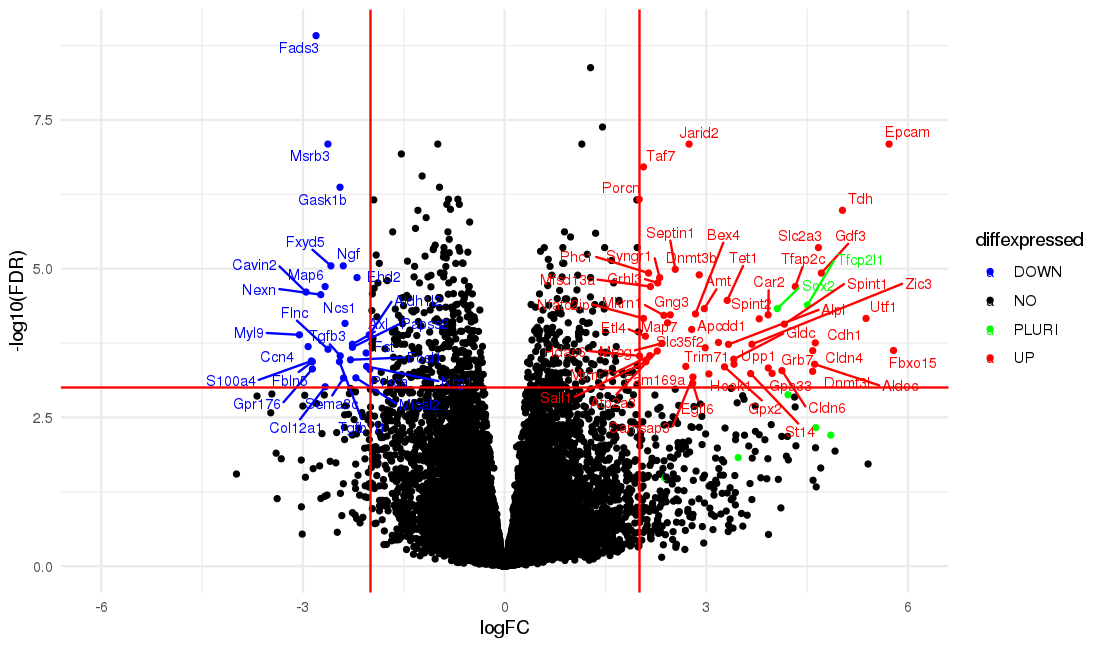

In [27]:
library(ggrepel)
coef_thr <- 2.0
fdr_thr <- 0.001

db <- dft

db$diffexpressed <- "NO"
db$diffexpressed[(db$logFC > coef_thr) & (db$FDR < fdr_thr)] <- "UP"
db$diffexpressed[(db$logFC < -coef_thr) & (db$FDR < fdr_thr)] <- "DOWN"

db$delabel <- NA
db$delabel[db$diffexpressed != "NO"] <- as.character(db$symbol[db$diffexpressed != "NO"])

db[pluripotency,]$diffexpressed <- 'PLURI'

mycolors <- c("blue", "red", "black", 'green')
names(mycolors) <- c("DOWN", "UP", "NO", "PLURI")

options(repr.plot.width=9.2, repr.plot.height=5.4)
p <- ggplot(data=db, aes(x=logFC, y=-log10(FDR), col=diffexpressed, label=delabel)) + 
            geom_point(size=1) + theme_minimal() + geom_text_repel(size=3) +
            geom_vline(xintercept=c(-coef_thr, coef_thr), col="red") +
            geom_hline(yintercept=-log10(fdr_thr), col="red") + 
            xlim(-6, 6) + 
            scale_colour_manual(values = mycolors)

p

In [67]:
db[db$symbol == "Igfbp2", ]

coef     pval_T      se        FDR.coef  pval_C   symbol Metafor 
16008 2.345152 0.003325284 0.6935336 0.0292012 0.411688 Igfbp2 2.345152
      ES      
16008 3.598869

In [65]:
top <- rownames(cdf[((cdf$coef < -2) & (cdf$FDR.coef < 0.005)),])

Finished
Cav1 in aging genes: FALSE 
Col12a1 in aging genes: FALSE 
Fst in aging genes: FALSE 
Itga4 in aging genes: FALSE 
Ptgs2 in aging genes: TRUE 
Phldb2 in aging genes: FALSE 
Tgfb3 in aging genes: FALSE 
Tll1 in aging genes: FALSE 
Ccn4 in aging genes: FALSE 
Fbln5 in aging genes: FALSE 
Osr1 in aging genes: FALSE 
Papss2 in aging genes: FALSE 
Cdc42ep3 in aging genes: FALSE 
Gask1b in aging genes: FALSE 
Prss23 in aging genes: FALSE 


query  X_id   X_score  entrezgene
1  12389  12389  19.67593 12389     
2  12816  12816  19.65639 12816     
3  14313  14313  19.33420 14313     
4  16401  16401  19.67517 16401     
5  19225  19225  19.33420 19225     
6  208177 208177 19.65639 208177    
7  21809  21809  19.37522 21809     
8  21892  21892  19.65639 21892     
9  22402  22402  19.33420 22402     
10 23876  23876  19.65639 23876     
11 23967  23967  19.67593 23967     
12 23972  23972  19.67517 23972     
13 260409 260409 19.37522 260409    
14 68659  68659  19.34846 68659     
15 76453  76453  19.37522 76453     
   name                                                symbol   taxid
1  caveolin 1, caveolae protein                        Cav1     10090
2  collagen, type XII, alpha 1                         Col12a1  10090
3  follistatin                                         Fst      10090
4  integrin alpha 4                                    Itga4    10090
5  prostaglandin-endoperoxide synthase 2               Ptgs2    10090
6  pleckstrin homology like domain, family B, member 2 Phldb2   10090
7  transforming growth factor, beta 3                  Tgfb3    10090
8  tolloid-like                                        Tll1     10090
9  cellular communication network factor 4             Ccn4     10090
10 fibulin 5                                           Fbln5    10090
11 odd-skipped related transcription factor 1          Osr1     10090
12 3'-phosphoadenosine 5'-phosphosulfate synthase 2    Papss2   10090
13 CDC42 effector protein (Rho GTPase binding) 3       Cdc42ep3 10090
14 golgi associated kinase 1B                          Gask1b   10090
15 protease, serine 23                                 Prss23   10090

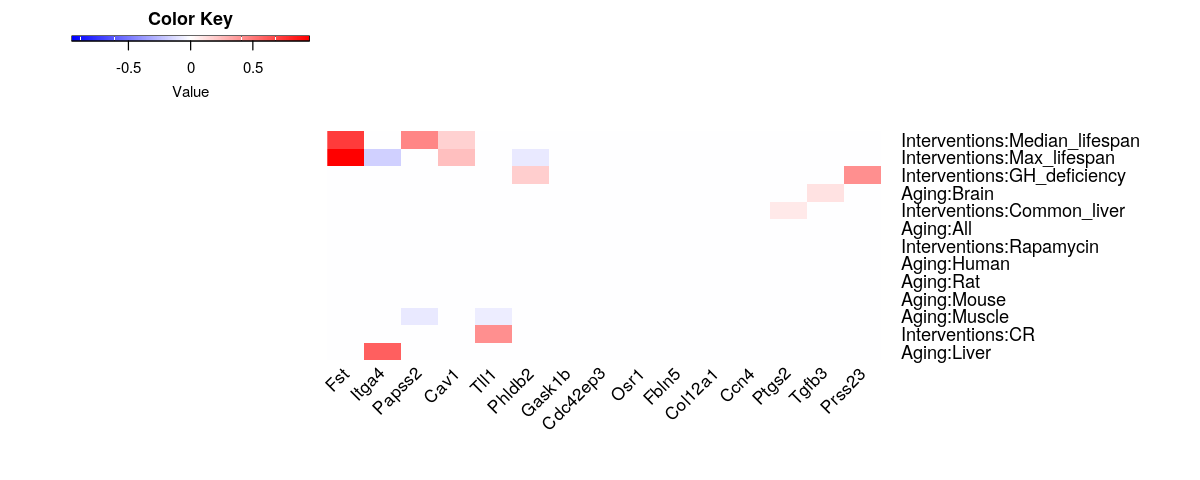

In [66]:
Ntop <- 5
db <- cdf
fdr_thr <- 0.05

db['ES'] <- -log10(db$FDR.coef) * db$coef
#top <- c("21420", "20527", "81879", "13436", "58865", "22773", "54204", "16008", "54366") #rownames(db[order(db$ES),][1:Ntop,])
#top <- c("68659", "14313", "22402", "23972", "21892", "12293", "21809")
res <- as.data.frame(queryMany(top, scopes="entrezgene", species="mouse"))
sym <- res$symbol

sig_table <- matrix(0:0, nrow=length(top), ncol=length(age))
#aging test and signatures test
for (i in 1:length(top)){
    cat(res$symbol[[i]], "in aging genes:", top[[i]] %in% age_gset, '\n')
    for (j in 1:length(age)){
        val <- age[[j]][top[[i]],]$logFC
        pv <- age[[j]][top[[i]],]$FDR
        if ((is.na(pv)==F) & (pv < fdr_thr)){
            sig_table[i, j] <- val
        }else{
            sig_table[i, j] <- 0
        }
        
    }
}
rownames(sig_table) <- sym
colnames(sig_table) <- names(age)

res
options(repr.plot.width = 10, repr.plot.height = 4)
par(mar=c(7.1, 4.1, 4.1, 2.1))
my_palette <- colorRampPalette(c("blue", "white", "red"))(n = 300)
heatmap.2(t(sig_table), dendrogram='none', density.info="none", trace="none", 
            col=my_palette, margins=c(6, 16), srtCol=45,)

In [1]:
#regulation in datasets
# dsl <- ultradf[c('GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
#                                 'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
#                                 'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
#                                 'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
#                                 'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
#                                 'GSE127927$7F-Sall4', 'GSE127927$7F', 
#                                 'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1')]


# ### all expression vs time plots for chosen datasets
# g <- "17075"
# gname <- db[g,]$symbol

# options(repr.plot.width=5, repr.plot.height=5)

# plot(0,0,xlim = c(0,21), ylim = c(-3,3), type = "n", 
#     main=gname, xlab="Day", ylab="Z-score",)
# grid(1, 10, lwd = 1)

# cl <- rainbow(length(dsl))
# legend(11, 0., legend=names(dsl),
#        col=cl, box.lty=0, lty=1, cex=0.6)

# for (i in 1:length(dsl)){
#     d <- names(dsl)[[i]]
#     vals <- as.vector(dsl[[d]]$data[g,])
#     vals <- (vals - mean(as.numeric(vals))) / sd(as.numeric(vals))
#     lines(dsl[[d]]$time, vals, col = cl[i], type = 'b', lwd=1.0)
# }


In [48]:
musGenes <- c("Hmmr", "Tlx3", "Cpeb4")
# Basic function to convert mouse to human gene names
convertMouseGeneList <- function(x){
    require("biomaRt")
    human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
    mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")
    genesV2 = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", 
                values = x , mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)
    humanx <- unique(genesV2[, 2])
    # Print the first 6 genes found to the screen
    print(head(humanx))
return(humanx)
}

# Enrichment analysis

## model genes enrichment

In [22]:
library(tidyverse)
signature_mouse <- read.csv('signatures/reprogramming_human_full.csv', row.names=1)

# gef <- read.csv('clocks/mouse_gene_effects.csv')
gef <- read.csv('clocks/human_gene_effects.csv')
gef$symbol = as.character(gef$X)

agef <- gef %>% group_by(symbol) %>% summarise(knockout_effect = mean(knockout_effect),
                                       FDR = mean(FDR))

agef <- agef[agef$knockout_effect > 0, ]
#agef <- agef[agef$FDR < 0.2,]


`summarise()` ungrouping output (override with `.groups` argument)



In [18]:
agef

symbol knockout_effect FDR      
1  Atoh8  0.94976894      0.1367188
2  B3gnt9 0.09984902      0.1857311
3  Bmt2   0.15935015      0.1367188
4  Bst2   7.14792595      0.1367188
5  C2cd2  0.22391403      0.1367188
6  Cdc40  2.28353868      0.1367188
7  Churc1 2.03266257      0.1367188
8  Cpeb2  6.35497345      0.1562500
9  Dnajc2 0.09726923      0.1857311
10 Gpx3   3.47507328      0.1857311
11 Guf1   1.17693544      0.1367188
12 Krt18  0.49056246      0.1857311
13 Macir  0.56291708      0.1857311
14 Mybl2  0.11275933      0.1562500
15 Ndufs6 2.00356272      0.1562500
16 Pde4a  0.69235617      0.1367188
17 Pes1   0.82422635      0.1857311
18 Procr  2.59852329      0.1367188
19 Rpl29  1.09349054      0.1367188
20 Tns3   0.22341286      0.1562500
21 Vrk2   0.77287559      0.1367188
22 Zfp9   1.89326096      0.1367188

In [26]:
wei <- read.csv('clocks/mouse_model_weights.csv')
colnames(wei) <- c('etz', 'w')
wei$symbol <- as.character(signature_mouse[as.character(wei$etz),]$symbol)

In [27]:
agef <- merge(agef, wei, by='symbol')

In [38]:
up <- as.character(agef[agef$w >0,]$symbol)
dw <- as.character(agef[agef$w <0,]$symbol)

## fgsea

In [ ]:
all_genes <- setdiff(as.character(signature_mouse$symbol), as.character(agef$symbol))

tmp <- rep(0, length(all_genes))
tmp <- cbind(all_genes, tmp)
tmp <- as.data.frame(tmp)
colnames(tmp) <- c('symbol', "knockout_effect")
agef <- rbind(agef, tmp)
agef$knockout_effect <- as.numeric(agef$knockout_effect)

In [5]:
source('post_functions/FUN.Run_functional_GSEA.R')
fgsea <- Run_functional_GSEA(agef, species="Mus musculus", type="Symbol", 
                        n_permutations=10000, min_size=10, max_size=500, with_MF=F,
                        ontologies_list=F, 
                        ontologies_dict=F)

Loading required package: Rcpp



## Enricher

In [23]:
gene <- toupper(as.character(agef$symbol))

In [20]:
suppressMessages(library(msigdbr))
suppressMessages(library(org.Mm.eg.db))
suppressMessages(library(clusterProfiler))
suppressMessages(library(ggplot2))
suppressMessages(library(gridExtra))
#params
#species = "Mus musculus"
species = "Homo sapiens"

#terms
m_df_h = msigdbr(species = species, category = "H")
m_df_bp = msigdbr(species = species, category = "C5",subcategory = "BP")
m_df_kegg = msigdbr(species = species, category = "C2",subcategory = "CP:KEGG")
m_df_reactome = msigdbr(species = species, category = "C2",subcategory = "CP:REACTOME")
m_df <- rbind(rbind(m_df_h, m_df_bp,m_df_kegg),m_df_reactome)
terms <- m_df[, c('gs_name', 'gene_symbol')]

#define universe as all model genes
mouse_model_genes <- rownames(read.csv('clocks/mouse_model_features.csv', row.names=1))
universe <- as.character(signature_mouse[mouse_model_genes,]$symbol)

In [24]:
res <- enricher(gene, 
            pvalueCutoff = 0.1, 
            pAdjustMethod = "BH", 
            universe=universe, 
            minGSSize = 10, 
            maxGSSize = 500, 
            qvalueCutoff = 0.2, 
            TERM2GENE=terms,)

enr <- data.frame(res)

No gene set have size > 10 ...

--> return NULL...



In [37]:
enr

<0 x 0 matrix>

In [88]:
enr <- enr[order(enr$p.adjust),]
enr$log10 <- -log10(enr$p.adjust)

In [105]:
write.csv(enr, 'clocks/rej_genes_enrich.csv')

In [89]:
enr$ID

[1] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"                           
 [2] "REACTOME_ECM_PROTEOGLYCANS"                                           
 [3] "REACTOME_COLLAGEN_CHAIN_TRIMERIZATION"                                
 [4] "REACTOME_NON_INTEGRIN_MEMBRANE_ECM_INTERACTIONS"                      
 [5] "REACTOME_MET_ACTIVATES_PTK2_SIGNALING"                                
 [6] "KEGG_ECM_RECEPTOR_INTERACTION"                                        
 [7] "REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS"                          
 [8] "REACTOME_SYNDECAN_INTERACTIONS"                                       
 [9] "REACTOME_BINDING_AND_UPTAKE_OF_LIGANDS_BY_SCAVENGER_RECEPTORS"        
[10] "REACTOME_DEGRADATION_OF_THE_EXTRACELLULAR_MATRIX"                     
[11] "REACTOME_MET_PROMOTES_CELL_MOTILITY"                                  
[12] "REACTOME_COLLAGEN_DEGRADATION"                                        
[13] "REACTOME_SCAVENGING_BY_CLASS_A_RECEPTORS"                             
[14] "REACTOME_ASSEMBLY_OF_COLLAGEN_FIBRILS_AND_OTHER_MULTIMERIC_STRUCTURES"
[15] "REACTOME_COLLAGEN_BIOSYNTHESIS_AND_MODIFYING_ENZYMES"                 
[16] "GOBP_EXTERNAL_ENCAPSULATING_STRUCTURE_ORGANIZATION"                   
[17] "REACTOME_NCAM1_INTERACTIONS"                                          
[18] "REACTOME_COLLAGEN_FORMATION"                                          
[19] "REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION"                           
[20] "REACTOME_SIGNALING_BY_MET"                                            
[21] "GOBP_CRISTAE_FORMATION"                                               
[22] "GOBP_COLLAGEN_FIBRIL_ORGANIZATION"                                    
[23] "REACTOME_NCAM_SIGNALING_FOR_NEURITE_OUT_GROWTH"                       
[24] "KEGG_FOCAL_ADHESION"

In [90]:
sel <- c(
    'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
    'REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS',
    'REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION',
    'REACTOME_COLLAGEN_FORMATION',
    'GOBP_CRISTAE_FORMATION',
    'KEGG_FOCAL_ADHESION'
     )

enr <- enr[enr$ID %in% sel,]


In [92]:
enr$ID <- factor(enr$ID, levels=rev(enr$ID))

In [93]:
enr

ID                                         
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 
REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS
REACTOME_COLLAGEN_FORMATION                 REACTOME_COLLAGEN_FORMATION                
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION  REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION 
GOBP_CRISTAE_FORMATION                      GOBP_CRISTAE_FORMATION                     
KEGG_FOCAL_ADHESION                         KEGG_FOCAL_ADHESION                        
                                            Description                                
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 
REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS
REACTOME_COLLAGEN_FORMATION                 REACTOME_COLLAGEN_FORMATION                
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION  REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION 
GOBP_CRISTAE_FORMATION                      GOBP_CRISTAE_FORMATION                     
KEGG_FOCAL_ADHESION                         KEGG_FOCAL_ADHESION                        
                                            GeneRatio BgRatio  pvalue      
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  10/45     130/8671 8.279707e-10
REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS 5/45      51/8671  5.891803e-06
REACTOME_COLLAGEN_FORMATION                 4/45      52/8671  1.428944e-04
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION  6/45      165/8671 1.909679e-04
GOBP_CRISTAE_FORMATION                      3/45      29/8671  4.343247e-04
KEGG_FOCAL_ADHESION                         5/45      149/8671 9.838187e-04
                                            p.adjust     qvalue      
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  9.736936e-07 9.081532e-07
REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS 9.166001e-04 8.549027e-04
REACTOME_COLLAGEN_FORMATION                 9.335765e-03 8.707364e-03
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION  1.181991e-02 1.102430e-02
GOBP_CRISTAE_FORMATION                      2.432219e-02 2.268503e-02
KEGG_FOCAL_ADHESION                         4.820712e-02 4.496224e-02
                                            geneID                                                     
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  Col1a2/Col3a1/Col4a1/Col5a3/Fbln1/Fn1/Gas1/Id2/Igfbp4/Postn
REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS Col1a2/Col3a1/Col4a1/Col5a3/Fn1                            
REACTOME_COLLAGEN_FORMATION                 Col1a2/Col3a1/Col4a1/Col5a3                                
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION  Col1a2/Col3a1/Col4a1/Col5a3/Fbln1/Fn1                      
GOBP_CRISTAE_FORMATION                      Atp5j2/Atp5k/Chchd10                                       
KEGG_FOCAL_ADHESION                         Col1a2/Col3a1/Col4a1/Col5a3/Fn1                            
                                            Count log10   
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  10    6.011578
REACTOME_INTEGRIN_CELL_SURFACE_INTERACTIONS  5    3.037820
REACTOME_COLLAGEN_FORMATION                  4    2.029850
REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION   6    1.927386
GOBP_CRISTAE_FORMATION                       3    1.613997
KEGG_FOCAL_ADHESION                          5    1.316889

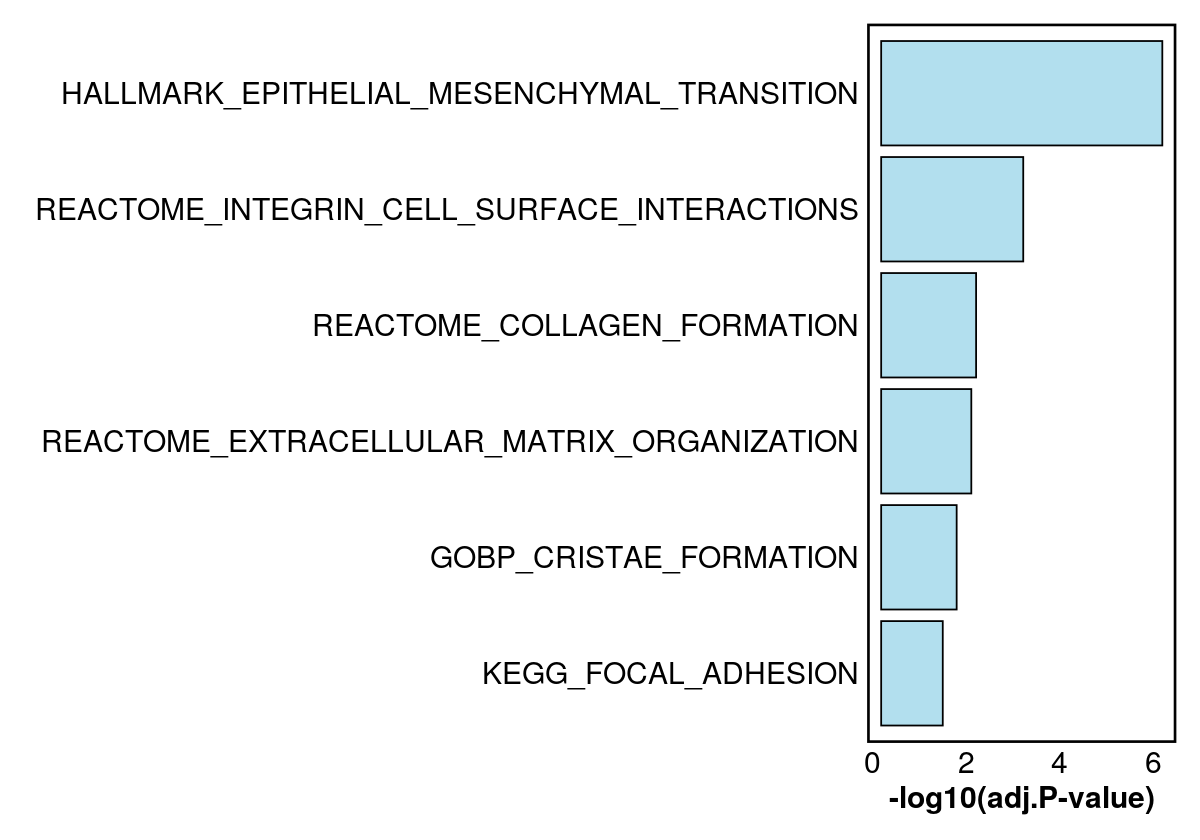

In [101]:
fontsize=18
ggplot(enr, aes(x=log10, y=ID)) + 
    geom_bar(stat="identity", colour="black", fill='lightblue2')+
    theme_minimal()+
    theme(axis.text=element_text(size=fontsize, hjust=1, color='black'),
            axis.title=element_text(size=fontsize, face="bold"), 
            plot.title=element_text(size=fontsize, face = "bold"),
            legend.title=element_text(size=fontsize, face = "bold"),
            legend.text=element_text(size=fontsize),
            legend.position="top",
            panel.background = element_rect(fill='white', colour='black', size=1.5, linetype='solid'),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            plot.margin = unit(c(0.5,0.5,0.5,0.), "cm")) +
    labs(x = "-log10(adj.P-value)", y = "")

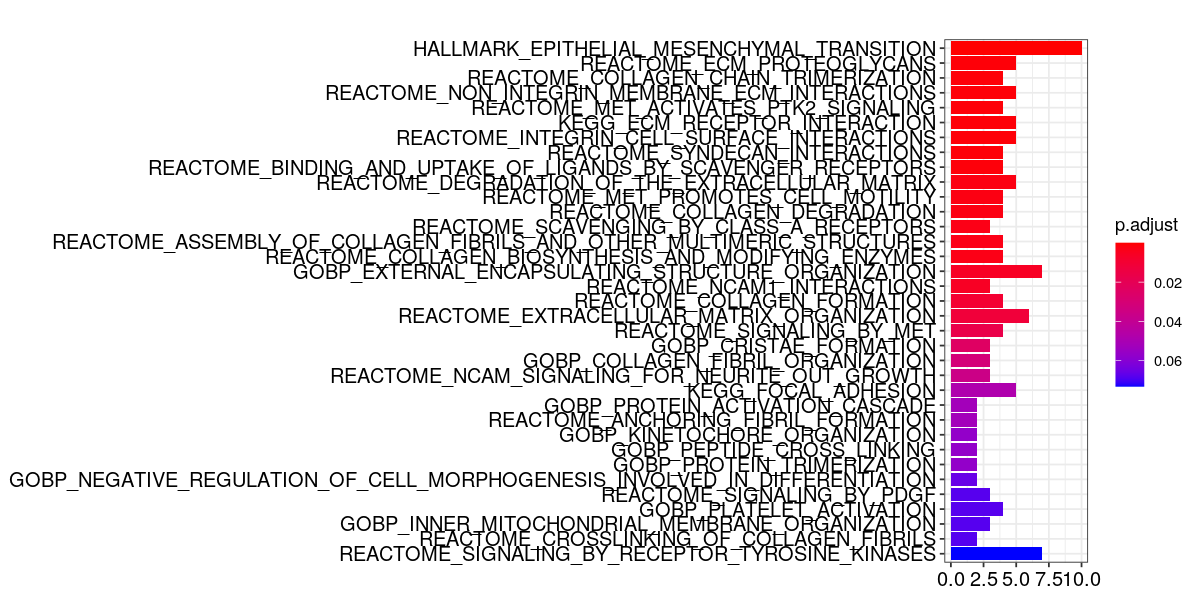

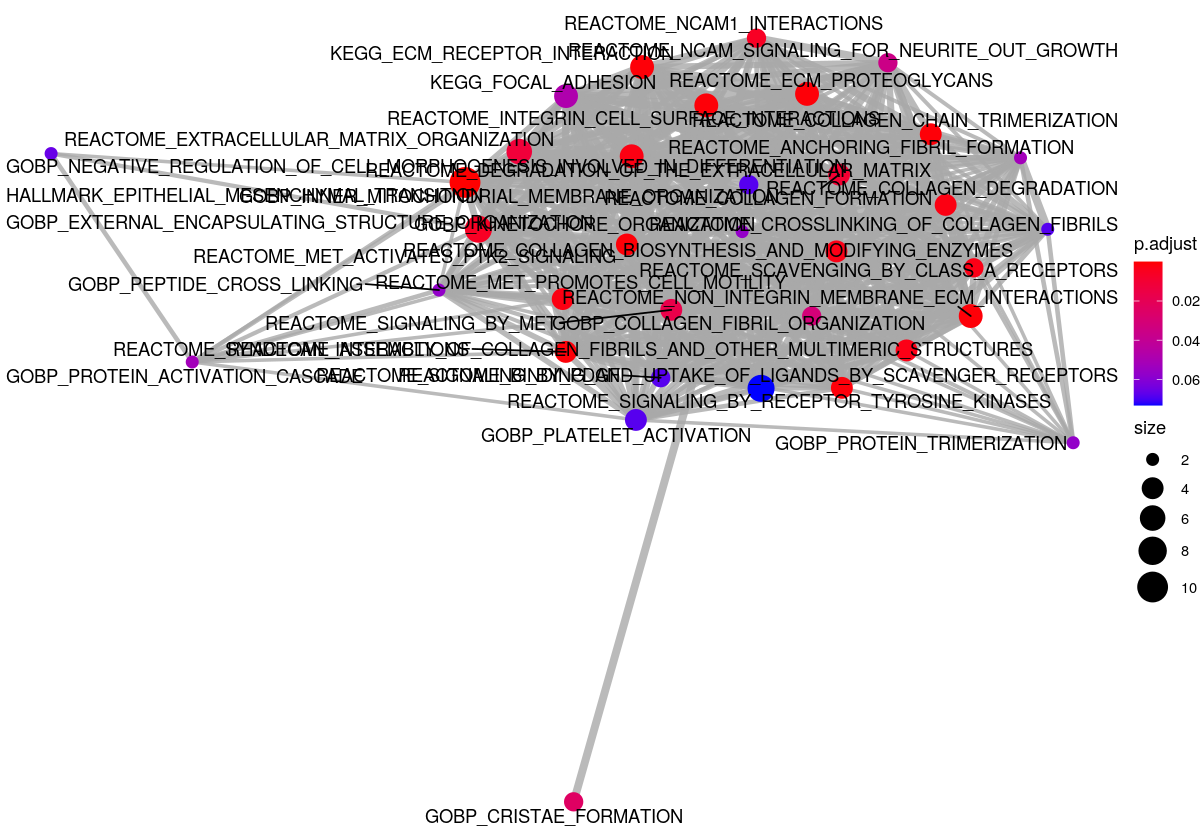

In [58]:
options(repr.plot.width=10, repr.plot.height=5)
barplot(res, showCategory=35)
#emapplot(enrichplot::pairwise_termsim(ego))
options(repr.plot.width=10, repr.plot.height=7)
emapplot(res, showCategory = 35)
#ggsave('enrichGO_CC_barplot.png', height = 9, width = 11.5)
